# **Imports and installations**

In [1]:
!pip install datasets
!pip install sacrerouge sacrebleu bert-score

!git clone https://github.com/huggingface/transformers.git
!pip install ./transformers/.

     |████████████████████████████████| 194kB 16.5MB/s 
     |████████████████████████████████| 245kB 27.2MB/s 
     |████████████████████████████████| 112kB 31.8MB/s 
     |████████████████████████████████| 327kB 11.3MB/s 
     |████████████████████████████████| 61kB 7.3MB/s 
     |████████████████████████████████| 61kB 7.2MB/s 
     |████████████████████████████████| 27.4MB 1.3MB/s 
     |████████████████████████████████| 61kB 9.3MB/s 
     |████████████████████████████████| 10.4MB 25.8MB/s 
     |████████████████████████████████| 2.0MB 54.1MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 1.1MB 31.7MB/s 
     |████████████████████████████████| 3.3MB 45.5MB/s 
     |████████████████████████████████| 870kB 43.1MB/s 
  Created wheel for overrides: filename=overrides-3.1.0-cp37-none-any.whl size=10174 sha256=0938015a9611746e78683e5229e26e29f26c0c52cc62bade30cfb739c1a4a7f7
  Stored in directory: /root/.cache/pip/wheels/5c/24/13/6ef8600e6f

In [2]:
!pip install rouge_metric

     |████████████████████████████████| 153kB 16.5MB/s 


In [3]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 11.5MB/s 


In [4]:
!pip install rouge_score

In [5]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import BartTokenizer, BartForConditionalGeneration, BartConfig
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import sentencepiece as spm
from datasets import list_datasets, list_metrics, load_dataset, load_metric
from pprint import pprint
import sklearn
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
import bert_score
import sacrebleu
import pandas as pd
from rouge_metric import PyRouge
from rouge_metric import PerlRouge
import torch
from tqdm import tqdm, trange
import io
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertConfig, BertModel, BertTokenizer
import seaborn as sns; sns.set()

In [6]:
!restart_runtime

/bin/bash: restart_runtime: command not found


In [7]:
!pip install datasets

# **Task 1**

# **1.1 - Use T5 model on new tasks and dataset**

## **Translation**

### **bible_para**

Importation of the dataset and split.

In [8]:
# loading dataset
bible_dataset = load_dataset("bible_para", lang1="en", lang2="fr", split='train')
bible_dataset_train, bible_dataset_test = train_test_split(bible_dataset, test_size=0.33, random_state=42)

Using custom data configuration en-fr-lang1=en,lang2=fr


Dataset bible_para downloaded and prepared to /root/.cache/huggingface/datasets/bible_para/en-fr-lang1=en,lang2=fr/0.0.0/b6cc20bcbfb0299beeba1dcc80a8420b975938ca0eef75b3ed30b50df7d950b1. Subsequent calls will reuse this data.


Creation of the inputs and outputs for the model.

In [9]:
# Creating the inputs/outputs

input = []
output = []
compteur = 0

for element in bible_dataset_test['translation']:
    input.append("translate English to French: " + str(element['en']))
    output.append(element['fr'])
    compteur += 1
    if compteur == 1000:
        break

input[:3]

['translate English to French: I exhort the elders among you, as a fellow elder, and a witness of the sufferings of Christ, and who will also share in the glory that will be revealed.',
 'translate English to French: To the more you shall give the more inheritance, and to the fewer you shall give the less inheritance: to everyone according to those who were numbered of him shall his inheritance be given.',
 "translate English to French: don't harden your hearts, as in the rebellion, like as in the day of the trial in the wilderness,"]

Definition of the model.

In [10]:
# T5 model

model = T5ForConditionalGeneration.from_pretrained('t5-small')
tok = T5Tokenizer.from_pretrained('t5-small')

input_encodings = tok.batch_encode_plus(input, padding=True, max_length=512, truncation=True, return_tensors="pt")
target_encodings = tok.batch_encode_plus(output, padding=True, max_length=512, truncation=True, return_tensors="pt")

model.to("cuda")
input_encodings.to("cuda")

model_output = model.generate(input_encodings["input_ids"], max_length = 512)

Let's print some results !

In [11]:
## converting model output into text (this is called tokenizer "decoding") (not to confuse with decoding algorithms like sampling and beam search these have the function model.generate)

model_output_decoded = tok.batch_decode(model_output, skip_special_tokens=True)

compteur = 0

for s,t,g in zip(input, output, model_output_decoded):
    print("source:\t {}\ntarget:\t{}\ngenerated\t{}".format(s[0:1000],t,g))
    print("\n#######################\n")
    compteur += 1
    if compteur == 10:
        break

source:	 translate English to French: I exhort the elders among you, as a fellow elder, and a witness of the sufferings of Christ, and who will also share in the glory that will be revealed.
target:	Voici les exhortations que j`adresse aux anciens qui sont parmi vous, moi ancien comme eux, témoin des souffrances de Christ, et participant de la gloire qui doit être manifestée:
generated	Je prie les aînés parmi vous, en tant que témoin des souffrances du Christ, et qui partagera également la gloire qui sera révélée.

#######################

source:	 translate English to French: To the more you shall give the more inheritance, and to the fewer you shall give the less inheritance: to everyone according to those who were numbered of him shall his inheritance be given.
target:	A ceux qui sont en plus grand nombre tu donneras une portion plus grande, et à ceux qui sont en plus petit nombre tu donneras une portion plus petite; on donnera à chacun sa portion d`après le dénombrement.
generated	

### **ted_talks_iwslt**

Importation of the dataset and splits.

In [12]:
ted_dataset = load_dataset("ted_talks_iwslt", language_pair=("en", "fr"), year="2016", split = 'train')
ted_dataset_train, ted_dataset_test = train_test_split(ted_dataset, test_size=0.33, random_state=42)

Using custom data configuration en_fr_2016-3e2ac5b7c2b72376


Dataset ted_talks_iwslt downloaded and prepared to /root/.cache/huggingface/datasets/ted_talks_iwslt/en_fr_2016-3e2ac5b7c2b72376/1.1.0/caf519a0a183db297ca5f39dbfd42de3a415aaa79b5a638edd4fd7a3e3b0e545. Subsequent calls will reuse this data.


Inputs and outputs of the model.

In [13]:
# Creating the inputs/outputs

input = []
output = []
compteur = 0

for element in ted_dataset_test['translation']:
    input.append("translate English to French: " + str(element['en']))
    output.append(element['fr'])
    compteur += 1
    if compteur == 1000:
        break

input[:3]

['translate English to French: Avi Reichental: What’s next in 3D printing',
 'translate English to French: Dr. Seyi Oyesola takes a searing look at health care in underdeveloped countries. His photo tour of a Nigerian teaching hospital -- all low-tech hacks and donated supplies -- drives home the challenge of doing basic health care there.',
 'translate English to French: Nature’s beauty can be fleeting -- but not through Louie Schwartzberg’s lens. His stunning time-lapse photography, accompanied by powerful words from Benedictine monk Brother David Steindl-Rast, serves as a meditation on being grateful for every day.']

Definition of the model.

In [14]:
# T5 model

model = T5ForConditionalGeneration.from_pretrained('t5-small')
tok = T5Tokenizer.from_pretrained('t5-small')

input_encodings = tok.batch_encode_plus(input, padding=True, max_length=512, truncation=True, return_tensors="pt")
target_encodings = tok.batch_encode_plus(output, padding=True, max_length=512, truncation=True, return_tensors="pt")

model.to("cuda")
input_encodings.to("cuda")

model_output = model.generate(input_encodings["input_ids"], max_length = 512)

Let's print some results !

In [15]:
## converting model output into text (this is called tokenizer "decoding") (not to confuse with decoding algorithms like sampling and beam search these have the function model.generate)

model_output_decoded = tok.batch_decode(model_output, skip_special_tokens=True)

compteur = 0

for s,t,g in zip(input, output, model_output_decoded):
    print("source:\t {}\ntarget:\t{}\ngenerated\t{}".format(s[0:1000],t,g))
    print("\n#######################\n")
    compteur += 1
    if compteur == 10:
        break

source:	 translate English to French: Avi Reichental: What’s next in 3D printing
target:	Avi Reichental: L'avenir de l'impression 3D
generated	Avi Reichental : Quoi de suite en imprimant 3D

#######################

source:	 translate English to French: Dr. Seyi Oyesola takes a searing look at health care in underdeveloped countries. His photo tour of a Nigerian teaching hospital -- all low-tech hacks and donated supplies -- drives home the challenge of doing basic health care there.
target:	Le docteur Seyi Oyesola nous donne une perspective incisive sur les services de santé dans les pays sous-développés. Son tour photographique d'un centre hospitalo-universitaire - concernant des solutions rudimentaires et des divers dons - met l'accent sur les défis en donnant aux nigérians les services de santé élémentaires.
generated	Seyi Oyesola a l'occasion de se pencher sur les soins de santé dans les pays sous-développés et sa visite photo d'un hôpital d'enseignement nigérian - tous les appare

## **Summarization** with cnn-dailymail dataset

Importation of the dataset and split.

In [16]:
# loading dataset
cnn_dailymail_dataset = load_dataset('cnn_dailymail', '3.0.0')
cnn_dailymail_train_dataset = load_dataset('cnn_dailymail', '3.0.0', split='train')
cnn_dailymail_valid_dataset = load_dataset('cnn_dailymail', '3.0.0', split='validation')
cnn_dailymail_test_dataset = load_dataset('cnn_dailymail', '3.0.0', split='test')

NotADirectoryError: ignored

Creation of the inputs and outputs for the model.

In [ ]:
input = []
compteur = 0

for element in cnn_dailymail_test_dataset['article']:
    input.append("summarize: " + str(element))

    compteur += 1
    if compteur == 100:
        break

for element in cnn_dailymail_test_dataset['highlights']:
    input_h.append(str(element))

    compteur += 1
    if compteur == 100:
        break


Definition of the model.

In [ ]:
# T5 model
model = T5ForConditionalGeneration.from_pretrained('t5-small')
tok = T5Tokenizer.from_pretrained('t5-small')

input_encodings = tok.batch_encode_plus(input, padding=True, max_length=512, truncation=True, return_tensors="pt")

model.to("cuda")
input_encodings.to("cuda")

model_output = model.generate(input_encodings["input_ids"], max_length = 512)

Let's print some results !

In [ ]:
model_output_decoded = tok.batch_decode(model_output, skip_special_tokens=True)

compteur = 0

for s,g in zip(input_h, model_output_decoded):

    print("source:\t {}\ngenerated\t{}\n------\n".format(s[0:1000],g))
    print("\n#######################\n")
    compteur += 1

    if compteur == 10:
        break

## **Question answering** with boolq dataset

Importation of the dataset and splits.

In [17]:
# loading dataset
boolq_dataset = load_dataset('boolq')
boolq_train_dataset = load_dataset('boolq', split='train')
boolq_valid_dataset = load_dataset('boolq', split='validation')
#cnn_dailymail_test_dataset = load_dataset('boolq', split='test') doesn't exist

Using custom data configuration default


Dataset boolq downloaded and prepared to /root/.cache/huggingface/datasets/boolq/default/0.1.0/1fcfdc6f36dc89a2245ffbbd5248ab33890594b50396731ebc78411bdd2ca534. Subsequent calls will reuse this data.


Using custom data configuration default
Reusing dataset boolq (/root/.cache/huggingface/datasets/boolq/default/0.1.0/1fcfdc6f36dc89a2245ffbbd5248ab33890594b50396731ebc78411bdd2ca534)
Using custom data configuration default
Reusing dataset boolq (/root/.cache/huggingface/datasets/boolq/default/0.1.0/1fcfdc6f36dc89a2245ffbbd5248ab33890594b50396731ebc78411bdd2ca534)


Creating the inputs and outputs for the model.

In [18]:
input = []
output = []
compteur = 0

for element_id in range (0, len(boolq_valid_dataset)):

    question = boolq_valid_dataset[element_id]['question']
    answer = boolq_valid_dataset[element_id]['answer']
    passage = boolq_valid_dataset[element_id]['passage']

    input.append('question: ' + question + ' context: ' + passage)

    if answer == 'true':

        output.append('yes')
    else:
        output.append('no')

    compteur += 1

    if compteur == 100:
        break

input[:3]

["question: does ethanol take more energy make that produces context: All biomass goes through at least some of these steps: it needs to be grown, collected, dried, fermented, distilled, and burned. All of these steps require resources and an infrastructure. The total amount of energy input into the process compared to the energy released by burning the resulting ethanol fuel is known as the energy balance (or ``energy returned on energy invested''). Figures compiled in a 2007 report by National Geographic Magazine point to modest results for corn ethanol produced in the US: one unit of fossil-fuel energy is required to create 1.3 energy units from the resulting ethanol. The energy balance for sugarcane ethanol produced in Brazil is more favorable, with one unit of fossil-fuel energy required to create 8 from the ethanol. Energy balance estimates are not easily produced, thus numerous such reports have been generated that are contradictory. For instance, a separate survey reports that 

In [19]:
model = AutoModelForSeq2SeqLM.from_pretrained("mrm8488/t5-small-finetuned-boolq", output_attentions=True)
tok = T5Tokenizer.from_pretrained('t5-small')

input_encodings = tok.batch_encode_plus(input, padding=True, max_length=512, truncation=True, return_tensors="pt")
target_encodings = tok.batch_encode_plus(output, padding=True, max_length=512, truncation=True, return_tensors="pt")

model.to("cuda")
input_encodings.to("cuda")

model_output = model.generate(input_encodings["input_ids"], max_length = 512)

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


Let's print some results !

In [20]:
compteur = 0

model_output_decoded = tok.batch_decode(model_output, skip_special_tokens=True)

for s,t, g in zip(input, output, model_output_decoded):

    print("source:\t {}\ntarget\t{}\ngenerated\t{}\n------\n".format(s[0:1000],t,g))
    print("\n#######################\n")

    compteur += 1

    if compteur == 10:
        break

source:	 question: does ethanol take more energy make that produces context: All biomass goes through at least some of these steps: it needs to be grown, collected, dried, fermented, distilled, and burned. All of these steps require resources and an infrastructure. The total amount of energy input into the process compared to the energy released by burning the resulting ethanol fuel is known as the energy balance (or ``energy returned on energy invested''). Figures compiled in a 2007 report by National Geographic Magazine point to modest results for corn ethanol produced in the US: one unit of fossil-fuel energy is required to create 1.3 energy units from the resulting ethanol. The energy balance for sugarcane ethanol produced in Brazil is more favorable, with one unit of fossil-fuel energy required to create 8 from the ethanol. Energy balance estimates are not easily produced, thus numerous such reports have been generated that are contradictory. For instance, a separate survey report

# **1.2 - Implement Extra evaluation Metrics**

## **BLEU**

### **Tranlation task : bible_para**

Importation of the dataset and split.

In [21]:
# loading dataset
bible_dataset = load_dataset("bible_para", lang1="en", lang2="fr", split='train')
bible_dataset_train, bible_dataset_test = train_test_split(bible_dataset, test_size=0.33, random_state=42)

Using custom data configuration en-fr-lang1=en,lang2=fr
Reusing dataset bible_para (/root/.cache/huggingface/datasets/bible_para/en-fr-lang1=en,lang2=fr/0.0.0/b6cc20bcbfb0299beeba1dcc80a8420b975938ca0eef75b3ed30b50df7d950b1)


Creation of the inputs and outputs for the model.

In [22]:
# Creating the inputs/outputs

input = []
output = []
compteur = 0

for element in bible_dataset_test['translation']:
    input.append("translate English to French: " + str(element['en']))
    output.append(element['fr'])
    compteur += 1
    if compteur == 10:
        break

# T5 model

model = T5ForConditionalGeneration.from_pretrained('t5-small')
tok = T5Tokenizer.from_pretrained('t5-small')

input_encodings = tok.batch_encode_plus(input, padding=True, max_length=512, truncation=True, return_tensors="pt")
target_encodings = tok.batch_encode_plus(output, padding=True, max_length=512, truncation=True, return_tensors="pt")

model.to("cuda")
input_encodings.to("cuda")

model_output = model.generate(input_encodings["input_ids"], max_length = 512)
## converting model output into text (this is called tokenizer "decoding") (not to confuse with decoding algorithms like sampling and beam search these have the function model.generate)

model_output_decoded = tok.batch_decode(model_output, skip_special_tokens=True)

compteur = 0

for s,t,g in zip(input, output, model_output_decoded):
    print("source:\t {}\ntarget:\t{}\ngenerated\t{}".format(s[0:1000],t,g))
    print("\n#######################\n")
    compteur += 1
    if compteur == 1:
        break

source:	 translate English to French: I exhort the elders among you, as a fellow elder, and a witness of the sufferings of Christ, and who will also share in the glory that will be revealed.
target:	Voici les exhortations que j`adresse aux anciens qui sont parmi vous, moi ancien comme eux, témoin des souffrances de Christ, et participant de la gloire qui doit être manifestée:
generated	Je prie les aînés parmi vous, en tant que témoin des souffrances du Christ, et qui partagera également la gloire qui sera révélée.

#######################



### Let's appreciate these results regarding an appropriate metric : BLEU score

What is the BLEU metric ? BLEU, or the Bilingual Evaluation Understudy, is a score for comparing a candidate translation of text to one or more reference translations. A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0. One problem with BLEU scores is that they tend to favor short translations, which can produce very high precision scores, even using modified precision. The approach works by counting matching n-grams in the candidate translation to n-grams in the reference text, where 1-gram or unigram would be each token and a bigram comparison would be each word pair. The comparison is made regardless of word order.

In [23]:
from collections import Counter
import numpy as np

#Function to lower case and split into tokens
lower_n_split = lambda x: x.lower().split()

#Function that creates n-grams from a given sentence
def make_ngrams(sentence, n):
    words = lower_n_split(sentence)
    ngrams = []
    for i in range(len(words) - n + 1):
        ngrams.append(" ".join(words[i : i + n]))
    return ngrams

#Precision function that checks for repeated bag of words by using clipped counts
def precision_clip(ca, refs, n):
    ngrams = make_ngrams(ca, n)
    ngram_counts = Counter(ngrams)
    total_count = 0
    for ngram in set(ngrams):
        max_count = 0
        for ref in refs:
            max_count = max(max_count, Counter(make_ngrams(ref, n)).get(ngram, 0))
        total_count += min(max_count, ngram_counts[ngram])
    return total_count / len(ngrams)

#Function that penalizes short candidate translations
def brevity_penalty(ca, refs):
    ca_len = len(ca)
    if ca_len == 0:
        return 0
    cleaned_refs = (lower_n_split(ref) for ref in refs)
    ref_lens = (len(ref) for ref in cleaned_refs)
    closest_ref_len = min(ref_lens, key=lambda ref_len: abs(ca_len - ref_len))
    return 1 if ca_len > closest_ref_len else np.exp(1 - closest_ref_len / ca_len)

#Function that using all previous functions computes the Bleu score
def bleu(ca, refs, weights, n_start, n_end):
    assert n_end >= n_start > 0
    bp = brevity_penalty(ca, refs)
    p_n = [precision_clip(ca, refs, n) for n in range(n_start, n_end + 1)]
    return bp * np.exp(sum(w * np.log(p) for w, p in zip(weights, p_n)))

Here is the BLEU score by sentence

In [24]:
compteur = 0

for s,t,g in zip(input, output, model_output_decoded):

    print("source:\t {}\ntarget:\t{}\ngenerated\t{}".format(s[0:1000],t,g))

    reference = t
    candidate = g
    score_b_implemented = bleu(candidate, [reference], [0.8,0.2], 1, 2)
    score_b_library = sentence_bleu(reference, candidate)
    print("implemented BLEU score: ", score_b_implemented)
    print("library BLEU score: ", score_b_library)
    print("\n##################################\n")

    compteur += 1

    if compteur == 5:
        break

source:	 translate English to French: I exhort the elders among you, as a fellow elder, and a witness of the sufferings of Christ, and who will also share in the glory that will be revealed.
target:	Voici les exhortations que j`adresse aux anciens qui sont parmi vous, moi ancien comme eux, témoin des souffrances de Christ, et participant de la gloire qui doit être manifestée:
generated	Je prie les aînés parmi vous, en tant que témoin des souffrances du Christ, et qui partagera également la gloire qui sera révélée.
implemented BLEU score:  0.48856024743963644
library BLEU score:  0.6485539682067227

##################################

source:	 translate English to French: To the more you shall give the more inheritance, and to the fewer you shall give the less inheritance: to everyone according to those who were numbered of him shall his inheritance be given.
target:	A ceux qui sont en plus grand nombre tu donneras une portion plus grande, et à ceux qui sont en plus petit nombre tu donn

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Here is the BLEU score of the corpus

In [25]:
percision,recall,fscore = bert_score.score(cands=model_output_decoded, refs=output, lang="en")
bleu = sacrebleu.corpus_bleu(model_output_decoded, [output]).score


df = pd.DataFrame({
    "BLEU":bleu,
    "BERTSCORE-percision": [float(percision.mean())],
    "BERTSCORE-recall": [float(recall.mean())],
    "BERTSCORE-fscore": [float(fscore.mean())]
    })

df

BLEU  BERTSCORE-percision  BERTSCORE-recall  BERTSCORE-fscore
0  9.278373             0.861844          0.859004          0.860232

## ROUGE

Importation of the dataset and split.

In [26]:
# loading dataset
cnn_dailymail_dataset = load_dataset('cnn_dailymail', '3.0.0')
cnn_dailymail_train_dataset = load_dataset('cnn_dailymail', '3.0.0', split='train')
cnn_dailymail_valid_dataset = load_dataset('cnn_dailymail', '3.0.0', split='validation')
cnn_dailymail_test_dataset = load_dataset('cnn_dailymail', '3.0.0', split='test')

NotADirectoryError: ignored

Creation of the inputs and outputs for the model.

In [ ]:
input = []
compteur = 0

for element in cnn_dailymail_test_dataset['article']:
    input.append("summarize: " + str(element))
    compteur += 1
    if compteur == 10:
        break

# T5 model
model = T5ForConditionalGeneration.from_pretrained('t5-small')
tok = T5Tokenizer.from_pretrained('t5-small')

input_encodings = tok.batch_encode_plus(input, padding=True, max_length=512, truncation=True, return_tensors="pt")

model.to("cuda")
input_encodings.to("cuda")

model_output = model.generate(input_encodings["input_ids"], max_length = 512)
model_output_decoded = tok.batch_decode(model_output, skip_special_tokens=True)

compteur = 0

for s,g in zip(input, model_output_decoded):

    print("source:\t {}\ngenerated\t{}\n------\n".format(s[0:1000],g))
    print("\n#######################\n")
    compteur += 1

    if compteur == 1:
        break

### Let's appreciate these results regarding an appropriate metric : ROUGE-2 score

ROUGE stands for Recall-Oriented Understudy for Gisting Evaluation. It is essentially a set of metrics for evaluating automatic summarization of texts as well as machine translations.

It works by comparing an automatically produced summary or translation against a set of reference summaries (typically human-produced). ROUGE-N — measures unigram, bigram, trigram and higher order n-gram overlap

In [ ]:
from __future__ import division
import collections

import six

def _ngrams(words, n):
    queue = collections.deque(maxlen=n)
    for w in words:
        queue.append(w)
        if len(queue) == n:
            yield tuple(queue)

def _ngram_counts(words, n):
    return collections.Counter(_ngrams(words, n))

def _ngram_count(words, n):
    return max(len(words) - n + 1, 0)

def _counter_overlap(counter1, counter2):
    result = 0
    for k, v in six.iteritems(counter1):
        result += min(v, counter2[k])
    return result

def _safe_divide(numerator, denominator):
    """
    Safely makes a division by making sure denominator is greater than 0.
    """
    if denominator > 0:
        return numerator / denominator
    else:
        return 0

def _safe_f1(matches, recall_total, precision_total, alpha):
    """
    Safely computes the f1 score by making sure denominator is greater than 0.
    """
    recall_score = _safe_divide(matches, recall_total)
    precision_score = _safe_divide(matches, precision_total)
    denom = (1.0 - alpha) * precision_score + alpha * recall_score
    if denom > 0.0:
        return precision_score, recall_score, (precision_score * recall_score) / denom
    else:
        return precision_score, recall_score, 0.0

def rouge_n(peer, models, n, alpha):
    """
    Compute the ROUGE-N score of a peer with respect to one or more models, for
    a given value of 'n'.
    """
    matches = 0
    recall_total = 0
    peer_counter = _ngram_counts(peer, n)
    for model in models:
        model_counter = _ngram_counts(model, n)
        matches += _counter_overlap(peer_counter, model_counter)
        recall_total += _ngram_count(model, n)
    precision_total = len(models) * _ngram_count(peer, n)
    return _safe_f1(matches, recall_total, precision_total, alpha)

def rouge_1(peer, models, alpha):
    """
    Compute the ROUGE-1 (unigram) score of a peer with respect to one or more
    models.
    """
    return rouge_n(peer, models, 1, alpha)

def rouge_2(peer, models, alpha):
    """
    Compute the ROUGE-2 (bigram) score of a peer with respect to one or more
    models.
    """
    return rouge_n(peer, models, 2, alpha)

def rouge_3(peer, models, alpha):
    """
    Compute the ROUGE-3 (trigram) score of a peer with respect to one or more
    models.
    """
    return rouge_n(peer, models, 3, alpha)

def lcs(a, b):
    """
    Compute the length of the longest common subsequence between two sequences.
    """
    if len(a) < len(b):
        a, b = b, a
    # Sequence b now has the minimum length
    # Quit early if one sequence is empty
    if len(b) == 0:
        return 0
    # Use a single buffer to store the counts for the current row, and
    # overwrite it on each pass
    row = [0] * len(b)
    for ai in a:
        left = 0
        diag = 0
        for j, bj in enumerate(b):
            up = row[j]
            if ai == bj:
                value = diag + 1
            else:
                value = max(left, up)
            row[j] = value
            left = value
            diag = up
    # Return the last cell of the last row
    return left

def rouge_l(peer, models, alpha):
    """
    Compute the ROUGE-L score of a peer with respect to one or more models.
    """
    matches = 0
    recall_total = 0
    for model in models:
        matches += lcs(model, peer)
        recall_total += len(model)
    precision_total = len(models) * len(peer)
    return _safe_f1(matches, recall_total, precision_total, alpha)

In [ ]:
scorer = rouge_scorer.RougeScorer(['rouge2'], use_stemmer=True)
compteur = 0

for s,g in zip(input, model_output_decoded):

    print("source:\t {}\ngenerated\t{}\n".format(s[0:1000],g))
    scores_library = scorer.score(s,g)
    #score_implemented = rouge_2(g,[s],alpha=0.5)
    precision_r, recall_r, score_r_implemented = rouge_2(g,[s],alpha=0.5)
    #print("implemented ROUGE score :", score_implemented)
    print("implemented ROUGE score : Precision ", precision_r, "Recall", recall_r, ",FScore ", score_r_implemented)
    print("library ROUGE score :", scores_library)
    print("\n##################################\n")

    compteur += 1

    if compteur == 10:
        break

Global Rouge score :

In [ ]:
rouge = PerlRouge(rouge_n_max=3, rouge_l=True, rouge_w=True,
    rouge_w_weight=1.2, rouge_s=True, rouge_su=True, skip_gap=4)

hypotheses = [i for i in input]
references = [[g] for g in model_output_decoded]

# Evaluate document-wise ROUGE scores
rouge = PyRouge(rouge_n=(1, 2, 4), rouge_l=True, rouge_w=True,
                rouge_w_weight=1.2, rouge_s=True, rouge_su=True, skip_gap=4)
scores = rouge.evaluate(hypotheses, references)


scores

Let's print the results with only the rouge-2.

In [ ]:
percision,recall,fscore = bert_score.score(cands=model_output_decoded, refs=input, lang="en")


df = pd.DataFrame({
    "ROUGESCORE-precision":scores['rouge-2']['p'],
    "ROUGESCORE-recall":scores['rouge-2']['r'],
    "ROUGESCORE-fscore":scores['rouge-2']['f'],
    "BERTSCORE-precision": [float(percision.mean())],
    "BERTSCORE-recall": [float(recall.mean())],
    "BERTSCORE-fscore": [float(fscore.mean())]
    })

df

## **Question answering** with boolq dataset

Importation of the dataset and splits.

In [27]:
# loading dataset
boolq_dataset = load_dataset('boolq')
boolq_train_dataset = load_dataset('boolq', split='train')
boolq_valid_dataset = load_dataset('boolq', split='validation')
#cnn_dailymail_test_dataset = load_dataset('boolq', split='test') doesn't exist

Using custom data configuration default
Reusing dataset boolq (/root/.cache/huggingface/datasets/boolq/default/0.1.0/1fcfdc6f36dc89a2245ffbbd5248ab33890594b50396731ebc78411bdd2ca534)
Using custom data configuration default
Reusing dataset boolq (/root/.cache/huggingface/datasets/boolq/default/0.1.0/1fcfdc6f36dc89a2245ffbbd5248ab33890594b50396731ebc78411bdd2ca534)
Using custom data configuration default
Reusing dataset boolq (/root/.cache/huggingface/datasets/boolq/default/0.1.0/1fcfdc6f36dc89a2245ffbbd5248ab33890594b50396731ebc78411bdd2ca534)


Creating the inputs and outputs for the model.

In [28]:
input = []
output = []
compteur = 0

for element_id in range (0, len(boolq_valid_dataset)):

    question = boolq_valid_dataset[element_id]['question']
    answer = boolq_valid_dataset[element_id]['answer']
    passage = boolq_valid_dataset[element_id]['passage']

    input.append('question: ' + question + ' context: ' + passage)

    if answer == 'true':

        output.append('yes')
    else:
        output.append('no')

    compteur += 1

    if compteur == 10:
        break

model = AutoModelForSeq2SeqLM.from_pretrained("mrm8488/t5-small-finetuned-boolq", output_attentions=True)
tok = T5Tokenizer.from_pretrained('t5-small')

input_encodings = tok.batch_encode_plus(input, padding=True, max_length=512, truncation=True, return_tensors="pt")
target_encodings = tok.batch_encode_plus(output, padding=True, max_length=512, truncation=True, return_tensors="pt")

model.to("cuda")
input_encodings.to("cuda")

model_output = model.generate(input_encodings["input_ids"], max_length = 512)
compteur = 0

model_output_decoded = tok.batch_decode(model_output, skip_special_tokens=True)

for s,t, g in zip(input, output, model_output_decoded):

    print("source:\t {}\ntarget\t{}\ngenerated\t{}\n------\n".format(s[0:1000],t,g))
    print("\n#######################\n")

    compteur += 1

    if compteur == 2:
        break

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


source:	 question: does ethanol take more energy make that produces context: All biomass goes through at least some of these steps: it needs to be grown, collected, dried, fermented, distilled, and burned. All of these steps require resources and an infrastructure. The total amount of energy input into the process compared to the energy released by burning the resulting ethanol fuel is known as the energy balance (or ``energy returned on energy invested''). Figures compiled in a 2007 report by National Geographic Magazine point to modest results for corn ethanol produced in the US: one unit of fossil-fuel energy is required to create 1.3 energy units from the resulting ethanol. The energy balance for sugarcane ethanol produced in Brazil is more favorable, with one unit of fossil-fuel energy required to create 8 from the ethanol. Energy balance estimates are not easily produced, thus numerous such reports have been generated that are contradictory. For instance, a separate survey report

### Let's appreciate these results regarding an appropriate metric : exact match and macro-F1

Exact match. This metric measures the percentage of predictions that match any one of the ground
truth answers exactly

In [29]:
def compute_exact_match(prediction, truth):
    return int((prediction) == (truth))

In [30]:
compteur = 0

for s,t, g in zip(input, output, model_output_decoded):
    print("source:\t {}\ntarget\t{}\ngenerated\t{}".format(s[0:1000],t,g))
    print('score: ', compute_exact_match(g, t))
    print("\n######################\n")
    compteur += 1

    if compteur == 10:
        break

source:	 question: does ethanol take more energy make that produces context: All biomass goes through at least some of these steps: it needs to be grown, collected, dried, fermented, distilled, and burned. All of these steps require resources and an infrastructure. The total amount of energy input into the process compared to the energy released by burning the resulting ethanol fuel is known as the energy balance (or ``energy returned on energy invested''). Figures compiled in a 2007 report by National Geographic Magazine point to modest results for corn ethanol produced in the US: one unit of fossil-fuel energy is required to create 1.3 energy units from the resulting ethanol. The energy balance for sugarcane ethanol produced in Brazil is more favorable, with one unit of fossil-fuel energy required to create 8 from the ethanol. Energy balance estimates are not easily produced, thus numerous such reports have been generated that are contradictory. For instance, a separate survey report

Global exact match for the test set. I have chosen to do an average of the exact matches by sentence. Indeed, a global exact match will probably be 0 because the model is not perfect.

In [31]:
compteur = 0
score = 0

for s,t, g in zip(input, output, model_output_decoded):
    score += compute_exact_match(g, t)
    compteur += 1

score_global = score / compteur

percision,recall,fscore = bert_score.score(cands=model_output_decoded, refs=output, lang="en")


df = pd.DataFrame({
    "EXACT_MATCH":score_global,
    "BERTSCORE-percision": [float(percision.mean())],
    "BERTSCORE-recall": [float(recall.mean())],
    "BERTSCORE-fscore": [float(fscore.mean())]
    })

df

EXACT_MATCH  BERTSCORE-percision  BERTSCORE-recall  BERTSCORE-fscore
0          0.3              0.99684           0.99684           0.99684

(Macro-averaged) F1 score. This metric measures the average overlap between the prediction and
ground truth answer. We treat the prediction and
ground truth as bags of tokens, and compute their
F1. We take the maximum F1 over all of the ground
truth answers for a given question, and then average
over all of the questions.

In [32]:
def compute_f1(prediction, truth):
    pred_tokens = (prediction).split()
    truth_tokens = (truth).split()
    
    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)
    
    common_tokens = set(pred_tokens) & set(truth_tokens)
    
    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0
    
    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)
    
    return 2 * (prec * rec) / (prec + rec)

In [33]:
model_output_decoded = tok.batch_decode(model_output, skip_special_tokens=True)
compteur = 0

for s,t, g in zip(input, output, model_output_decoded):
    print("source:\t {}\ntarget\t{}\ngenerated\t{}".format(s[0:1000],t,g))
    print('score: ', compute_f1(g, t))
    print("\n######################\n")
    compteur += 1
    if compteur == 10:
        break

source:	 question: does ethanol take more energy make that produces context: All biomass goes through at least some of these steps: it needs to be grown, collected, dried, fermented, distilled, and burned. All of these steps require resources and an infrastructure. The total amount of energy input into the process compared to the energy released by burning the resulting ethanol fuel is known as the energy balance (or ``energy returned on energy invested''). Figures compiled in a 2007 report by National Geographic Magazine point to modest results for corn ethanol produced in the US: one unit of fossil-fuel energy is required to create 1.3 energy units from the resulting ethanol. The energy balance for sugarcane ethanol produced in Brazil is more favorable, with one unit of fossil-fuel energy required to create 8 from the ethanol. Energy balance estimates are not easily produced, thus numerous such reports have been generated that are contradictory. For instance, a separate survey report

Global F1 score.

I also chose to do the average.

In [34]:
model_output_decoded = tok.batch_decode(model_output, skip_special_tokens=True)
compteur = 0
score_f1_ind = 0

for s,t, g in zip(input, output, model_output_decoded):
    score_f1_ind += compute_f1(g, t)
    compteur += 1

score_f1_global = score_f1_ind/compteur
print('score_f1_global' , score_f1_global)

score_f1_global 0.3


In [35]:
percision,recall,fscore = bert_score.score(cands=model_output_decoded, refs=output, lang="en")


df = pd.DataFrame({
    "EXACT_MATCH":score_global,
    "F1": score_f1_global,
    "BERTSCORE-percision": [float(percision.mean())],
    "BERTSCORE-recall": [float(recall.mean())],
    "BERTSCORE-fscore": [float(fscore.mean())]
    })

df

EXACT_MATCH   F1  BERTSCORE-percision  BERTSCORE-recall  BERTSCORE-fscore
0          0.3  0.3              0.99684           0.99684           0.99684

# **1.3- Implement Decoding methods your own**

## **Beam Search**

In [36]:
from datasets import load_dataset

import sklearn
from sklearn.model_selection import train_test_split
from math import log
import numpy as np

model = T5ForConditionalGeneration.from_pretrained('t5-small', output_attentions=True).to('cuda')
tokenizer = T5Tokenizer.from_pretrained('t5-small')

bible_dataset = load_dataset("bible_para", lang1="en", lang2="fr", split='train')
bible_dataset_train, bible_dataset_test = train_test_split(bible_dataset, test_size=0.33, random_state=42)
# Creating the inputs/outputs
input = []
output = []
compteur = 0
for element in bible_dataset_test['translation']:
    input.append("translate English to French: " + str(element['en']))
    output.append(element['fr'])
    compteur += 1
    if compteur == 1:
        break


input_ids = tok(input, padding=True, max_length=512, truncation=True, return_tensors="pt")  # Batch size 1
target_ids = tok(output, padding=True, max_length=512, truncation=True, return_tensors="pt").input_ids  # Batch size 1
data = model(input_ids=input_ids['input_ids'].to('cuda'), labels=target_ids.to('cuda')).logits.cpu().detach().numpy().squeeze()
 
# beam search
def beam_search_decoder(data, k):
    data = 1/(1+np.exp(-data))
    sequences = [[list(), 0.0]]
    # walk over each step in sequence
    for row in data:
        all_candidates = list()
        # expand each current candidate
        for i in range(len(sequences)):
            seq, score = sequences[i]
            for j in range(len(row)):
                if row[j] == 0:
                    candidate = [seq + [j], score + 1e3]
                else:
                    candidate = [seq + [j], score - log(row[j])]
                all_candidates.append(candidate)
            # order all candidates by score
            ordered = sorted(all_candidates, key=lambda tup:tup[1])
            # select k best
            sequences = ordered[:k]
    return sequences
Decoded_seq = beam_search_decoder(data, 3)
for seq in Decoded_seq:
    seq =  torch.tensor(seq[0])
    print(tokenizer.decode(seq, skip_special_tokens=True))
outputs =  model.generate(input_ids['input_ids'].cuda(), max_length=512)
model_output_decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)
print(model_output_decoded)


Using custom data configuration en-fr-lang1=en,lang2=fr
Reusing dataset bible_para (/root/.cache/huggingface/datasets/bible_para/en-fr-lang1=en,lang2=fr/0.0.0/b6cc20bcbfb0299beeba1dcc80a8420b975938ca0eef75b3ed30b50df7d950b1)


Je  hortations des jej'a aux as  vous parmi vous, -en, témoin- témoin des souffrances du Christ, et qui  la gloire qui sera être révélée.
Je  hortations des jej'a aux as  vous parmi vous, -en, témoin- témoin des souffrances du Christ, et qui  la gloire qui sera être révélée.
Je  hortations des jej'a aux as  vous parmi vous, -en, témoin- témoin des souffrances du Christ, et qui  la gloire qui sera être révélée. «
['Je prie les aînés parmi vous, en tant que témoin des souffrances du Christ, et qui partagera également la gloire qui sera révélée.']


## **Nucleus Sampling**

In [37]:
import torch.nn.functional as F
def top_p_filtering(logits, top_p=0.0, filter_value=-float('Inf')):
    logits = logits.type(torch.DoubleTensor)
    if top_p > 0.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
        logits = torch.where(cumulative_probs>top_p , logits, filter_value)
    return logits
data = model(input_ids=input_ids['input_ids'].to('cuda'), labels=target_ids.to('cuda')).logits.cpu().detach().numpy().squeeze()
top_p = 0.5
data = torch.tensor(data)
# Get logits with a forward pass in our model (input is pre-defined)
logits = data
logits = top_p_filtering(logits, top_p=0.5, filter_value=-float('Inf')).cpu().detach().numpy()
Decoded_seq = beam_search_decoder(logits, 3)
for seq in Decoded_seq:
    seq = torch.tensor(seq[0])
print(tokenizer.decode(seq, skip_special_tokens=True))

JeVous les parolehortations des jej'a aux as  vous parmi vous, -en, témoin- témoin des souffrances du Christ, et qui  la gloire qui sera être révélée. «


## **Softmax with Temperature**

In [38]:
from datasets import load_dataset

import sklearn
from sklearn.model_selection import train_test_split
from math import log
import numpy as np

model = T5ForConditionalGeneration.from_pretrained('t5-small', output_attentions=True).to('cuda')
tokenizer = T5Tokenizer.from_pretrained('t5-small')

bible_dataset = load_dataset("bible_para", lang1="en", lang2="fr", split='train')
bible_dataset_train, bible_dataset_test = train_test_split(bible_dataset, test_size=0.33, random_state=42)
# Creating the inputs/outputs
input = []
output = []
compteur = 0
for element in bible_dataset_test['translation']:
    input.append("translate English to French: " + str(element['en']))
    output.append(element['fr'])
    compteur += 1
    if compteur == 1:
        break


input_ids = tok(input, padding=True, max_length=512, truncation=True, return_tensors="pt")  # Batch size 1
target_ids = tok(output, padding=True, max_length=512, truncation=True, return_tensors="pt").input_ids  # Batch size 1
data = model(input_ids=input_ids['input_ids'].to('cuda'), labels=target_ids.to('cuda')).logits.cpu().detach().numpy().squeeze()
 
# softmax with temp
def softmax_T(data, k, T=0.5):
    data = (1/(1+np.exp(-(data/T))))
    sequences = [[list(), 0.0]]
    # walk over each step in sequence
    for row in data:
        all_candidates = list()
        # expand each current candidate
        for i in range(len(sequences)):
            seq, score = sequences[i]
            for j in range(len(row)):
                if row[j] == 0:
                    candidate = [seq + [j], score + 1e3]
                else:
                    candidate = [seq + [j], score - log(row[j])]
                all_candidates.append(candidate)
            # order all candidates by score
            ordered = sorted(all_candidates, key=lambda tup:tup[1])
            # select k best
            sequences = ordered[:k]
    return sequences
Decoded_seq = softmax_T(data, 3)
for seq in Decoded_seq:
    seq =  torch.tensor(seq[0])
    print(tokenizer.decode(seq, skip_special_tokens=True))
outputs =  model.generate(input_ids['input_ids'].cuda(), max_length=512)
model_output_decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)
print(model_output_decoded)


Using custom data configuration en-fr-lang1=en,lang2=fr
Reusing dataset bible_para (/root/.cache/huggingface/datasets/bible_para/en-fr-lang1=en,lang2=fr/0.0.0/b6cc20bcbfb0299beeba1dcc80a8420b975938ca0eef75b3ed30b50df7d950b1)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in exp


Je  hortations des jej'a aux as  vous parmi vous, -en, témoin- témoin des souffrances du Christ, et qui  la gloire qui sera être révélée.
Je  hortations des jej'a aux as  vous parmi vous, -en, témoin- témoin des souffrances du Christ, et qui  la gloire qui sera être révélée.
Je  hortations des jej'a aux as  vous parmi vous, -en, témoin- témoin des souffrances du Christ, et qui  la gloire qui sera être révélée. «
['Je prie les aînés parmi vous, en tant que témoin des souffrances du Christ, et qui partagera également la gloire qui sera révélée.']


#**Report**

In summary we see that:

Beam Search: Select the best probable response

Nucleus Sampling:  Selecting the highest probability tokens whose cumulative probability mass exceeds the pre-chosen threshold p. The size of the sampling set will adjust dynamically based on the shape of the probability distribution at each time step. For high values of conditional probabilities, this is a small subset of vocabulary that takes up vast majority of the probability mass.

Softmax Temperature: Shrink or enlarge probabilities. We were able to see that setting the temperature between 0 and 1 skews the distribution towards high probability events, which implicitly lowers the mass in the tail distribution.

# **Task 2 Attention Visualization**

# **2.1 Implement cross-attention matrix vizualization**



```
# This is formatted as code
```

# **QA**

In [39]:
CMAP = sns.light_palette("blue")
% matplotlib inline
np.random.seed(0);
TOTAL_NO_LAYERS = 6
TOTAL_NO_ATTEN_HEADS = 8
# loading dataset
boolq_dataset = load_dataset('boolq')
boolq_train_dataset = load_dataset('boolq', split='train')
boolq_valid_dataset = load_dataset('boolq', split='validation')
#cnn_dailymail_test_dataset = load_dataset('boolq', split='test') doesn't exist

input = []
output = []
compteur = 0

for element_id in range (0, len(boolq_valid_dataset)):

    question = boolq_valid_dataset[element_id]['question']
    answer = boolq_valid_dataset[element_id]['answer']
    passage = boolq_valid_dataset[element_id]['passage']

    input.append('question: ' + question + ' context: ' + passage)

    if answer == 'true':

        output.append('yes')
    else:
        output.append('no')

    compteur += 1

    if compteur == 100:
        break

Using custom data configuration default
Reusing dataset boolq (/root/.cache/huggingface/datasets/boolq/default/0.1.0/1fcfdc6f36dc89a2245ffbbd5248ab33890594b50396731ebc78411bdd2ca534)
Using custom data configuration default
Reusing dataset boolq (/root/.cache/huggingface/datasets/boolq/default/0.1.0/1fcfdc6f36dc89a2245ffbbd5248ab33890594b50396731ebc78411bdd2ca534)
Using custom data configuration default
Reusing dataset boolq (/root/.cache/huggingface/datasets/boolq/default/0.1.0/1fcfdc6f36dc89a2245ffbbd5248ab33890594b50396731ebc78411bdd2ca534)


In [40]:
model = AutoModelForSeq2SeqLM.from_pretrained("mrm8488/t5-small-finetuned-boolq", output_attentions=True)
tok = T5Tokenizer.from_pretrained('t5-small')
tokenized_text = tok.tokenize(input[0])
tokenized_text_ids = tok.convert_tokens_to_ids(tokenized_text)
tok.convert_ids_to_tokens(tokenized_text_ids)

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


['▁question',
 ':',
 '▁does',
 '▁',
 'ethanol',
 '▁take',
 '▁more',
 '▁energy',
 '▁make',
 '▁that',
 '▁produces',
 '▁context',
 ':',
 '▁All',
 '▁biomass',
 '▁goes',
 '▁through',
 '▁at',
 '▁least',
 '▁some',
 '▁of',
 '▁these',
 '▁steps',
 ':',
 '▁it',
 '▁needs',
 '▁to',
 '▁be',
 '▁grown',
 ',',
 '▁collected',
 ',',
 '▁dried',
 ',',
 '▁ferment',
 'e',
 'd',
 ',',
 '▁',
 'distilled',
 ',',
 '▁and',
 '▁burned',
 '.',
 '▁All',
 '▁of',
 '▁these',
 '▁steps',
 '▁require',
 '▁resources',
 '▁and',
 '▁an',
 '▁infrastructure',
 '.',
 '▁The',
 '▁total',
 '▁amount',
 '▁of',
 '▁energy',
 '▁input',
 '▁into',
 '▁the',
 '▁process',
 '▁',
 'compared',
 '▁to',
 '▁the',
 '▁energy',
 '▁released',
 '▁by',
 '▁burning',
 '▁the',
 '▁',
 'resulting',
 '▁',
 'ethanol',
 '▁fuel',
 '▁is',
 '▁known',
 '▁as',
 '▁the',
 '▁energy',
 '▁balance',
 '▁(',
 'or',
 '▁',
 '<unk>',
 'energy',
 '▁returned',
 '▁on',
 '▁energy',
 '▁invested',
 "'",
 "'",
 ').',
 '▁Figure',
 's',
 '▁',
 'compiled',
 '▁in',
 '▁',
 'a',
 '▁2007',
 '

In [41]:
#Convert to torch tensor
inp = torch.tensor(tokenized_text_ids)

print("input.shape: ", inp.shape) #torch.Size([15])
inp = inp.unsqueeze(dim=0) #add a dimension 
print("input.shape: ", inp.shape) #torch.Size([15])

#Fwd pass - get output
output = model(input_ids=inp, decoder_input_ids=inp) 
print("len(output): ", len(output))

input.shape:  torch.Size([294])
input.shape:  torch.Size([1, 294])
len(output):  6


In [42]:
def get_attentions(outputs, layer=0, attention_head=0, avg=False):
    '''
    get the particular output for a particular layer and attention head
    layer -> 0 to 5
    attention_head -> 0 to 7
    '''
    if avg:
        #avg over all attention heads in a layer
        return outputs.cross_attentions[layer].squeeze(0).mean(dim=0)

    #return values for a particular attention head inside a specific layer
    return outputs.cross_attentions[layer].squeeze(0)[attention_head]

In [43]:
def plt_attentions(mat, labs, fig_size=(20,20), annot=False, cmap = CMAP, title=None):
    '''
    plot the NxN matrix passed as a heat map

    mat: square matrix to visualize
    labs: labels for xticks and yticks (the tokens in our case)
    '''
    fig, ax = plt.subplots(figsize=fig_size) 
    # labels = tokenizer.convert_ids_to_tokens(input[0][0:non_zero_idx+1].numpy());
    # ax = sns.heatmap(output[2][0].squeeze(0)[0][0:non_zero_idx+1, 0:non_zero_idx+1].detach().numpy(), annot=True, yticklabels=labs,xticklabels=labs)
    ax = sns.heatmap(mat.detach().numpy(), annot=annot, yticklabels=labs,xticklabels=labs, cmap=cmap)
    ax.xaxis.set_ticks_position('top')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    if title:
        ax.set_title(title)

In [44]:
def plot_all_attentions(atts, layer=0, cmap = CMAP):
    '''
    function to plot all the attention matrices for a particular layer
    atts: all the attention weights returned by the library
    layer: layer number 
    '''
    fig = plt.figure(figsize=(20,20),facecolor='w', edgecolor='k')
    plt.tight_layout()
    fig.subplots_adjust(hspace=.2, wspace=0)

    #loop through all attention heads
    for i in range(0, TOTAL_NO_ATTEN_HEADS):
        ax = fig.add_subplot(8, 8, i+1)
        ax.set_title("L{}, H{}".format(layer, i))

        #get the matrix for particular layer and current attention head
        mat = get_attentions(atts, layer=layer, attention_head=i)

        #plot heatmap using sns
        res = sns.heatmap(mat.detach().numpy(),cmap=cmap, ax=ax, cbar=False, yticklabels=[],xticklabels=[])

        # make frame visible
        for _, spine in res.spines.items():
            spine.set_visible(True)

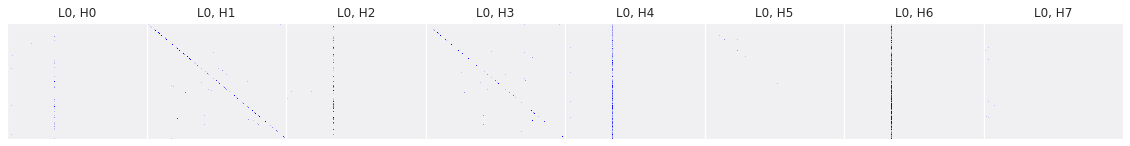

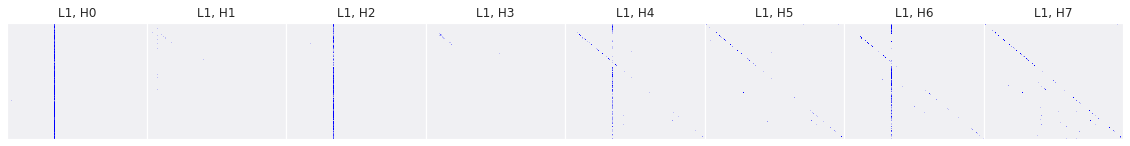

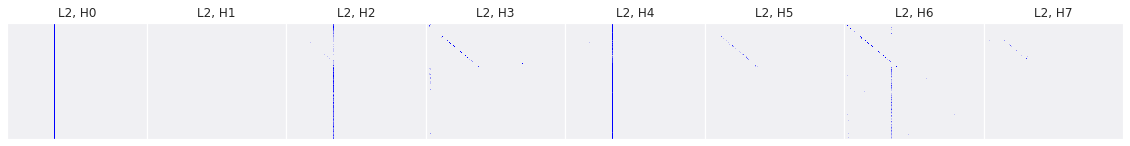

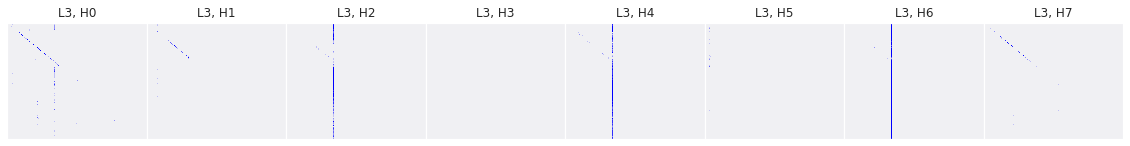

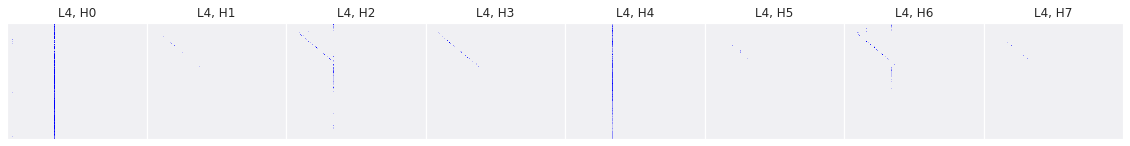

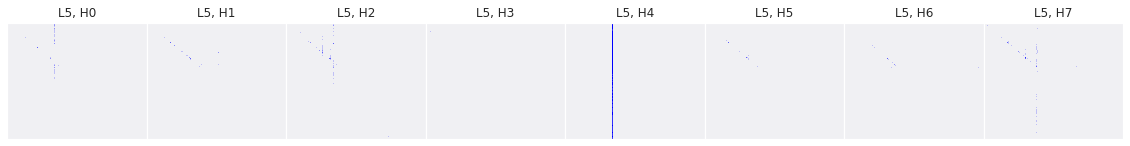

In [45]:
#Plot each attention head inside each layer
for lay in range(0, TOTAL_NO_LAYERS):
    plot_all_attentions(output, layer=lay)

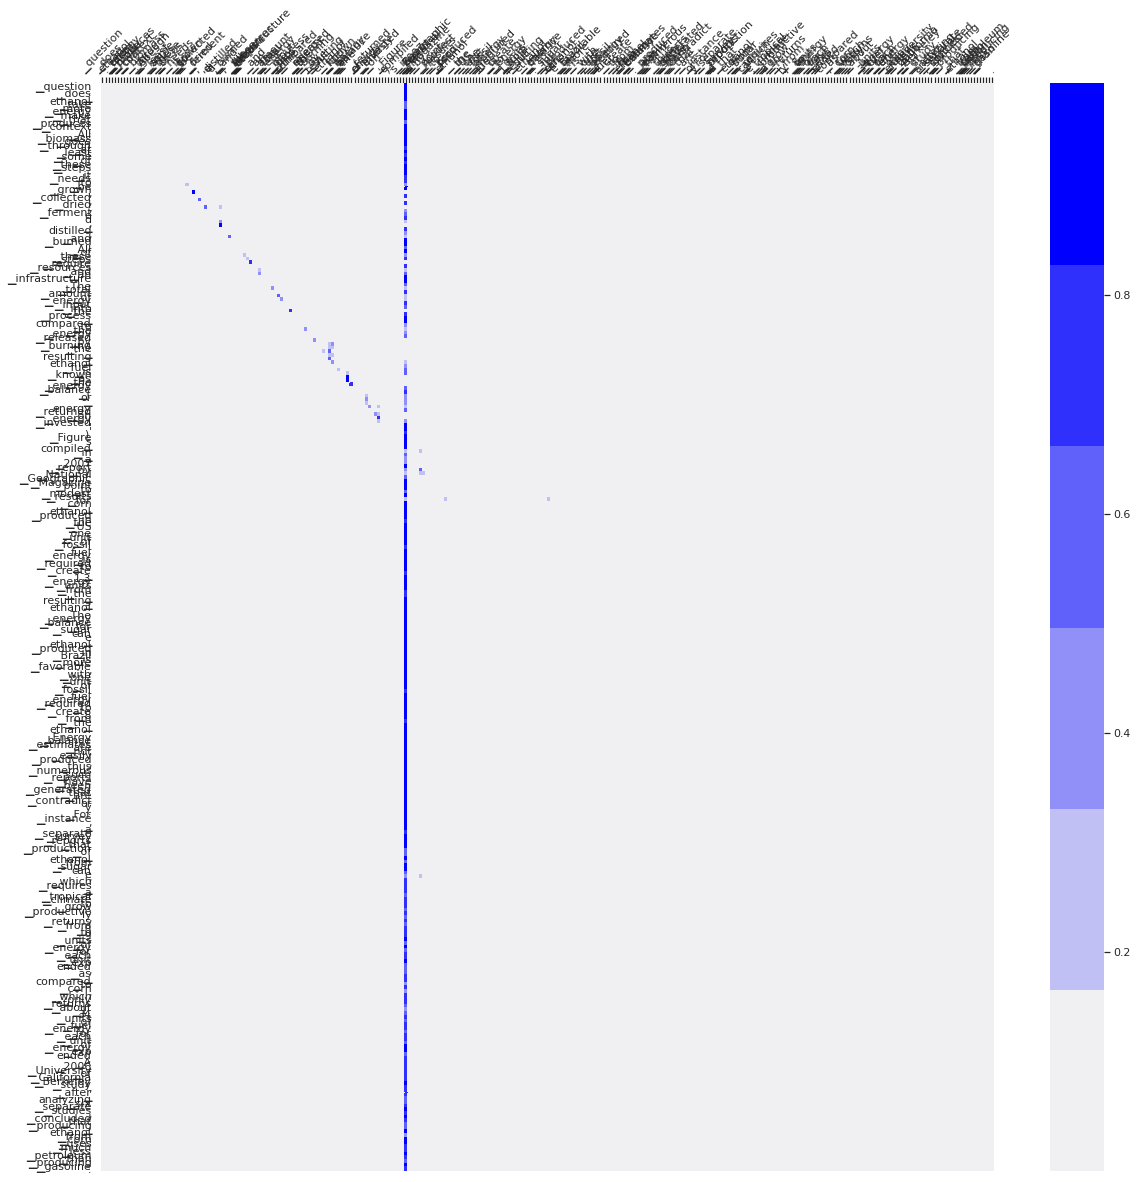

In [46]:
# Attention of layer 4 Head 5
plt_attentions(get_attentions(output, layer=4, attention_head=5), tokenized_text)

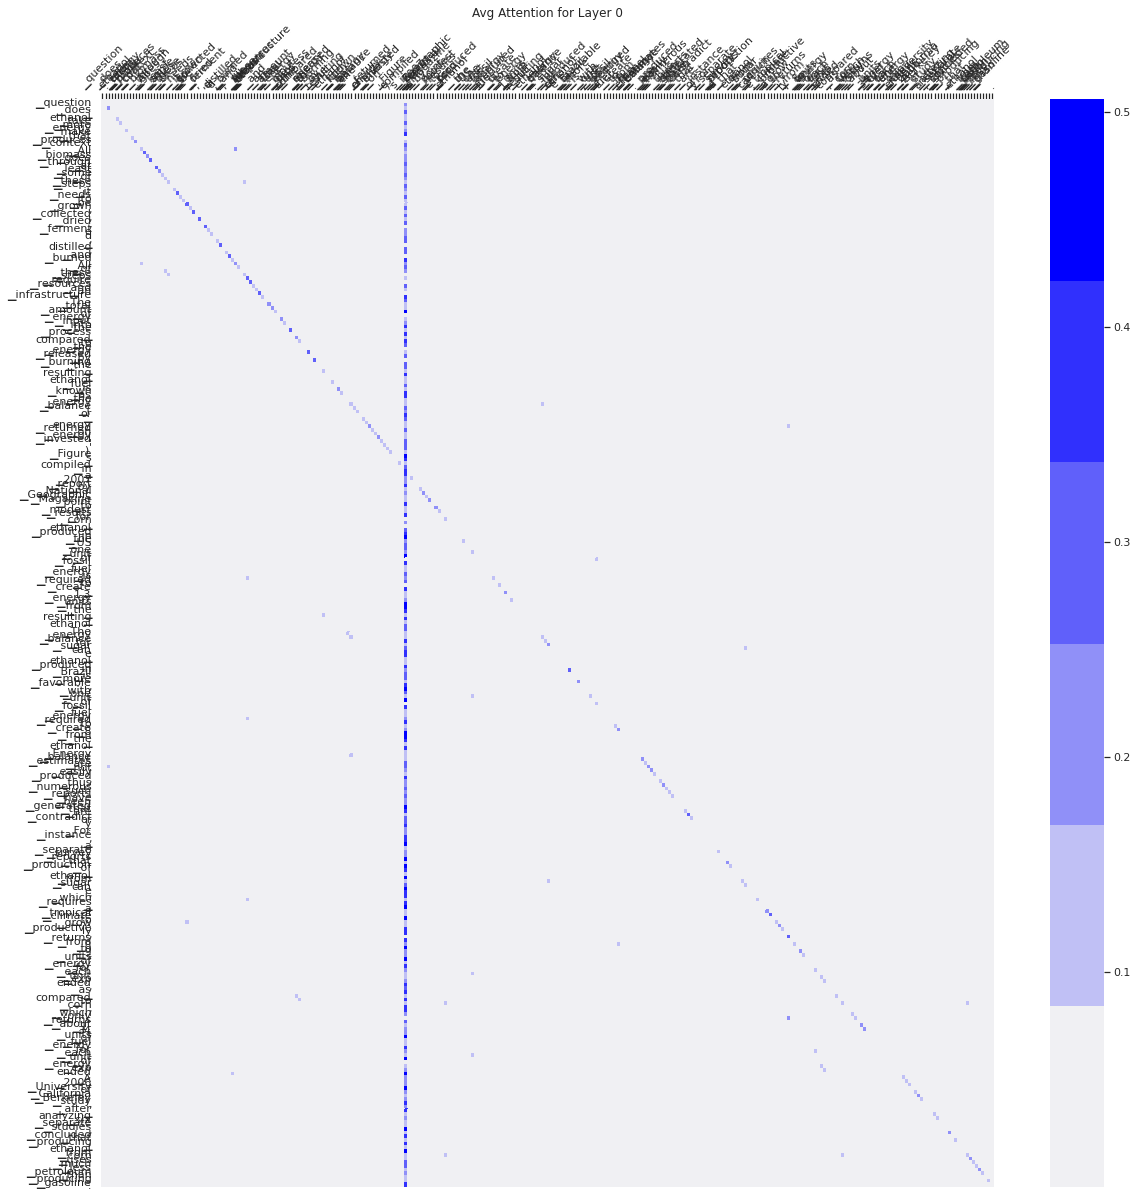

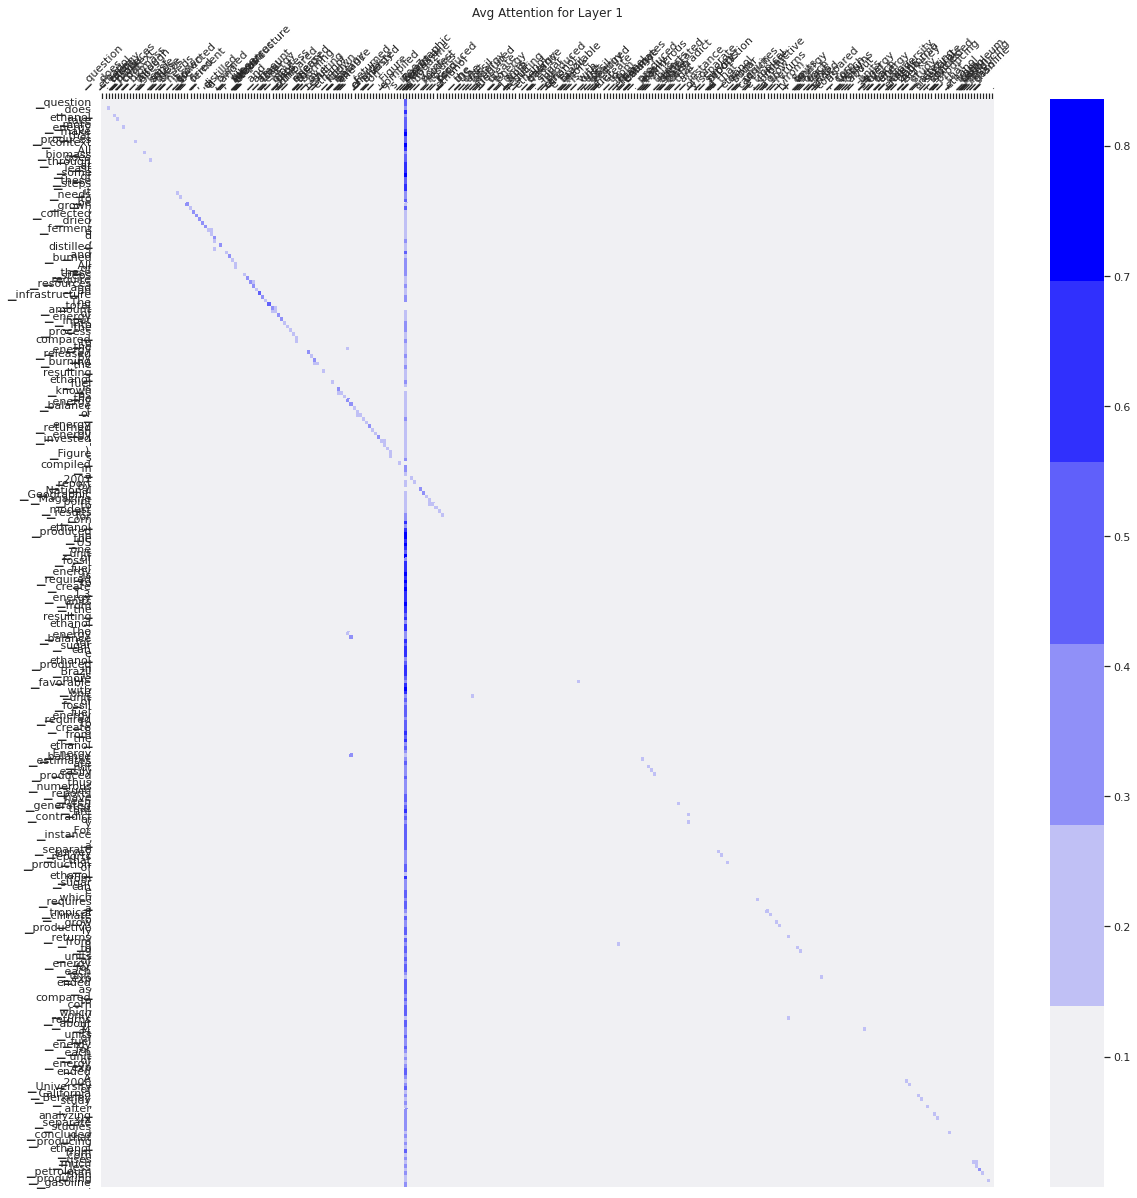

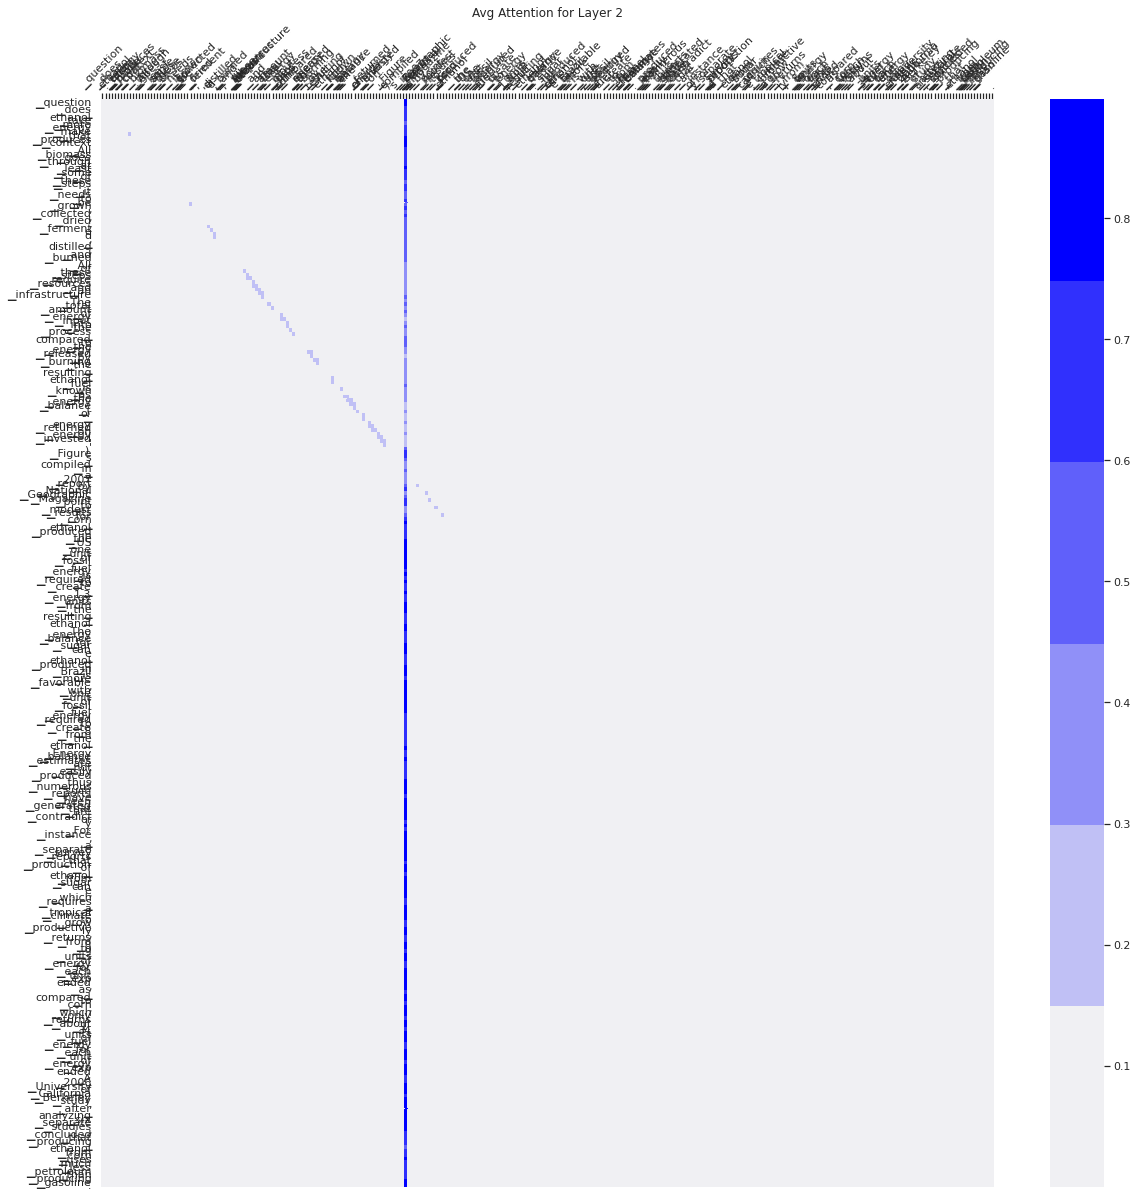

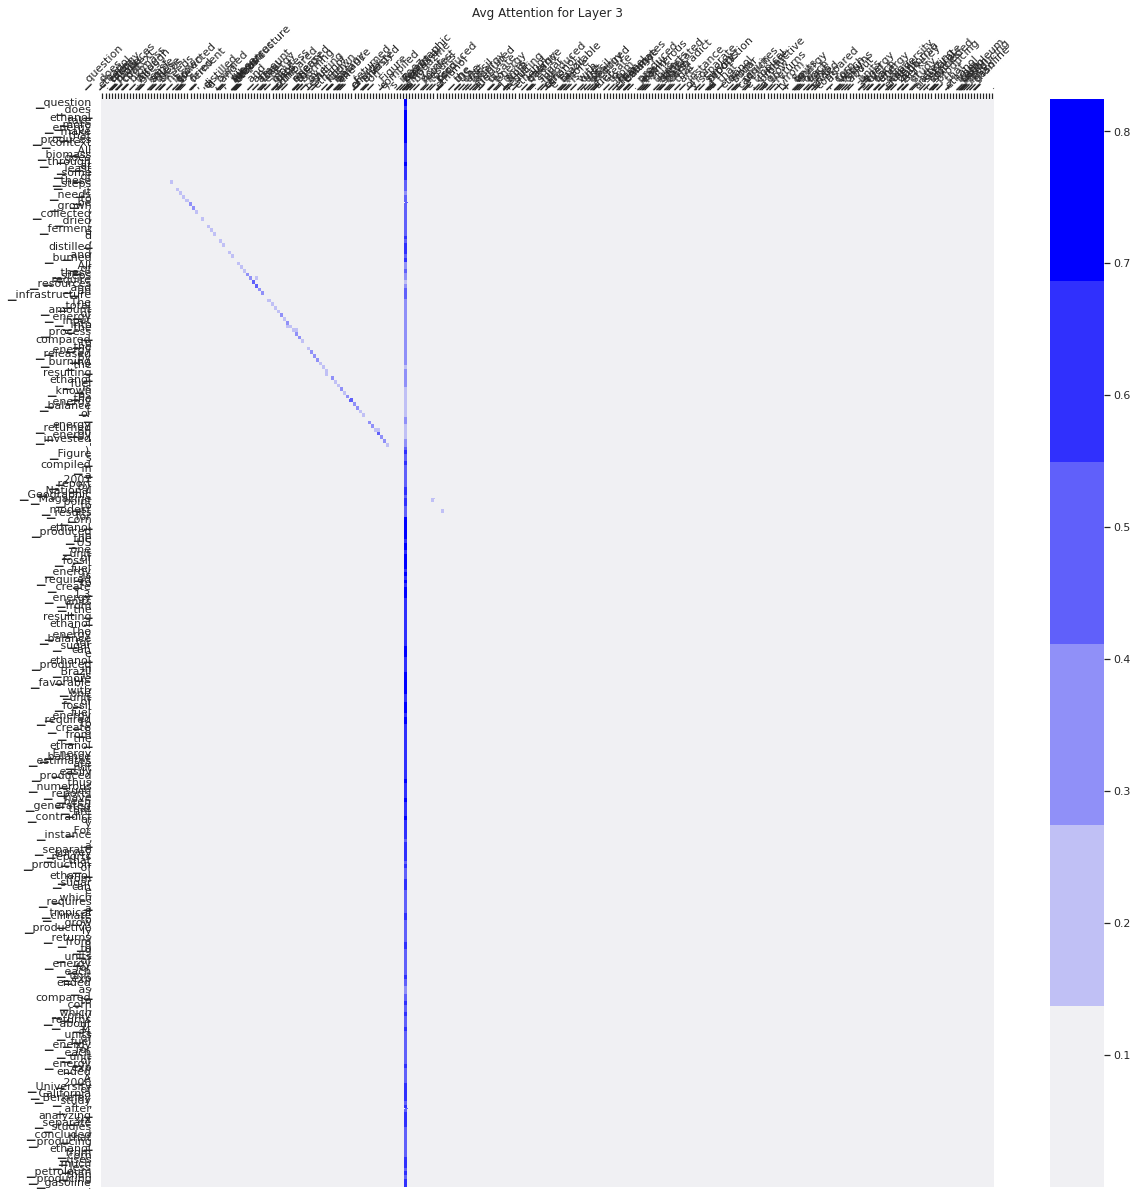

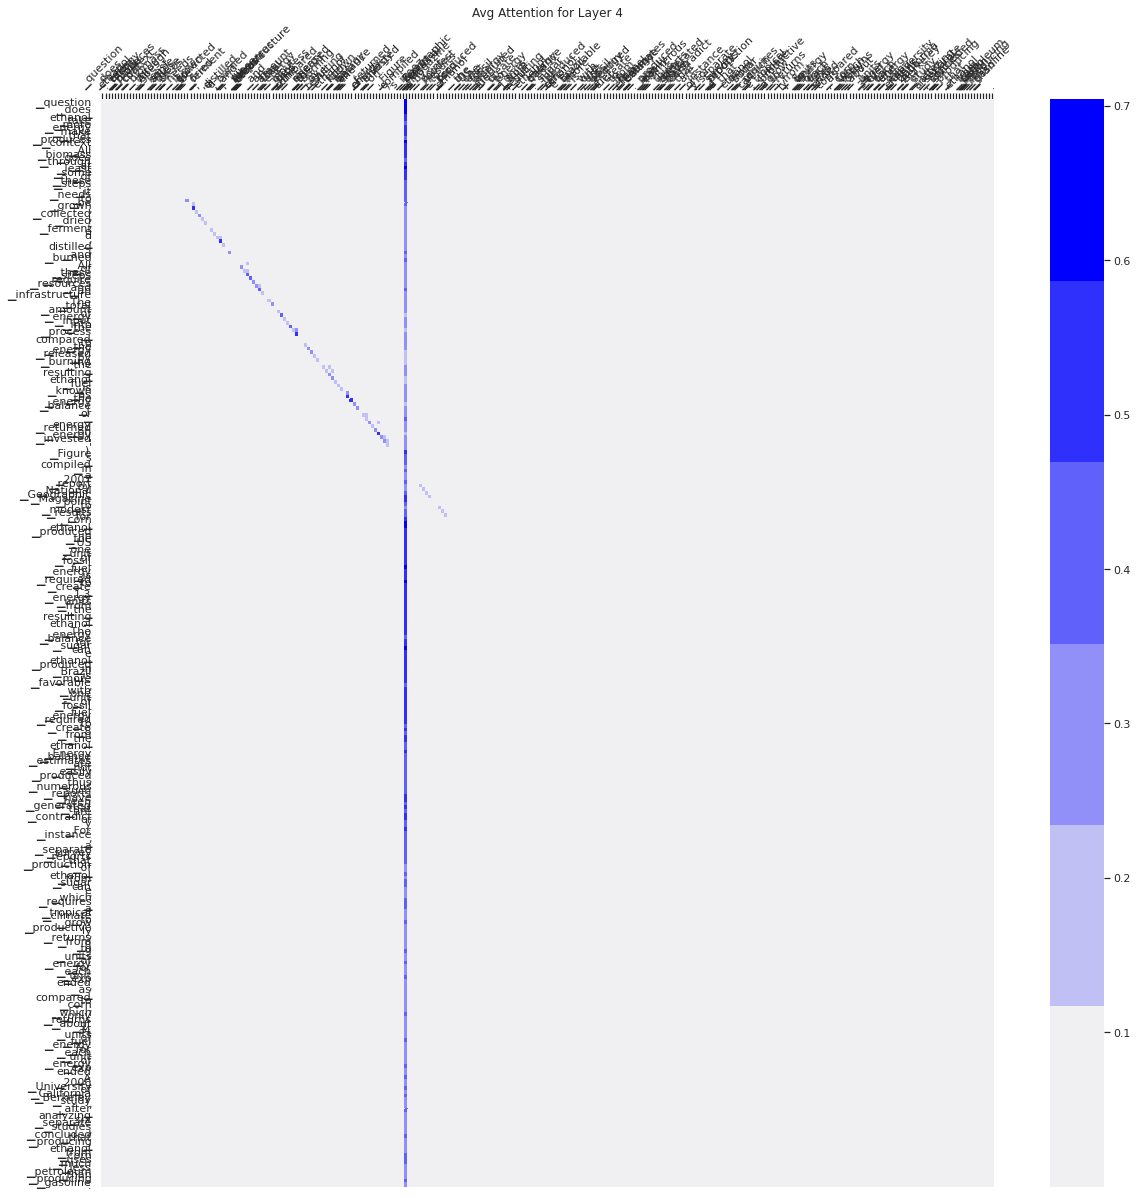

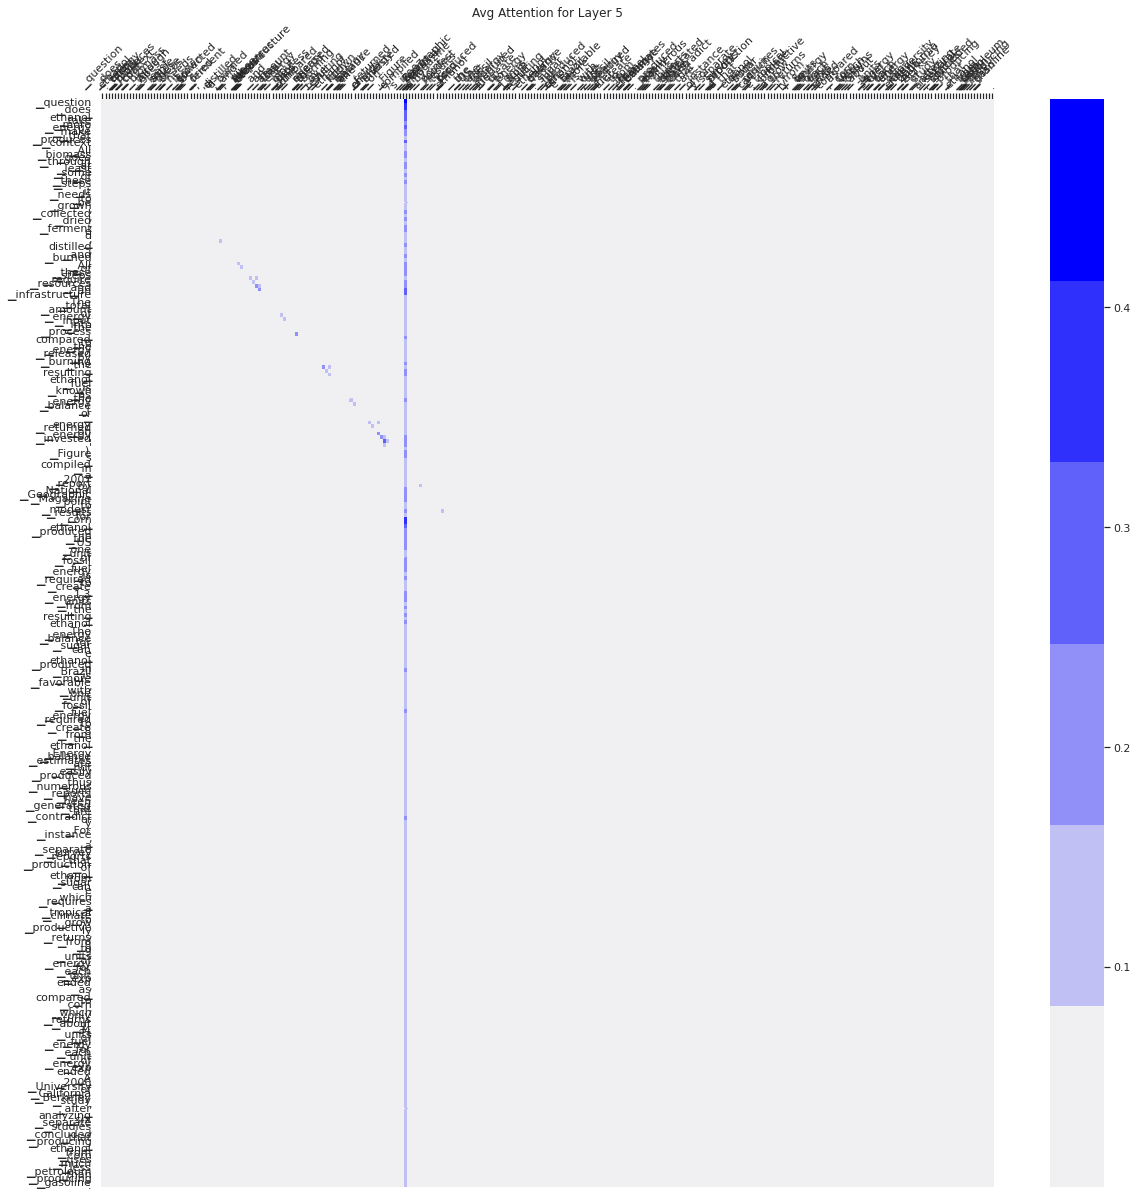

In [47]:
# Aggregation by layer
for lay in range(0, TOTAL_NO_LAYERS):
    plt_attentions(get_attentions(output, layer=lay, avg=True), tokenized_text, title="Avg Attention for Layer {}".format(lay))

# **Translation**

In [48]:
from datasets import load_dataset
import sklearn
from sklearn.model_selection import train_test_split

# loading dataset
bible_dataset = load_dataset("bible_para", lang1="en", lang2="fr", split='train')
bible_dataset_train, bible_dataset_test = train_test_split(bible_dataset, test_size=0.33, random_state=42)

# Creating the inputs/outputs

input = []
output = []
compteur = 0

for element in bible_dataset_test['translation']:
    input.append("translate English to French: " + str(element['en']))
    output.append(element['fr'])
    compteur += 1
    if compteur == 1000:
        break

# T5 model

model = T5ForConditionalGeneration.from_pretrained('t5-small', output_attentions=True)
tok = T5Tokenizer.from_pretrained('t5-small')
tokenized_text = tok.tokenize(input[0])
tokenized_text_ids = tok.convert_tokens_to_ids(tokenized_text)
tok.convert_ids_to_tokens(tokenized_text_ids)

Using custom data configuration en-fr-lang1=en,lang2=fr
Reusing dataset bible_para (/root/.cache/huggingface/datasets/bible_para/en-fr-lang1=en,lang2=fr/0.0.0/b6cc20bcbfb0299beeba1dcc80a8420b975938ca0eef75b3ed30b50df7d950b1)


['▁translate',
 '▁English',
 '▁to',
 '▁French',
 ':',
 '▁I',
 '▁ex',
 'hort',
 '▁the',
 '▁elder',
 's',
 '▁among',
 '▁you',
 ',',
 '▁as',
 '▁',
 'a',
 '▁fellow',
 '▁elder',
 ',',
 '▁and',
 '▁',
 'a',
 '▁witness',
 '▁of',
 '▁the',
 '▁suffering',
 's',
 '▁of',
 '▁Christ',
 ',',
 '▁and',
 '▁who',
 '▁will',
 '▁also',
 '▁share',
 '▁in',
 '▁the',
 '▁glory',
 '▁that',
 '▁will',
 '▁be',
 '▁revealed',
 '.']

In [49]:
#Convert to torch tensor
inp = torch.tensor(tokenized_text_ids)

print("input.shape: ", inp.shape) #torch.Size([15])
inp = inp.unsqueeze(dim=0) #add a dimension 
print("input.shape: ", inp.shape) #torch.Size([15])

#Fwd pass - get output
output = model(input_ids=inp, decoder_input_ids=inp) 
print("len(output): ", len(output))

input.shape:  torch.Size([44])
input.shape:  torch.Size([1, 44])
len(output):  6


In [50]:
model_output = output.logits

In [51]:
print(model_output.shape)

torch.Size([1, 44, 32128])


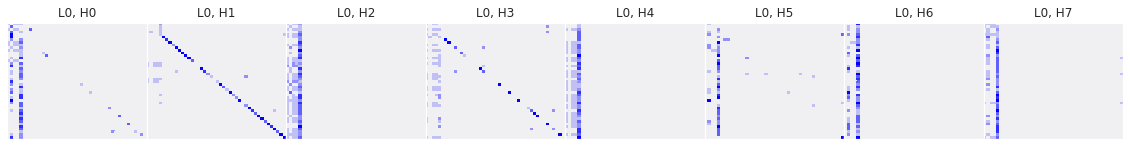

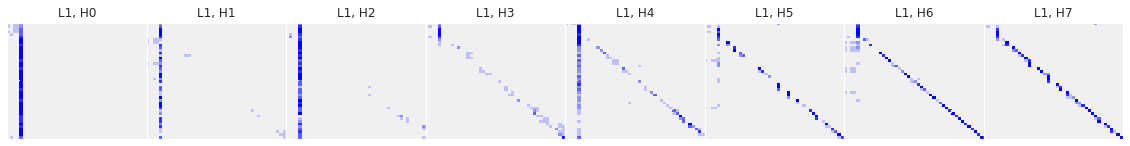

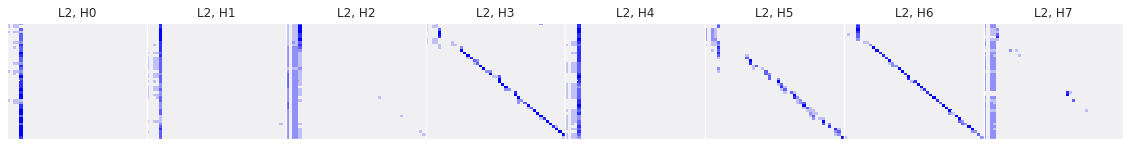

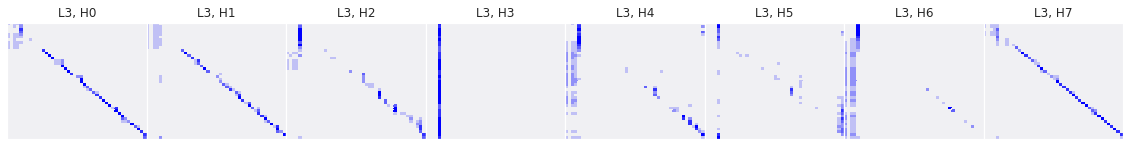

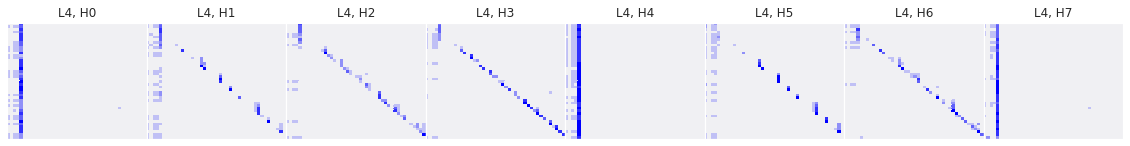

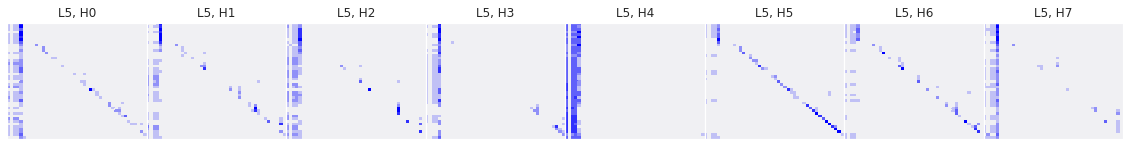

In [52]:
#Plot each attention head inside each layer
for lay in range(0, TOTAL_NO_LAYERS):
    plot_all_attentions(output, layer=lay)

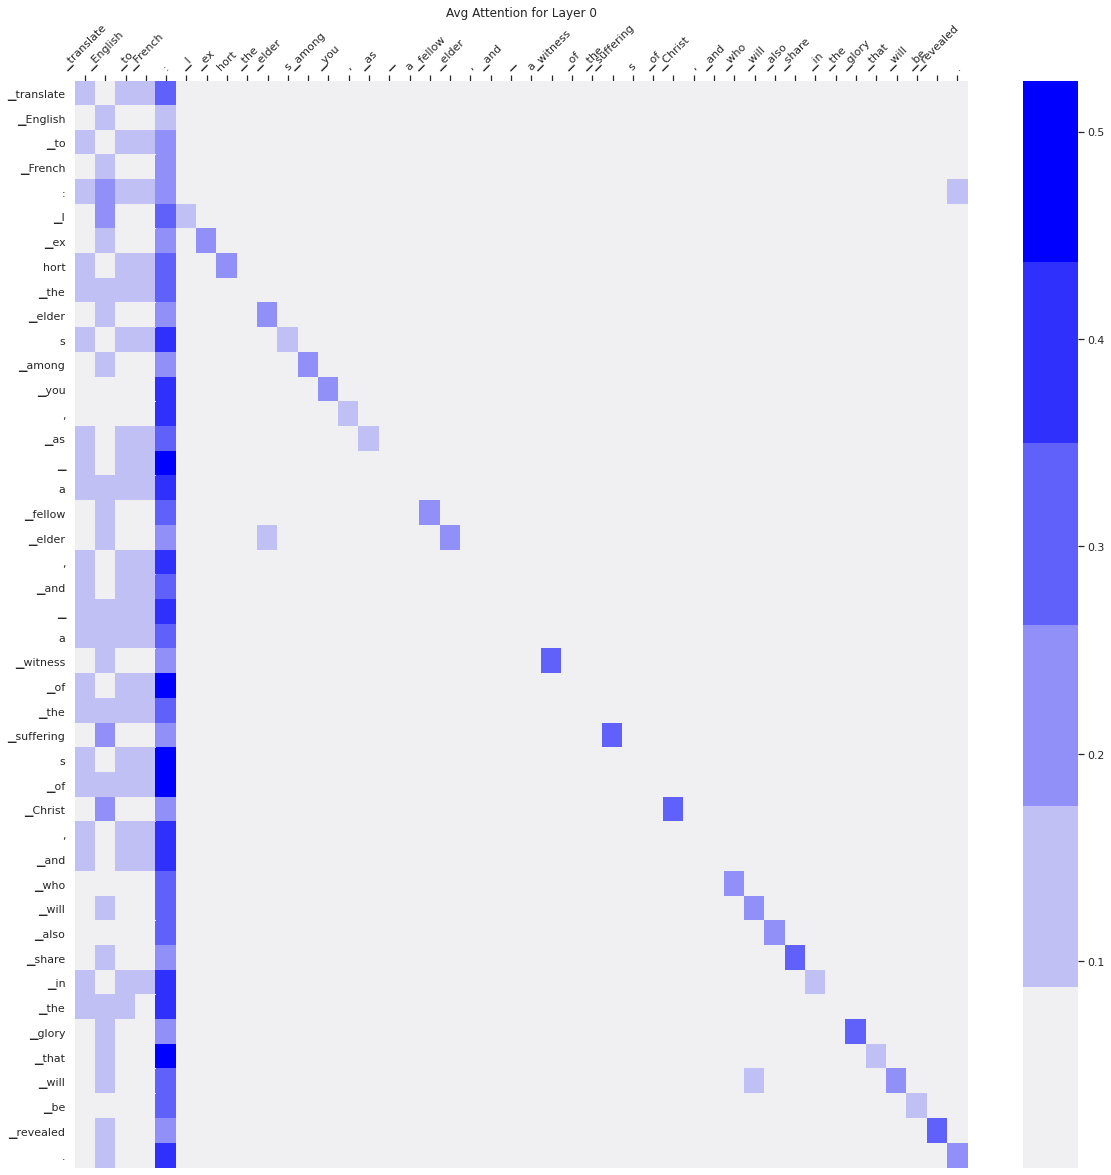

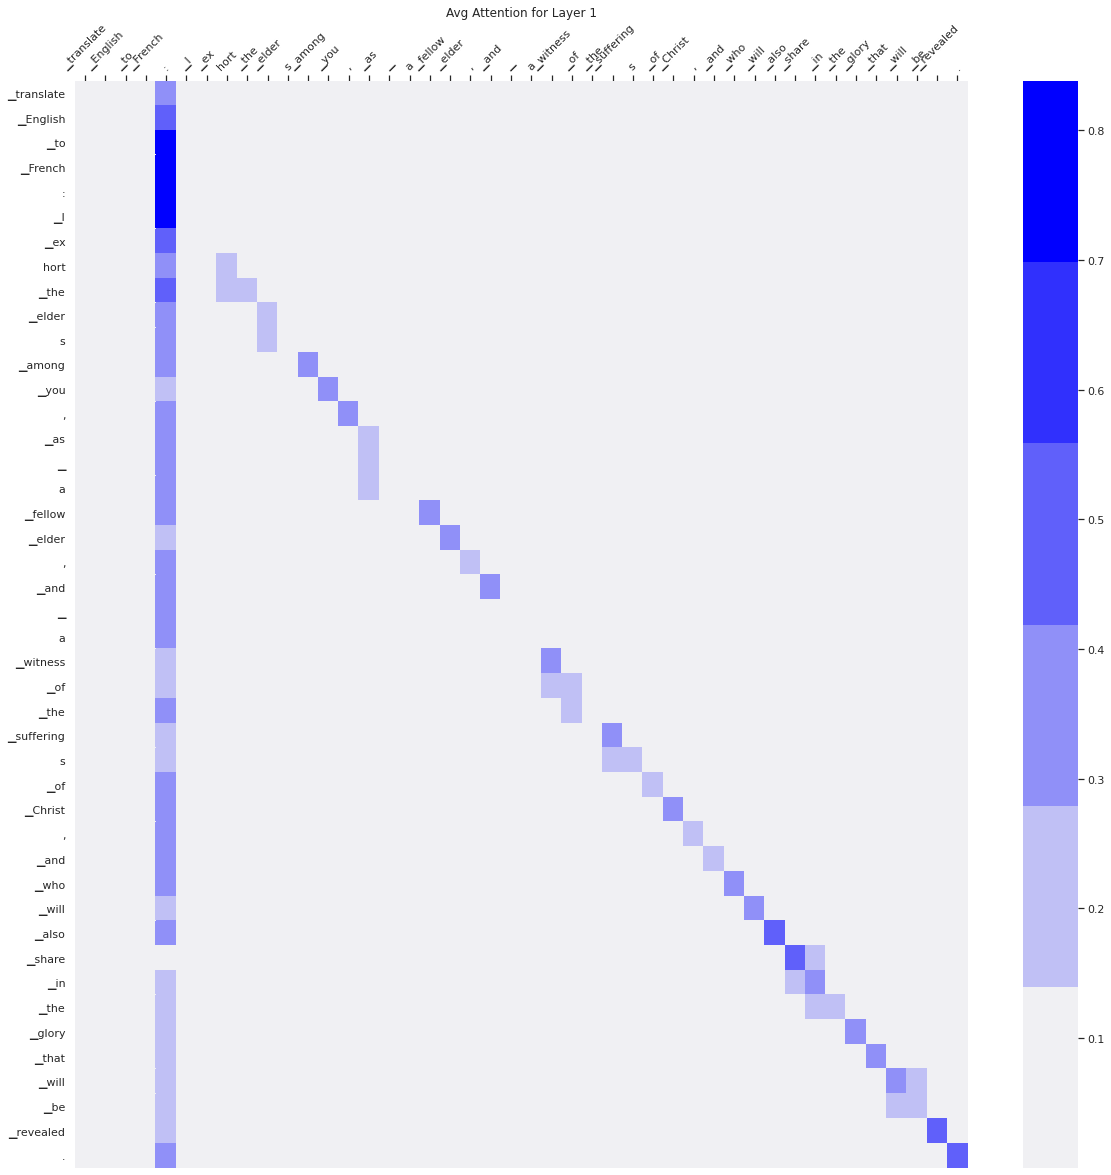

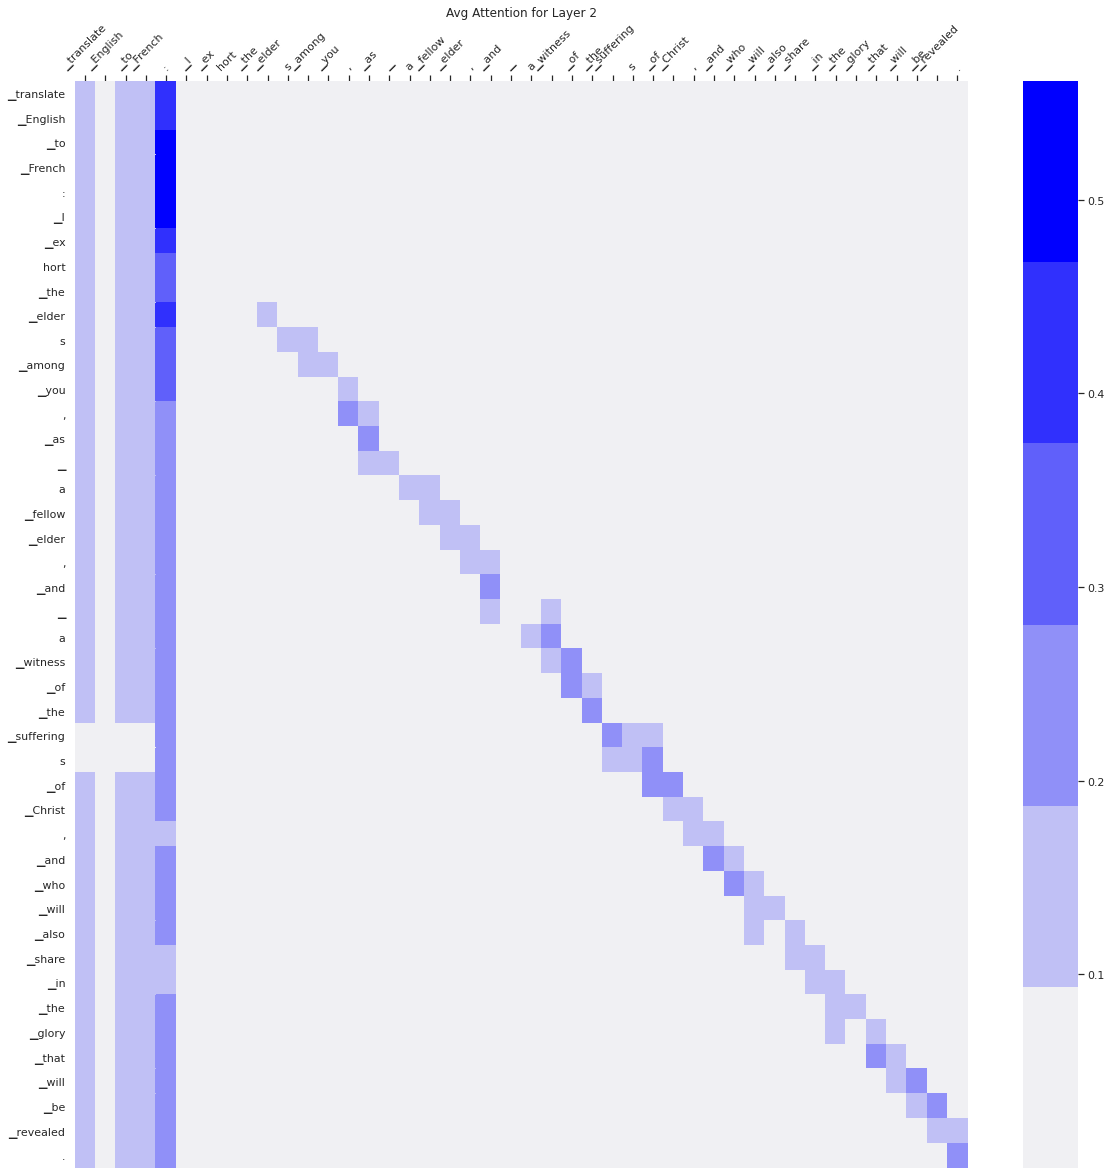

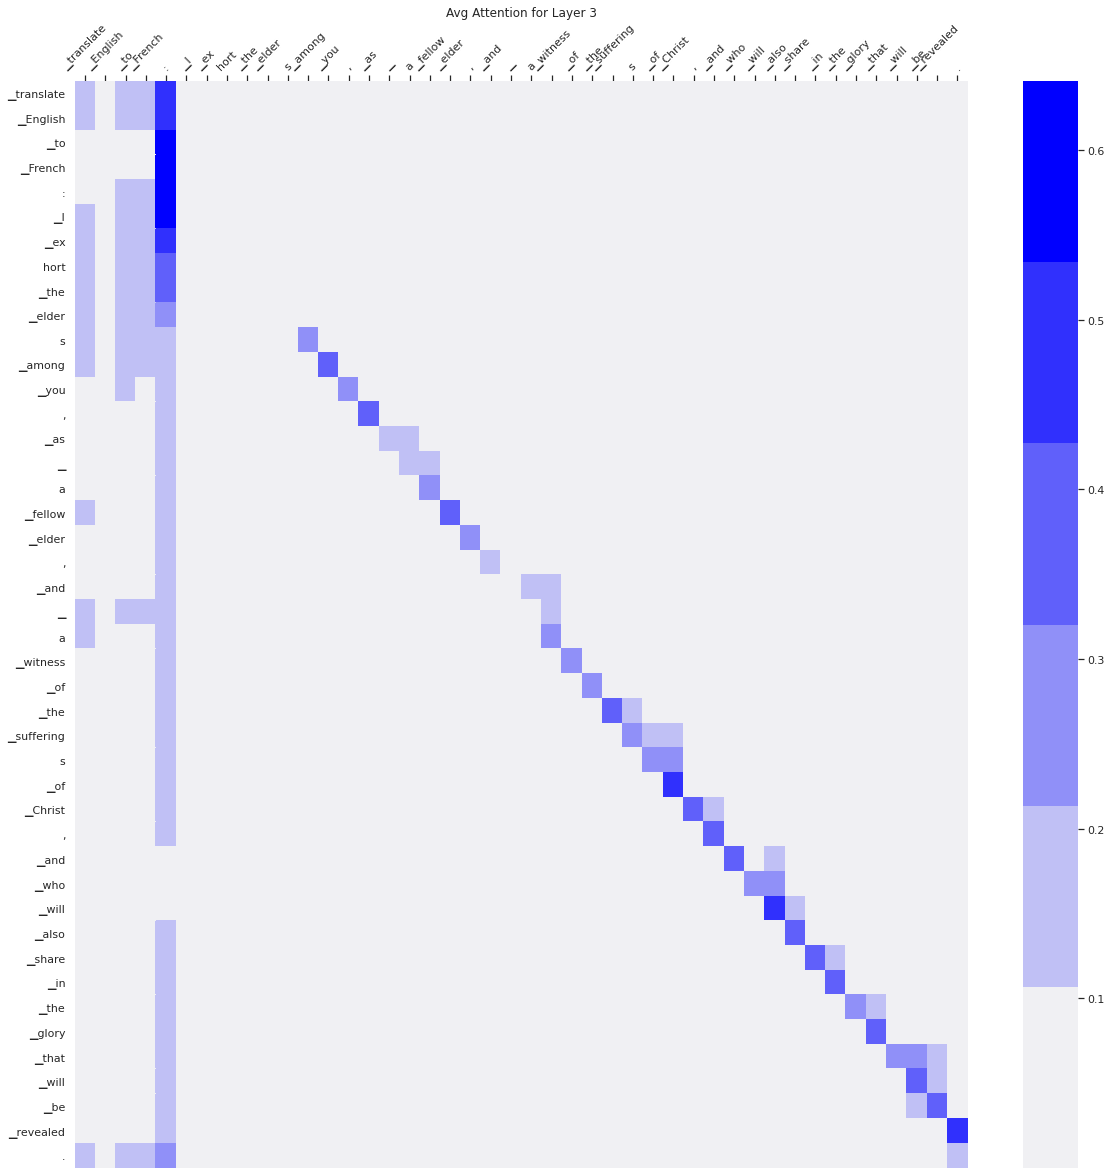

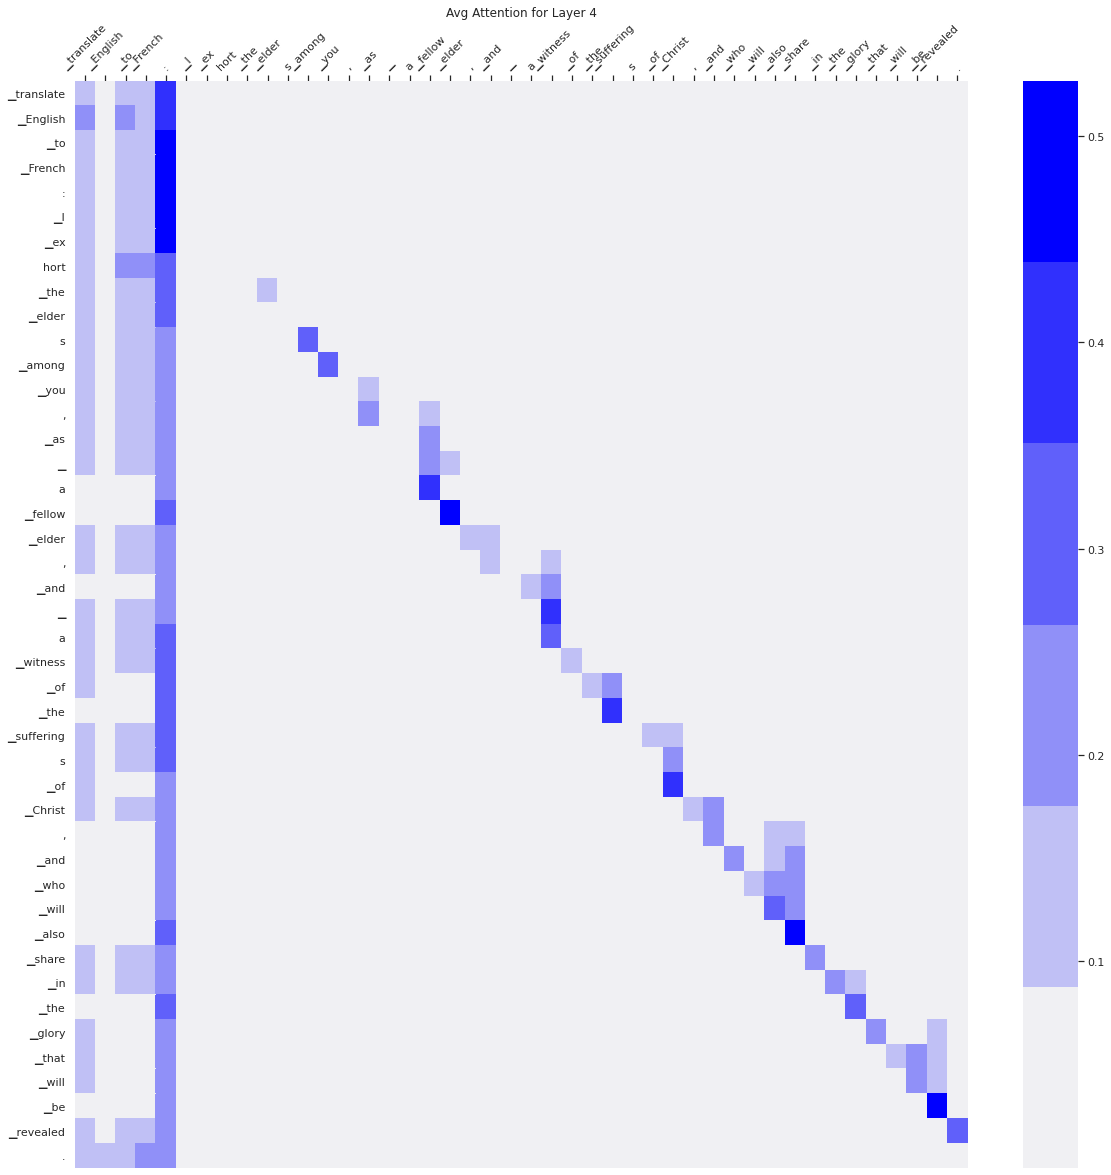

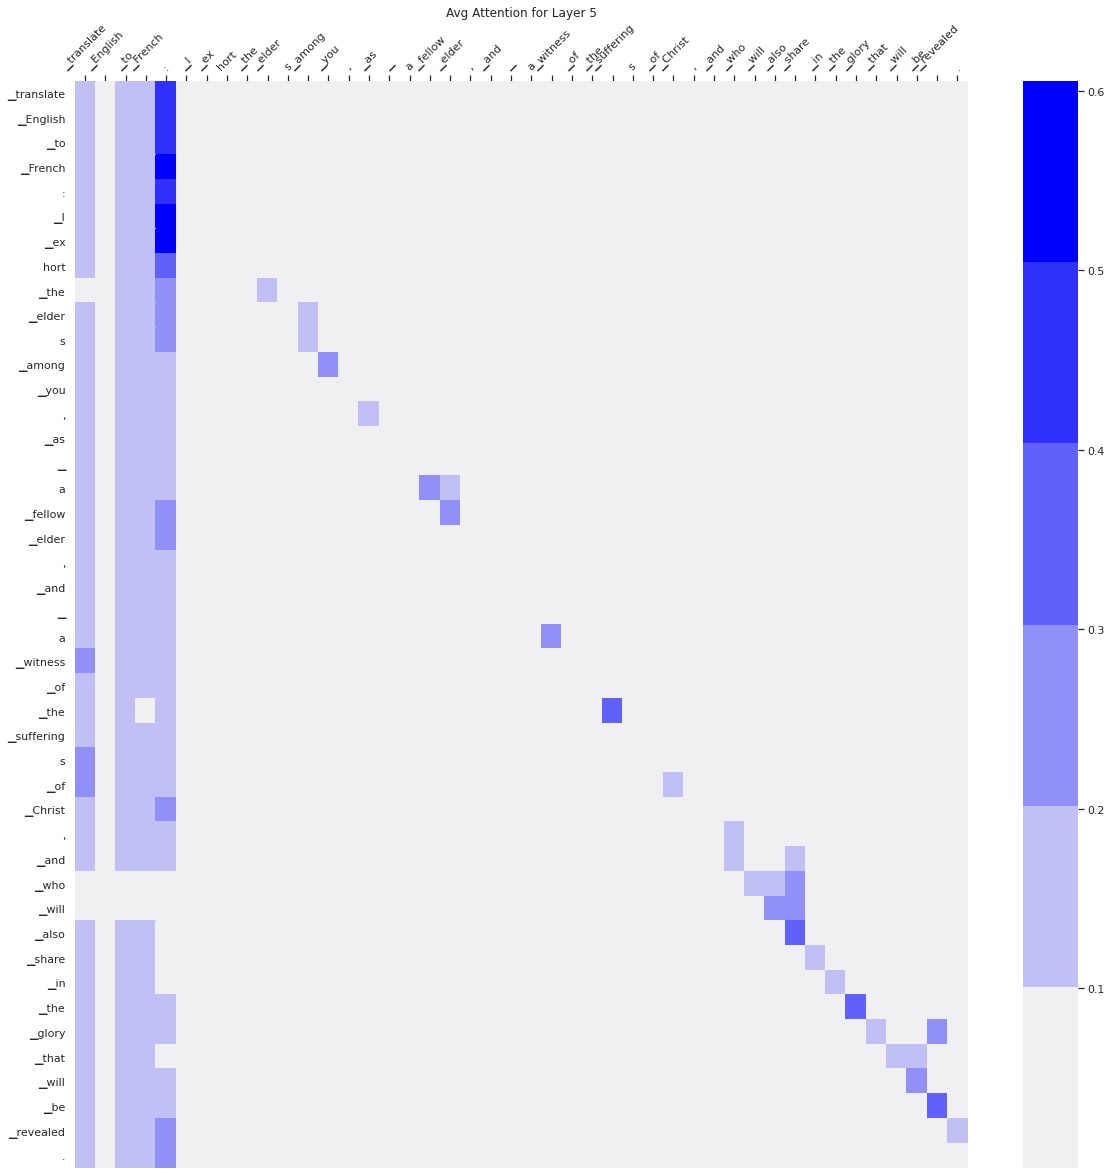

In [53]:
# Aggregation by layer
for lay in range(0, TOTAL_NO_LAYERS):
    plt_attentions(get_attentions(output, layer=lay, avg=True), tokenized_text, title="Avg Attention for Layer {}".format(lay))

# **Summarization**

In [ ]:
# loading dataset
cnn_dailymail_dataset = load_dataset('cnn_dailymail', '3.0.0')
cnn_dailymail_train_dataset = load_dataset('cnn_dailymail', '3.0.0', split='train')
cnn_dailymail_valid_dataset = load_dataset('cnn_dailymail', '3.0.0', split='validation')
cnn_dailymail_test_dataset = load_dataset('cnn_dailymail', '3.0.0', split='test')

input = []
compteur = 0

for element in cnn_dailymail_test_dataset['article']:
    input.append("summarize: " + str(element))
    compteur += 1
    if compteur == 100:
        break

model = T5ForConditionalGeneration.from_pretrained('t5-small', output_attentions=True)
tok = T5Tokenizer.from_pretrained('t5-small')

tokenized_text = tok.tokenize(input[0])
tokenized_text_ids = tok.convert_tokens_to_ids(tokenized_text)
tok.convert_ids_to_tokens(tokenized_text_ids)

In [ ]:
#Convert to torch tensor
inp = torch.tensor(tokenized_text_ids)

print("input.shape: ", inp.shape) #torch.Size([15])
inp = inp.unsqueeze(dim=0) #add a dimension 
print("input.shape: ", inp.shape) #torch.Size([15])

#Fwd pass - get output
output = model(input_ids=inp, decoder_input_ids=inp) 
print("len(output): ", len(output.cross_attentions))

In [ ]:
#Plot each attention head inside each layer
for lay in range(0, TOTAL_NO_LAYERS):
    plot_all_attentions(output, layer=lay)

In [ ]:
# Aggregation by layer
for lay in range(0, TOTAL_NO_LAYERS):
    plt_attentions(get_attentions(output, layer=lay, avg=True), tokenized_text, title="Avg Attention for Layer {}".format(lay))

# **Report**

We see that the heads enable the model to learn multiple attention mechanisms, which operate in parallel. Multi-head attention enables the model to capture a broader range of relationships between words than would be possible with a single attention mechanism.

The multiple layers of attention, each of which operating on the output of the layer that came before, create a repeated composition of word embeddings, that enables the model to form rich representations as it gets to the model's deepest layers.

We identified three types of attention patterns across layers and heads:

* Vertical: Which corresponds to the attention to specific special tokens.

* Horizontal: formed by the attention to previous/following tokens.

* Diagonal: Which is a mix of the above.

The aggregation by the average due to its nature is diagonal.

# **2.2 Implement Attention Matrix Aggregation**

# **QA**

In [54]:
CMAP = sns.light_palette("blue")
% matplotlib inline
np.random.seed(0);
TOTAL_NO_LAYERS = 6
TOTAL_NO_ATTEN_HEADS = 8
# loading dataset
boolq_dataset = load_dataset('boolq')
boolq_train_dataset = load_dataset('boolq', split='train')
boolq_valid_dataset = load_dataset('boolq', split='validation')
#cnn_dailymail_test_dataset = load_dataset('boolq', split='test') doesn't exist

input = []
output = []
compteur = 0

for element_id in range (0, len(boolq_valid_dataset)):

    question = boolq_valid_dataset[element_id]['question']
    answer = boolq_valid_dataset[element_id]['answer']
    passage = boolq_valid_dataset[element_id]['passage']

    input.append('question: ' + question + ' context: ' + passage)

    if answer == 'true':

        output.append('yes')
    else:
        output.append('no')

    compteur += 1

    if compteur == 100:
        break

model = AutoModelForSeq2SeqLM.from_pretrained("mrm8488/t5-small-finetuned-boolq", output_attentions=True)
tok = T5Tokenizer.from_pretrained('t5-small')

Using custom data configuration default
Reusing dataset boolq (/root/.cache/huggingface/datasets/boolq/default/0.1.0/1fcfdc6f36dc89a2245ffbbd5248ab33890594b50396731ebc78411bdd2ca534)
Using custom data configuration default
Reusing dataset boolq (/root/.cache/huggingface/datasets/boolq/default/0.1.0/1fcfdc6f36dc89a2245ffbbd5248ab33890594b50396731ebc78411bdd2ca534)
Using custom data configuration default
Reusing dataset boolq (/root/.cache/huggingface/datasets/boolq/default/0.1.0/1fcfdc6f36dc89a2245ffbbd5248ab33890594b50396731ebc78411bdd2ca534)
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


In [55]:
model = model.to('cuda')
model.eval()
confM = []
with torch.no_grad():
    for lay in range(0, TOTAL_NO_LAYERS):
        confML = []
        for h in range(0, TOTAL_NO_ATTEN_HEADS):
            max = 0
            for i in input:
                tokenized_text = tok.tokenize(i)
                tokenized_text_ids = tok.convert_tokens_to_ids(tokenized_text)
                tok.convert_ids_to_tokens(tokenized_text_ids)

                inp = torch.tensor(tokenized_text_ids)

                inp = inp.unsqueeze(dim=0)
                inp = inp.to('cuda')
                #Fwd pass - get output
                output = model(input_ids=inp, decoder_input_ids=inp)
                max = torch.max(output.cross_attentions[lay].squeeze(0)[h][5:, 5:]) + max #The attention weights of the prefixes are not taken into account
            confML.append(max/len(input))
        confM.append(torch.stack(confML))
confM = torch.stack(confM)

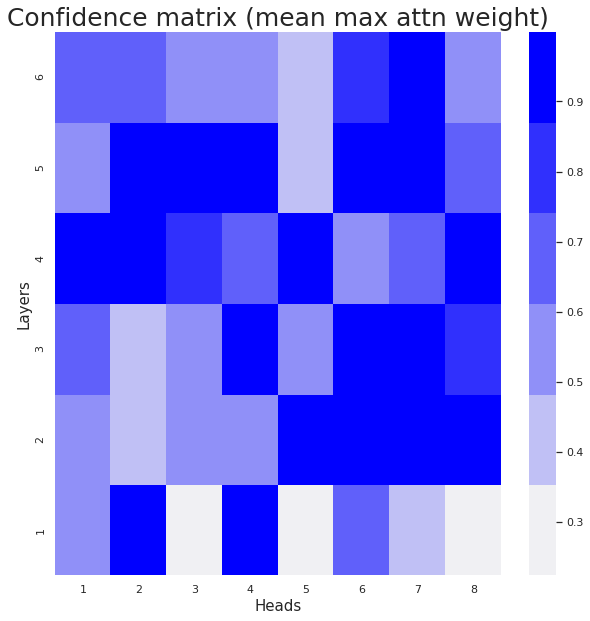

In [56]:
fig, ax = plt.subplots(figsize=(10,10)) 
  # labels = tokenizer.convert_ids_to_tokens(input[0][0:non_zero_idx+1].numpy());
  # ax = sns.heatmap(output[2][0].squeeze(0)[0][0:non_zero_idx+1, 0:non_zero_idx+1].detach().numpy(), annot=True, yticklabels=labs,xticklabels=labs)
ax = sns.heatmap(confM.detach().cpu().clone().numpy(), annot=False, yticklabels=range(1,7),xticklabels=range(1,9), cmap=CMAP)
#ax.xaxis.set_ticks_position('bottom')
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.invert_yaxis()
ax.set_title('Confidence matrix (mean max attn weight)', fontsize = 25)

plt.xlabel('Heads', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Layers', fontsize = 15) # y-axis label with fontsize 15

plt.show()

# **Translation**

In [57]:
# loading dataset
bible_dataset = load_dataset("bible_para", lang1="en", lang2="fr", split='train')
bible_dataset_train, bible_dataset_test = train_test_split(bible_dataset, test_size=0.33, random_state=42)

# Creating the inputs/outputs

input = []
output = []
compteur = 0

for element in bible_dataset_test['translation']:
    input.append("translate English to French: " + str(element['en']))
    output.append(element['fr'])
    compteur += 1
    if compteur == 1000:
        break

# T5 model

model = T5ForConditionalGeneration.from_pretrained('t5-small', output_attentions=True)
tok = T5Tokenizer.from_pretrained('t5-small')

Using custom data configuration en-fr-lang1=en,lang2=fr
Reusing dataset bible_para (/root/.cache/huggingface/datasets/bible_para/en-fr-lang1=en,lang2=fr/0.0.0/b6cc20bcbfb0299beeba1dcc80a8420b975938ca0eef75b3ed30b50df7d950b1)


In [58]:
model = model.to('cuda')
model.eval()
confM = []
with torch.no_grad():
    for lay in range(0, TOTAL_NO_LAYERS):
        confML = []
        for h in range(0, TOTAL_NO_ATTEN_HEADS):
            max = 0
            for i in input:
                tokenized_text = tok.tokenize(i)
                tokenized_text_ids = tok.convert_tokens_to_ids(tokenized_text)
                tok.convert_ids_to_tokens(tokenized_text_ids)

                inp = torch.tensor(tokenized_text_ids)

                inp = inp.unsqueeze(dim=0)
                inp = inp.to('cuda')
                #Fwd pass - get output
                output = model(input_ids=inp, decoder_input_ids=inp)
                max = torch.max(output.cross_attentions[lay].squeeze(0)[h][5:, 5:]) + max #The attention weights of the prefixes are not taken into account
            confML.append(max/len(input))
        confM.append(torch.stack(confML))
confM = torch.stack(confM)

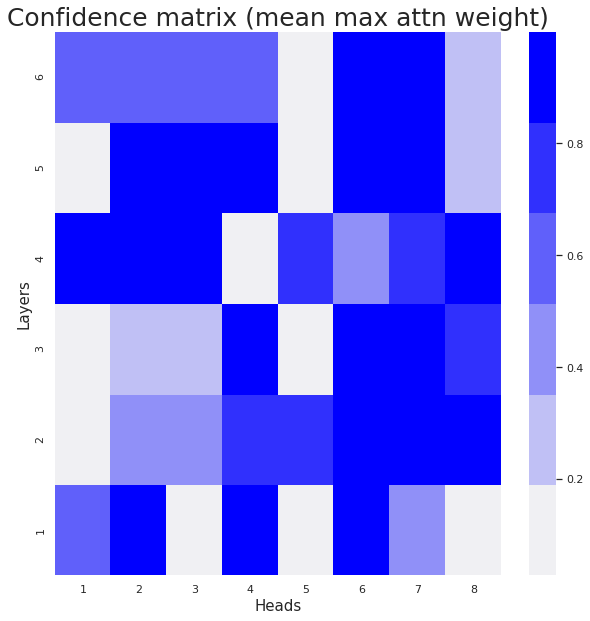

In [59]:
fig, ax = plt.subplots(figsize=(10,10)) 
  # labels = tokenizer.convert_ids_to_tokens(input[0][0:non_zero_idx+1].numpy());
  # ax = sns.heatmap(output[2][0].squeeze(0)[0][0:non_zero_idx+1, 0:non_zero_idx+1].detach().numpy(), annot=True, yticklabels=labs,xticklabels=labs)
ax = sns.heatmap(confM.detach().cpu().clone().numpy(), annot=False, yticklabels=range(1,7),xticklabels=range(1,9), cmap=CMAP)
#ax.xaxis.set_ticks_position('bottom')
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.invert_yaxis()
ax.set_title('Confidence matrix (mean max attn weight)', fontsize = 25)

plt.xlabel('Heads', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Layers', fontsize = 15) # y-axis label with fontsize 15

plt.show()

# **Summarization**

In [ ]:
# loading dataset
cnn_dailymail_dataset = load_dataset('cnn_dailymail', '3.0.0')
cnn_dailymail_train_dataset = load_dataset('cnn_dailymail', '3.0.0', split='train')
cnn_dailymail_valid_dataset = load_dataset('cnn_dailymail', '3.0.0', split='validation')
cnn_dailymail_test_dataset = load_dataset('cnn_dailymail', '3.0.0', split='test')

input = []
compteur = 0

for element in cnn_dailymail_test_dataset['article']:
    input.append("summarize: " + str(element))
    compteur += 1
    if compteur == 100:
        break

model = T5ForConditionalGeneration.from_pretrained('t5-small', output_attentions=True)
tok = T5Tokenizer.from_pretrained('t5-small')

In [ ]:
model = model.to('cuda')
model.eval()
confM = []
with torch.no_grad():
    for lay in range(0, TOTAL_NO_LAYERS):
        confML = []
        for h in range(0, TOTAL_NO_ATTEN_HEADS):
            max = 0
            for i in input:
                tokenized_text = tok.tokenize(i)
                tokenized_text_ids = tok.convert_tokens_to_ids(tokenized_text)
                tok.convert_ids_to_tokens(tokenized_text_ids)

                inp = torch.tensor(tokenized_text_ids)

                inp = inp.unsqueeze(dim=0)
                inp = inp.to('cuda')
                #Fwd pass - get output
                output = model(input_ids=inp, decoder_input_ids=inp)
                max = torch.max(output.cross_attentions[lay].squeeze(0)[h][2:, 2:]) + max #The attention weights of the prefixes are not taken into account
            confML.append(max/len(input))
        confM.append(torch.stack(confML))
confM = torch.stack(confM)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10)) 
  # labels = tokenizer.convert_ids_to_tokens(input[0][0:non_zero_idx+1].numpy());
  # ax = sns.heatmap(output[2][0].squeeze(0)[0][0:non_zero_idx+1, 0:non_zero_idx+1].detach().numpy(), annot=True, yticklabels=labs,xticklabels=labs)
ax = sns.heatmap(confM.detach().cpu().clone().numpy(), annot=False, yticklabels=range(1,7),xticklabels=range(1,9), cmap=CMAP)
#ax.xaxis.set_ticks_position('bottom')
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.invert_yaxis()
ax.set_title('Confidence matrix (mean max attn weight)', fontsize = 25)

plt.xlabel('Heads', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Layers', fontsize = 15) # y-axis label with fontsize 15

plt.show()

# **Report**

We see that the model, across the different layers and heads, for all the tasks, is generally quite over-confident, which is predictable since it is not finetuned to the tasks at hand. Nevertheless, we see that layers and heads have different confidence scores, which goes hand in hand with our previous conclusions, demonstrating that multiple attention mechanisms and word representation are learned.

# Bonus 1. Task 1

## **Translation**

### **bible_para**

In [60]:
from datasets import load_dataset
import sklearn
from sklearn.model_selection import train_test_split

# loading dataset
bible_dataset = load_dataset("bible_para", lang1="en", lang2="fr", split='train')
bible_dataset_train, bible_dataset_test = train_test_split(bible_dataset, test_size=0.33, random_state=42)

Using custom data configuration en-fr-lang1=en,lang2=fr
Reusing dataset bible_para (/root/.cache/huggingface/datasets/bible_para/en-fr-lang1=en,lang2=fr/0.0.0/b6cc20bcbfb0299beeba1dcc80a8420b975938ca0eef75b3ed30b50df7d950b1)


In [61]:
# Creating the inputs/outputs

input = []
output = []
compteur = 0

for element in bible_dataset_test['translation']:
    input.append(element['en'])
    output.append(element['fr'])
    compteur += 1
    if compteur == 250:
        break

input[:3]

['I exhort the elders among you, as a fellow elder, and a witness of the sufferings of Christ, and who will also share in the glory that will be revealed.',
 'To the more you shall give the more inheritance, and to the fewer you shall give the less inheritance: to everyone according to those who were numbered of him shall his inheritance be given.',
 "don't harden your hearts, as in the rebellion, like as in the day of the trial in the wilderness,"]

In [62]:
# Loading a pre-trained model specific for translation
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
  
#model = AutoModelForSeq2SeqLM.from_pretrained("mrm8488/mbart-large-finetuned-bible-es-en-translation")
#tok = AutoTokenizer.from_pretrained("mrm8488/mbart-large-finetuned-bible-es-en-translation")

model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-fr")
tok = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-fr")

#model = AutoModelForSeq2SeqLM.from_pretrained("mrm8488/t5-small-finetuned-translation-es-to-pt")
#tok = AutoTokenizer.from_pretrained("mrm8488/t5-small-finetuned-translation-es-to-pt")

input_encodings = tok.batch_encode_plus(input, padding=True, max_length=512, truncation=True, return_tensors="pt")
target_encodings = tok.batch_encode_plus(output, padding=True, max_length=512, truncation=True, return_tensors="pt")

model.to("cuda")
input_encodings.to("cuda")

model_output = model.generate(input_encodings["input_ids"], max_length = 512)

In [63]:
## converting model output into text (this is called tokenizer "decoding") (not to confuse with decoding algorithms like sampling and beam search these have the function model.generate)

model_output_decoded = tok.batch_decode(model_output, skip_special_tokens=True)

compteur = 0

for s,t,g in zip(input, output, model_output_decoded):
    print("source:\t {}\ntarget:\t{}\ngenerated\t{}".format(s[0:1000],t,g))
    print("\n#######################\n")
    compteur += 1
    if compteur == 10:
        break

source:	 I exhort the elders among you, as a fellow elder, and a witness of the sufferings of Christ, and who will also share in the glory that will be revealed.
target:	Voici les exhortations que j`adresse aux anciens qui sont parmi vous, moi ancien comme eux, témoin des souffrances de Christ, et participant de la gloire qui doit être manifestée:
generated	J'exhorte les anciens parmi vous, en tant qu'aînés, et témoin des souffrances du Christ, et qui participeront aussi à la gloire qui sera révélée.

#######################

source:	 To the more you shall give the more inheritance, and to the fewer you shall give the less inheritance: to everyone according to those who were numbered of him shall his inheritance be given.
target:	A ceux qui sont en plus grand nombre tu donneras une portion plus grande, et à ceux qui sont en plus petit nombre tu donneras une portion plus petite; on donnera à chacun sa portion d`après le dénombrement.
generated	Plus tu donneras d'héritage, et moins tu do

#### Let's appreciate these results regarding an appropriate metric : BLEU score

What is the BLEU metric ? BLEU, or the Bilingual Evaluation Understudy, is a score for comparing a candidate translation of text to one or more reference translations. A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0. One problem with BLEU scores is that they tend to favor short translations, which can produce very high precision scores, even using modified precision. The approach works by counting matching n-grams in the candidate translation to n-grams in the reference text, where 1-gram or unigram would be each token and a bigram comparison would be each word pair. The comparison is made regardless of word order.

Here is the BLEU score by sentence

In [64]:
from nltk.translate.bleu_score import sentence_bleu

compteur = 0

for s,t,g in zip(input, output, model_output_decoded):

    print("source:\t {}\ntarget:\t{}\ngenerated\t{}".format(s[0:1000],t,g))

    reference = t
    candidate = g
    score = sentence_bleu(reference, candidate)
    print("score: ", score)
    print("\n##################################\n")

    compteur += 1

    if compteur == 5:
        break

source:	 I exhort the elders among you, as a fellow elder, and a witness of the sufferings of Christ, and who will also share in the glory that will be revealed.
target:	Voici les exhortations que j`adresse aux anciens qui sont parmi vous, moi ancien comme eux, témoin des souffrances de Christ, et participant de la gloire qui doit être manifestée:
generated	J'exhorte les anciens parmi vous, en tant qu'aînés, et témoin des souffrances du Christ, et qui participeront aussi à la gloire qui sera révélée.
score:  0.6378386176553488

##################################

source:	 To the more you shall give the more inheritance, and to the fewer you shall give the less inheritance: to everyone according to those who were numbered of him shall his inheritance be given.
target:	A ceux qui sont en plus grand nombre tu donneras une portion plus grande, et à ceux qui sont en plus petit nombre tu donneras une portion plus petite; on donnera à chacun sa portion d`après le dénombrement.
generated	Plus 

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Here is the BLEU score of the corpus

In [65]:
import bert_score
import sacrebleu
import pandas as pd 

percision,recall,fscore = bert_score.score(cands=model_output_decoded, refs=output, lang="fr")
bleu = sacrebleu.corpus_bleu(model_output_decoded, [output]).score


df = pd.DataFrame({
    "BLEU":bleu,
    "BERTSCORE-percision": [float(percision.mean())],
    "BERTSCORE-recall": [float(recall.mean())],
    "BERTSCORE-fscore": [float(fscore.mean())]
    })

df

BLEU  BERTSCORE-percision  BERTSCORE-recall  BERTSCORE-fscore
0  33.58977              0.86229          0.855494          0.858662

### **ted_talks_iwslt**

Importation of the dataset and splits.

In [66]:
from datasets import load_dataset
import sklearn
from sklearn.model_selection import train_test_split

ted_dataset = load_dataset("ted_talks_iwslt", language_pair=("en", "fr"), year="2016", split = 'train')
ted_dataset_train, ted_dataset_test = train_test_split(ted_dataset, test_size=0.33, random_state=42)

Using custom data configuration en_fr_2016-3e2ac5b7c2b72376
Reusing dataset ted_talks_iwslt (/root/.cache/huggingface/datasets/ted_talks_iwslt/en_fr_2016-3e2ac5b7c2b72376/1.1.0/caf519a0a183db297ca5f39dbfd42de3a415aaa79b5a638edd4fd7a3e3b0e545)


Inputs and outputs of the model.

In [67]:
# Creating the inputs/outputs

input = []
output = []
compteur = 0

for element in ted_dataset_test['translation']:
    input.append(element['en'])
    output.append(element['fr'])
    compteur += 1
    if compteur == 150:
        break

input[:3]

['Avi Reichental: What’s next in 3D printing',
 'Dr. Seyi Oyesola takes a searing look at health care in underdeveloped countries. His photo tour of a Nigerian teaching hospital -- all low-tech hacks and donated supplies -- drives home the challenge of doing basic health care there.',
 'Nature’s beauty can be fleeting -- but not through Louie Schwartzberg’s lens. His stunning time-lapse photography, accompanied by powerful words from Benedictine monk Brother David Steindl-Rast, serves as a meditation on being grateful for every day.']

Definition of the model.

In [68]:
# Loading a pre-trained model specific for translation
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-fr")
tok = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-fr")

input_encodings = tok.batch_encode_plus(input, padding=True, max_length=512, truncation=True, return_tensors="pt")
target_encodings = tok.batch_encode_plus(output, padding=True, max_length=512, truncation=True, return_tensors="pt")

model.to("cuda")
input_encodings.to("cuda")

model_output = model.generate(input_encodings["input_ids"], max_length = 512)

Let's print some results !

In [69]:
## converting model output into text (this is called tokenizer "decoding") (not to confuse with decoding algorithms like sampling and beam search these have the function model.generate)

model_output_decoded = tok.batch_decode(model_output, skip_special_tokens=True)

compteur = 0

for s,t,g in zip(input, output, model_output_decoded):
    print("source:\t {}\ntarget:\t{}\ngenerated\t{}".format(s[0:1000],t,g))
    print("\n#######################\n")
    compteur += 1
    if compteur == 10:
        break

source:	 Avi Reichental: What’s next in 3D printing
target:	Avi Reichental: L'avenir de l'impression 3D
generated	Avi Reichental: Quoi de neuf en impression 3D

#######################

source:	 Dr. Seyi Oyesola takes a searing look at health care in underdeveloped countries. His photo tour of a Nigerian teaching hospital -- all low-tech hacks and donated supplies -- drives home the challenge of doing basic health care there.
target:	Le docteur Seyi Oyesola nous donne une perspective incisive sur les services de santé dans les pays sous-développés. Son tour photographique d'un centre hospitalo-universitaire - concernant des solutions rudimentaires et des divers dons - met l'accent sur les défis en donnant aux nigérians les services de santé élémentaires.
generated	Le Dr Seyi Oyesola se penche sur les soins de santé dans les pays sous-développés. Sa visite en photo d'un hôpital d'enseignement nigérian - tous les hacks de faible technologie et les dons de fournitures - nous amène à relev

#### Let's appreciate the results regarding the BLEU metric.

In [70]:
from nltk.translate.bleu_score import sentence_bleu

compteur = 0

for s,t,g in zip(input, output, model_output_decoded):

    print("source:\t {}\ntarget:\t{}\ngenerated\t{}".format(s[0:1000],t,g))

    reference = t
    candidate = g
    score = sentence_bleu(reference, candidate)
    print("score: ", score)
    print("\n##################################\n")

    compteur += 1

    if compteur == 5:
        break

source:	 Avi Reichental: What’s next in 3D printing
target:	Avi Reichental: L'avenir de l'impression 3D
generated	Avi Reichental: Quoi de neuf en impression 3D
score:  0.8265168183793802

##################################

source:	 Dr. Seyi Oyesola takes a searing look at health care in underdeveloped countries. His photo tour of a Nigerian teaching hospital -- all low-tech hacks and donated supplies -- drives home the challenge of doing basic health care there.
target:	Le docteur Seyi Oyesola nous donne une perspective incisive sur les services de santé dans les pays sous-développés. Son tour photographique d'un centre hospitalo-universitaire - concernant des solutions rudimentaires et des divers dons - met l'accent sur les défis en donnant aux nigérians les services de santé élémentaires.
generated	Le Dr Seyi Oyesola se penche sur les soins de santé dans les pays sous-développés. Sa visite en photo d'un hôpital d'enseignement nigérian - tous les hacks de faible technologie et les do

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


score:  0.6048358922135949

##################################

source:	 Peter Haas: Haiti's disaster of engineering
target:	Peter Haas : Haïti, désastre de l' ingénierie
generated	Peter Haas : La catastrophe de l'ingénierie en Haïti
score:  0.7561559858236034

##################################

source:	 Rob Knight is a pioneer in studying human microbes, the community of tiny single-cell organisms living inside our bodies that have a huge — and largely unexplored — role in our health. “The three pounds of microbes that you carry around with you might be more important than every single gene you carry around in your genome,” he says. Find out why.
target:	Rob Knight est un pionnier dans l’étude de microbes humains, la communauté d'organismes unicellulaires minuscules qui vivent dans notre corps et ont un grand rôle, mais peu exploré, pour notre santé. « 1,5 kg de microbes que nous avons dans et sur notre corps seraient plus importants que chaque gène que nous possédons dans notre géno

In [71]:
import bert_score
import sacrebleu
import pandas as pd 

percision,recall,fscore = bert_score.score(cands=model_output_decoded, refs=output, lang="en")
bleu = sacrebleu.corpus_bleu(model_output_decoded, [output]).score


df = pd.DataFrame({
    "BLEU":bleu,
    "BERTSCORE-percision": [float(percision.mean())],
    "BERTSCORE-recall": [float(recall.mean())],
    "BERTSCORE-fscore": [float(fscore.mean())]
    })

df

BLEU  BERTSCORE-percision  BERTSCORE-recall  BERTSCORE-fscore
0  32.648588             0.926343           0.91938          0.922711

## **Summarization** with cnn-dailymail dataset

Importation of the dataset and split.

In [ ]:
from datasets import load_dataset

# loading dataset
cnn_dailymail_dataset = load_dataset('cnn_dailymail', '3.0.0')
cnn_dailymail_train_dataset = load_dataset('cnn_dailymail', '3.0.0', split='train')
cnn_dailymail_valid_dataset = load_dataset('cnn_dailymail', '3.0.0', split='validation')
cnn_dailymail_test_dataset = load_dataset('cnn_dailymail', '3.0.0', split='test')

Creation of the inputs and outputs for the model.

In [ ]:
input = []
compteur = 0

for element in cnn_dailymail_test_dataset['article']:
    input.append(element)
    compteur += 1
    if compteur == 50:
        break

input[:3]

Definition of the model.

In [ ]:
#Using a fine-tuned model for Summarization
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
  
model = AutoModelForSeq2SeqLM.from_pretrained("mrm8488/t5-base-finetuned-summarize-news")
tok = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-summarize-news")

input_encodings = tok.batch_encode_plus(input, padding=True, max_length=512, truncation=True, return_tensors="pt")

model.to("cuda")
input_encodings.to("cuda")

model_output = model.generate(input_encodings["input_ids"], max_length = 512)

Let's print some results !

In [ ]:
model_output_decoded = tok.batch_decode(model_output, skip_special_tokens=True)

compteur = 0

for s,g in zip(input, model_output_decoded):

    print("source:\t {}\ngenerated\t{}\n------\n".format(s[0:1000],g))
    print("\n#######################\n")
    compteur += 1

    if compteur == 10:
        break

### Let's appreciate these results regarding an appropriate metric : ROUGE-2 score

ROUGE stands for Recall-Oriented Understudy for Gisting Evaluation. It is essentially a set of metrics for evaluating automatic summarization of texts as well as machine translations.

It works by comparing an automatically produced summary or translation against a set of reference summaries (typically human-produced). ROUGE-N — measures unigram, bigram, trigram and higher order n-gram overlap

In [ ]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge2'], use_stemmer=True)
compteur = 0

for s,g in zip(input, model_output_decoded):
  
    print("source:\t {}\ngenerated\t{}\n".format(s[0:1000],g))
    scores = scorer.score(s,g)
    print(scores)
    print("\n##################################\n")

    compteur += 1

    if compteur == 10:
        break

Global Rouge score :

In [ ]:
from rouge_metric import PyRouge

#rouge = PerlRouge(rouge_n_max=3, rouge_l=True, rouge_w=True,
#                 rouge_w_weight=1.2, rouge_s=True, rouge_su=True, skip_gap=4)

hypotheses = [i for i in input]
references = [[g] for g in model_output_decoded]

# Evaluate document-wise ROUGE scores
rouge = PyRouge(rouge_n=(1, 2, 4), rouge_l=True, rouge_w=True,
                rouge_w_weight=1.2, rouge_s=True, rouge_su=True, skip_gap=4)
scores = rouge.evaluate(hypotheses, references)


scores

Let's print the results with only the rouge-2.

In [ ]:
import bert_score
import sacrebleu
import pandas as pd 

percision,recall,fscore = bert_score.score(cands=model_output_decoded, refs=input, lang="en")


df = pd.DataFrame({
    "ROUGESCORE-precision":scores['rouge-2']['p'],
    "ROUGESCORE-recall":scores['rouge-2']['r'],
    "ROUGESCORE-fscore":scores['rouge-2']['f'],
    "BERTSCORE-precision": [float(percision.mean())],
    "BERTSCORE-recall": [float(recall.mean())],
    "BERTSCORE-fscore": [float(fscore.mean())]
    })

df

## **Question answering** with boolq dataset

Importation of the dataset and splits.

In [72]:
from datasets import load_dataset

# loading dataset
boolq_dataset = load_dataset('boolq')
boolq_train_dataset = load_dataset('boolq', split='train')
boolq_valid_dataset = load_dataset('boolq', split='validation')

Using custom data configuration default
Reusing dataset boolq (/root/.cache/huggingface/datasets/boolq/default/0.1.0/1fcfdc6f36dc89a2245ffbbd5248ab33890594b50396731ebc78411bdd2ca534)
Using custom data configuration default
Reusing dataset boolq (/root/.cache/huggingface/datasets/boolq/default/0.1.0/1fcfdc6f36dc89a2245ffbbd5248ab33890594b50396731ebc78411bdd2ca534)
Using custom data configuration default
Reusing dataset boolq (/root/.cache/huggingface/datasets/boolq/default/0.1.0/1fcfdc6f36dc89a2245ffbbd5248ab33890594b50396731ebc78411bdd2ca534)


Creating the inputs and outputs for the model.

In [73]:
input = []
output = []
compteur = 0

for element_id in range (0, len(boolq_valid_dataset)):

    question = boolq_valid_dataset[element_id]['question']
    answer = boolq_valid_dataset[element_id]['answer']
    passage = boolq_valid_dataset[element_id]['passage']

    input.append('question: ' + question + ' context: ' + passage)

    if answer == 'true':

        output.append('yes')
    else:
        output.append('no')

    compteur += 1

    if compteur == 100:
        break

input[:3]

["question: does ethanol take more energy make that produces context: All biomass goes through at least some of these steps: it needs to be grown, collected, dried, fermented, distilled, and burned. All of these steps require resources and an infrastructure. The total amount of energy input into the process compared to the energy released by burning the resulting ethanol fuel is known as the energy balance (or ``energy returned on energy invested''). Figures compiled in a 2007 report by National Geographic Magazine point to modest results for corn ethanol produced in the US: one unit of fossil-fuel energy is required to create 1.3 energy units from the resulting ethanol. The energy balance for sugarcane ethanol produced in Brazil is more favorable, with one unit of fossil-fuel energy required to create 8 from the ethanol. Energy balance estimates are not easily produced, thus numerous such reports have been generated that are contradictory. For instance, a separate survey reports that 

In [74]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

#Using a fine-tuned model and tokenizer for Question Answering on boolq
model = AutoModelForSeq2SeqLM.from_pretrained("mrm8488/t5-base-finetuned-boolq")
tok = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-boolq")

input_encodings = tok.batch_encode_plus(input, padding=True, max_length=512, truncation=True, return_tensors="pt")
target_encodings = tok.batch_encode_plus(output, padding=True, max_length=512, truncation=True, return_tensors="pt")

model.to("cuda")
input_encodings.to("cuda")

model_output = model.generate(input_encodings["input_ids"], max_length = 512)

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


Let's print some results !

In [75]:
compteur = 0

model_output_decoded = tok.batch_decode(model_output, skip_special_tokens=True)

for s,t, g in zip(input, output, model_output_decoded):

    print("source:\t {}\ntarget\t{}\ngenerated\t{}\n------\n".format(s[0:1000],t,g))
    print("\n#######################\n")

    compteur += 1

    if compteur == 10:
        break

source:	 question: does ethanol take more energy make that produces context: All biomass goes through at least some of these steps: it needs to be grown, collected, dried, fermented, distilled, and burned. All of these steps require resources and an infrastructure. The total amount of energy input into the process compared to the energy released by burning the resulting ethanol fuel is known as the energy balance (or ``energy returned on energy invested''). Figures compiled in a 2007 report by National Geographic Magazine point to modest results for corn ethanol produced in the US: one unit of fossil-fuel energy is required to create 1.3 energy units from the resulting ethanol. The energy balance for sugarcane ethanol produced in Brazil is more favorable, with one unit of fossil-fuel energy required to create 8 from the ethanol. Energy balance estimates are not easily produced, thus numerous such reports have been generated that are contradictory. For instance, a separate survey report

### Let's appreciate these results regarding an appropriate metric : exact match and macro-F1

Exact match. This metric measures the percentage of predictions that match any one of the ground
truth answers exactly

In [76]:
def compute_exact_match(prediction, truth):
    return int((prediction) == (truth))

In [77]:
compteur = 0

for s,t, g in zip(input, output, model_output_decoded):
    print("source:\t {}\ntarget\t{}\ngenerated\t{}".format(s[0:1000],t,g))
    print('score: ', compute_exact_match(g, t))
    print("\n######################\n")
    compteur += 1

    if compteur == 10:
        break

source:	 question: does ethanol take more energy make that produces context: All biomass goes through at least some of these steps: it needs to be grown, collected, dried, fermented, distilled, and burned. All of these steps require resources and an infrastructure. The total amount of energy input into the process compared to the energy released by burning the resulting ethanol fuel is known as the energy balance (or ``energy returned on energy invested''). Figures compiled in a 2007 report by National Geographic Magazine point to modest results for corn ethanol produced in the US: one unit of fossil-fuel energy is required to create 1.3 energy units from the resulting ethanol. The energy balance for sugarcane ethanol produced in Brazil is more favorable, with one unit of fossil-fuel energy required to create 8 from the ethanol. Energy balance estimates are not easily produced, thus numerous such reports have been generated that are contradictory. For instance, a separate survey report

Global exact match for the test set. I have chosen to do an average of the exact matches by sentence. Indeed, a global exact match will probably be 0 because the model is not perfect.

In [78]:
compteur = 0
score = 0

for s,t, g in zip(input, output, model_output_decoded):
    score += compute_exact_match(g, t)
    compteur += 1

score_global = score / compteur

percision,recall,fscore = bert_score.score(cands=model_output_decoded, refs=output, lang="en")


df = pd.DataFrame({
    "EXACT_MATCH":score_global,
    "BERTSCORE-percision": [float(percision.mean())],
    "BERTSCORE-recall": [float(recall.mean())],
    "BERTSCORE-fscore": [float(fscore.mean())]
    })

df

EXACT_MATCH  BERTSCORE-percision  BERTSCORE-recall  BERTSCORE-fscore
0         0.34              0.99702           0.99702           0.99702

(Macro-averaged) F1 score. This metric measures the average overlap between the prediction and
ground truth answer. We treat the prediction and
ground truth as bags of tokens, and compute their
F1. We take the maximum F1 over all of the ground
truth answers for a given question, and then average
over all of the questions.

In [79]:
def compute_f1(prediction, truth):
    pred_tokens = (prediction).split()
    truth_tokens = (truth).split()
    
    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)
    
    common_tokens = set(pred_tokens) & set(truth_tokens)
    
    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0
    
    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)
    
    return 2 * (prec * rec) / (prec + rec)

In [80]:
model_output_decoded = tok.batch_decode(model_output, skip_special_tokens=True)
compteur = 0

for s,t, g in zip(input, output, model_output_decoded):
    print("source:\t {}\ntarget\t{}\ngenerated\t{}".format(s[0:1000],t,g))
    print('score: ', compute_f1(g, t))
    print("\n######################\n")
    compteur += 1
    if compteur == 10:
        break

source:	 question: does ethanol take more energy make that produces context: All biomass goes through at least some of these steps: it needs to be grown, collected, dried, fermented, distilled, and burned. All of these steps require resources and an infrastructure. The total amount of energy input into the process compared to the energy released by burning the resulting ethanol fuel is known as the energy balance (or ``energy returned on energy invested''). Figures compiled in a 2007 report by National Geographic Magazine point to modest results for corn ethanol produced in the US: one unit of fossil-fuel energy is required to create 1.3 energy units from the resulting ethanol. The energy balance for sugarcane ethanol produced in Brazil is more favorable, with one unit of fossil-fuel energy required to create 8 from the ethanol. Energy balance estimates are not easily produced, thus numerous such reports have been generated that are contradictory. For instance, a separate survey report

Global F1 score.

I also chose to do the average.

In [81]:
model_output_decoded = tok.batch_decode(model_output, skip_special_tokens=True)
compteur = 0
score_f1_ind = 0

for s,t, g in zip(input, output, model_output_decoded):
    score_f1_ind += compute_f1(g, t)
    compteur += 1

score_f1_global = score_f1_ind/compteur

In [82]:
percision,recall,fscore = bert_score.score(cands=model_output_decoded, refs=output, lang="en")


df = pd.DataFrame({
    "EXACT_MATCH":score_global,
    "F1": score_f1_global,
    "BERTSCORE-percision": [float(percision.mean())],
    "BERTSCORE-recall": [float(recall.mean())],
    "BERTSCORE-fscore": [float(fscore.mean())]
    })

df

EXACT_MATCH    F1  BERTSCORE-percision  BERTSCORE-recall  BERTSCORE-fscore
0         0.34  0.34              0.99702           0.99702           0.99702

# Bonus 1. Task 2

## **Question Answering**

### 2.1 Cross-Attention Matrix Visualization

In [83]:
CMAP = sns.light_palette("blue")
% matplotlib inline
np.random.seed(0);
TOTAL_NO_LAYERS = 6
TOTAL_NO_ATTEN_HEADS = 8
# loading dataset
boolq_dataset = load_dataset('boolq')
boolq_train_dataset = load_dataset('boolq', split='train')
boolq_valid_dataset = load_dataset('boolq', split='validation')
#cnn_dailymail_test_dataset = load_dataset('boolq', split='test') doesn't exist

input = []
output = []
compteur = 0

for element_id in range (0, len(boolq_valid_dataset)):

    question = boolq_valid_dataset[element_id]['question']
    answer = boolq_valid_dataset[element_id]['answer']
    passage = boolq_valid_dataset[element_id]['passage']

    input.append('question: ' + question + ' context: ' + passage)

    if answer == 'true':

        output.append('yes')
    else:
        output.append('no')

    compteur += 1

    if compteur == 100:
        break

Using custom data configuration default
Reusing dataset boolq (/root/.cache/huggingface/datasets/boolq/default/0.1.0/1fcfdc6f36dc89a2245ffbbd5248ab33890594b50396731ebc78411bdd2ca534)
Using custom data configuration default
Reusing dataset boolq (/root/.cache/huggingface/datasets/boolq/default/0.1.0/1fcfdc6f36dc89a2245ffbbd5248ab33890594b50396731ebc78411bdd2ca534)
Using custom data configuration default
Reusing dataset boolq (/root/.cache/huggingface/datasets/boolq/default/0.1.0/1fcfdc6f36dc89a2245ffbbd5248ab33890594b50396731ebc78411bdd2ca534)


In [84]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

#Using a fine-tuned model and tokenizer for Question Answering on boolq
model = AutoModelForSeq2SeqLM.from_pretrained("mrm8488/t5-base-finetuned-boolq", output_attentions=True)
tok = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-boolq")

tokenized_text = tok.tokenize(input[0], max_length=512, truncation=True)
tokenized_text_ids = tok.convert_tokens_to_ids(tokenized_text)
tok.convert_ids_to_tokens(tokenized_text_ids)

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


['▁question',
 ':',
 '▁does',
 '▁',
 'ethanol',
 '▁take',
 '▁more',
 '▁energy',
 '▁make',
 '▁that',
 '▁produces',
 '▁context',
 ':',
 '▁All',
 '▁biomass',
 '▁goes',
 '▁through',
 '▁at',
 '▁least',
 '▁some',
 '▁of',
 '▁these',
 '▁steps',
 ':',
 '▁it',
 '▁needs',
 '▁to',
 '▁be',
 '▁grown',
 ',',
 '▁collected',
 ',',
 '▁dried',
 ',',
 '▁ferment',
 'e',
 'd',
 ',',
 '▁',
 'distilled',
 ',',
 '▁and',
 '▁burned',
 '.',
 '▁All',
 '▁of',
 '▁these',
 '▁steps',
 '▁require',
 '▁resources',
 '▁and',
 '▁an',
 '▁infrastructure',
 '.',
 '▁The',
 '▁total',
 '▁amount',
 '▁of',
 '▁energy',
 '▁input',
 '▁into',
 '▁the',
 '▁process',
 '▁',
 'compared',
 '▁to',
 '▁the',
 '▁energy',
 '▁released',
 '▁by',
 '▁burning',
 '▁the',
 '▁',
 'resulting',
 '▁',
 'ethanol',
 '▁fuel',
 '▁is',
 '▁known',
 '▁as',
 '▁the',
 '▁energy',
 '▁balance',
 '▁(',
 'or',
 '▁',
 '<unk>',
 'energy',
 '▁returned',
 '▁on',
 '▁energy',
 '▁invested',
 "'",
 "'",
 ').',
 '▁Figure',
 's',
 '▁',
 'compiled',
 '▁in',
 '▁',
 'a',
 '▁2007',
 '

In [85]:
#Convert to torch tensor
inp = torch.tensor(tokenized_text_ids)

print("input.shape: ", inp.shape) #torch.Size([15])
inp = inp.unsqueeze(dim=0) #add a dimension 
print("input.shape: ", inp.shape) #torch.Size([15])

#Fwd pass - get output
output = model(input_ids=inp, decoder_input_ids=inp) 
print("len(output): ", len(output))

input.shape:  torch.Size([294])
input.shape:  torch.Size([1, 294])
len(output):  6


In [86]:
def get_attentions(outputs, layer=0, attention_head=0, avg=False):
    '''
    get the particular output for a particular layer and attention head
    layer -> 0 to 5
    attention_head -> 0 to 7
    '''
    if avg:
        #avg over all attention heads in a layer
        return outputs.cross_attentions[layer].squeeze(0).mean(dim=0)

    #return values for a particular attention head inside a specific layer
    return outputs.cross_attentions[layer].squeeze(0)[attention_head]

In [87]:
def plt_attentions(mat, labs, fig_size=(20,20), annot=False, cmap = CMAP, title=None):
    '''
    plot the NxN matrix passed as a heat map

    mat: square matrix to visualize
    labs: labels for xticks and yticks (the tokens in our case)
    '''
    fig, ax = plt.subplots(figsize=fig_size) 
    # labels = tokenizer.convert_ids_to_tokens(input[0][0:non_zero_idx+1].numpy());
    # ax = sns.heatmap(output[2][0].squeeze(0)[0][0:non_zero_idx+1, 0:non_zero_idx+1].detach().numpy(), annot=True, yticklabels=labs,xticklabels=labs)
    ax = sns.heatmap(mat.detach().numpy(), annot=annot, yticklabels=labs,xticklabels=labs, cmap=cmap)
    ax.xaxis.set_ticks_position('top')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    if title:
        ax.set_title(title)

In [88]:
def plot_all_attentions(atts, layer=0, cmap = CMAP):
    '''
    function to plot all the attention matrices for a particular layer
    atts: all the attention weights returned by the library
    layer: layer number 
    '''
    fig = plt.figure(figsize=(20,20),facecolor='w', edgecolor='k')
    plt.tight_layout()
    fig.subplots_adjust(hspace=.2, wspace=0)

    #loop through all attention heads
    for i in range(0, TOTAL_NO_ATTEN_HEADS):
        ax = fig.add_subplot(8, 8, i+1)
        ax.set_title("L{}, H{}".format(layer, i))

        #get the matrix for particular layer and current attention head
        mat = get_attentions(atts, layer=layer, attention_head=i)

        #plot heatmap using sns
        res = sns.heatmap(mat.detach().numpy(),cmap=cmap, ax=ax, cbar=False, yticklabels=[],xticklabels=[])

        # make frame visible
        for _, spine in res.spines.items():
            spine.set_visible(True)

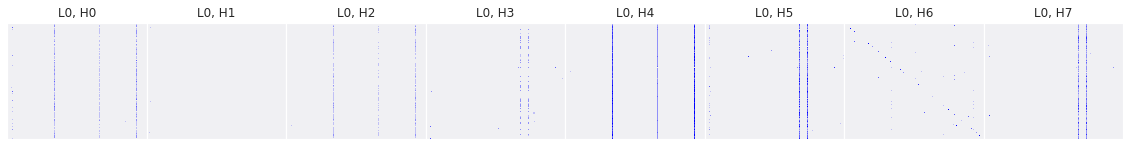

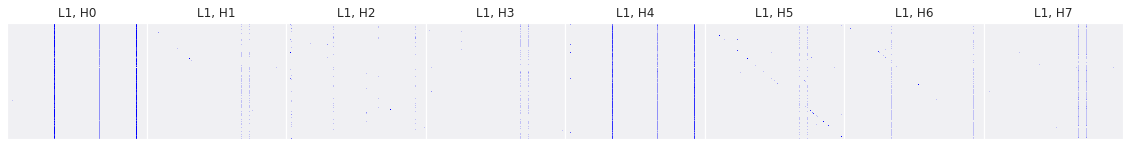

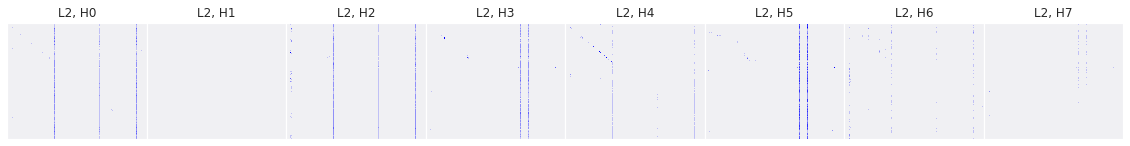

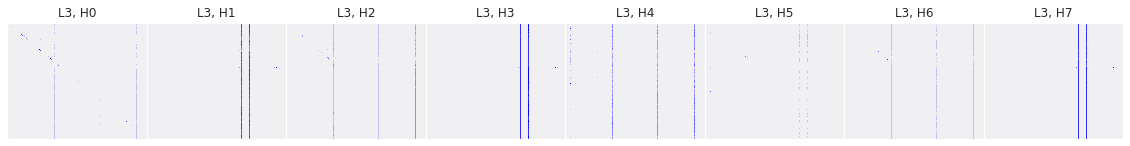

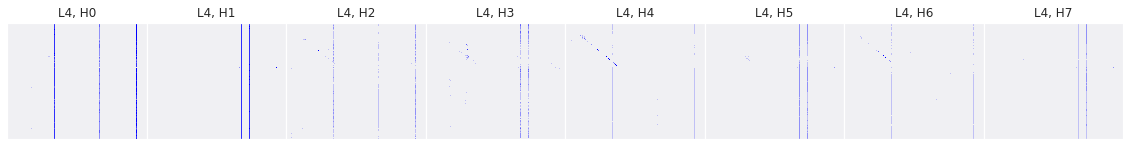

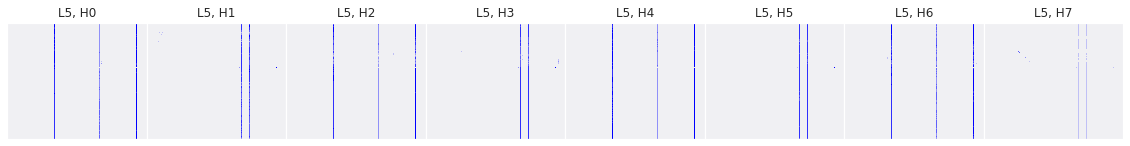

In [89]:
#Plot each attention head inside each layer
for lay in range(0, TOTAL_NO_LAYERS):
    plot_all_attentions(output, layer=lay)

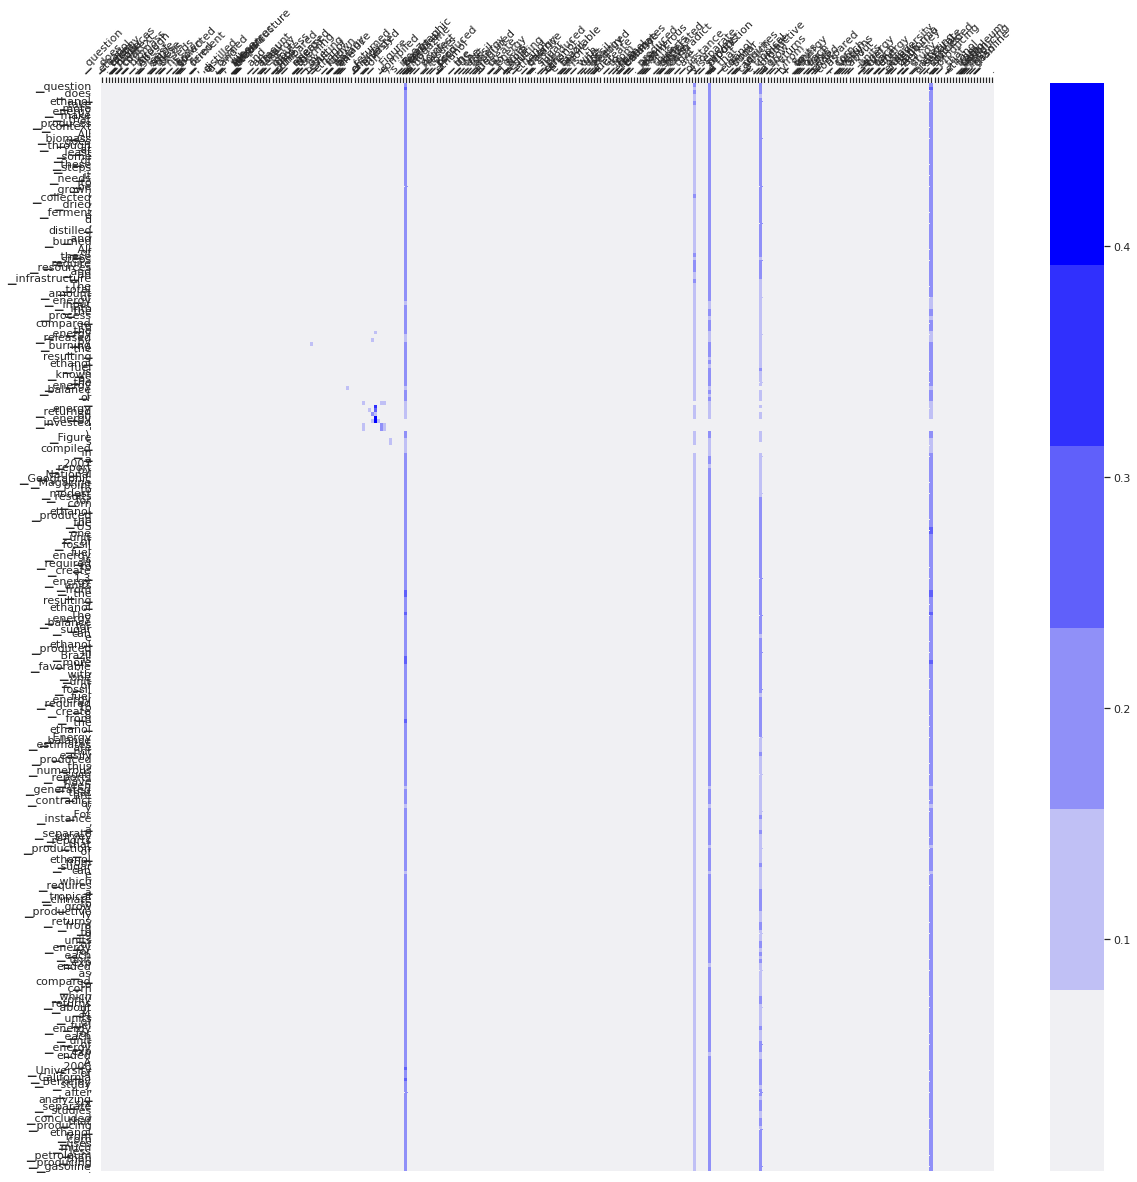

In [90]:
# Attention of layer 4 Head 5
plt_attentions(get_attentions(output, layer=4, attention_head=5), tokenized_text)

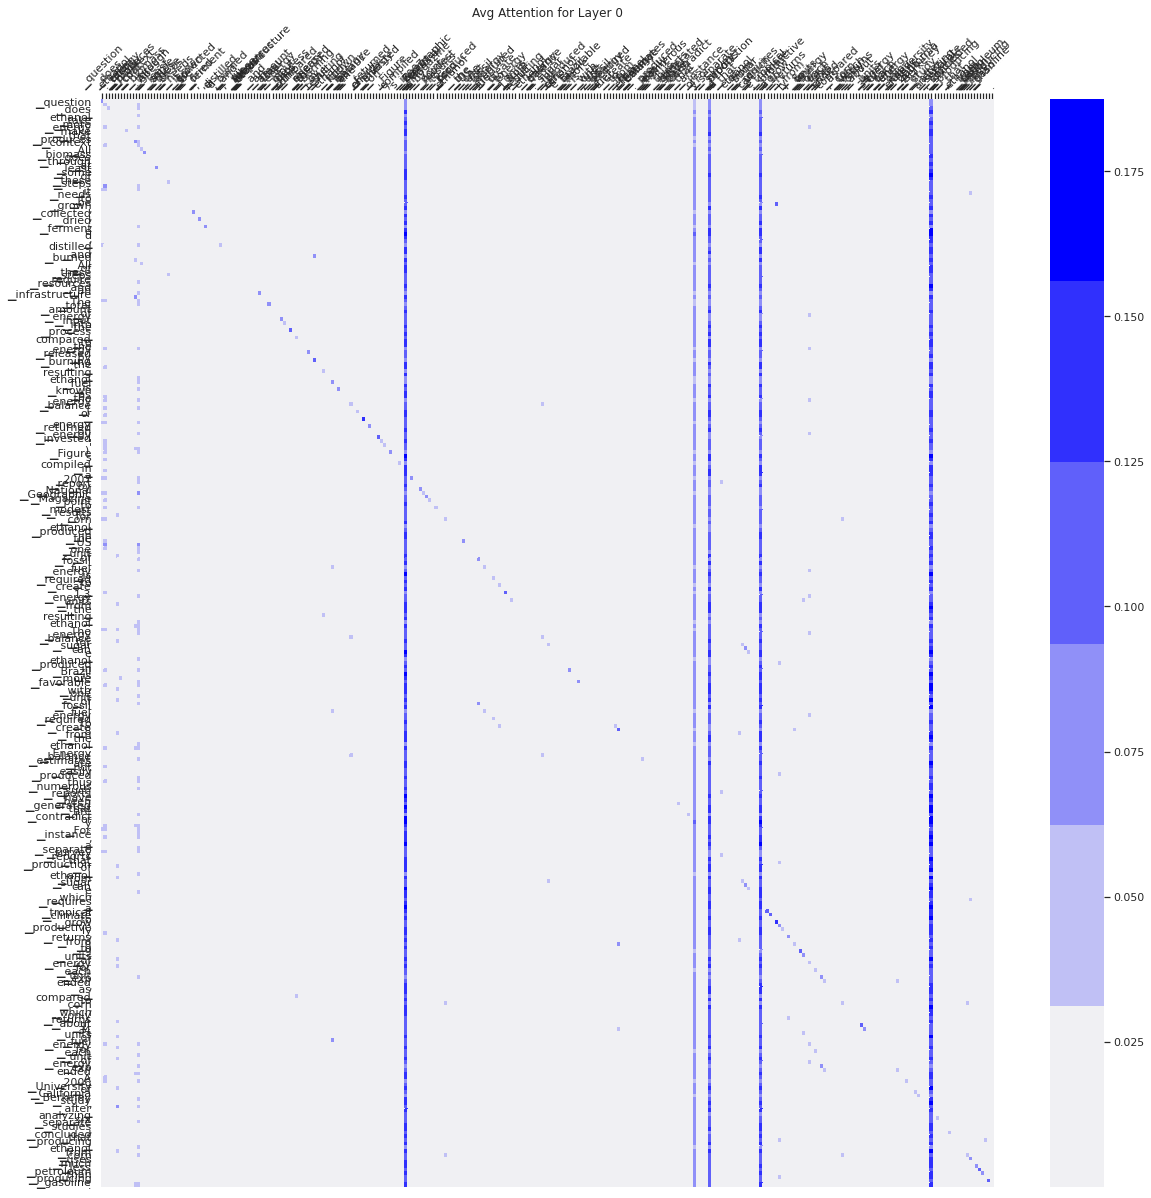

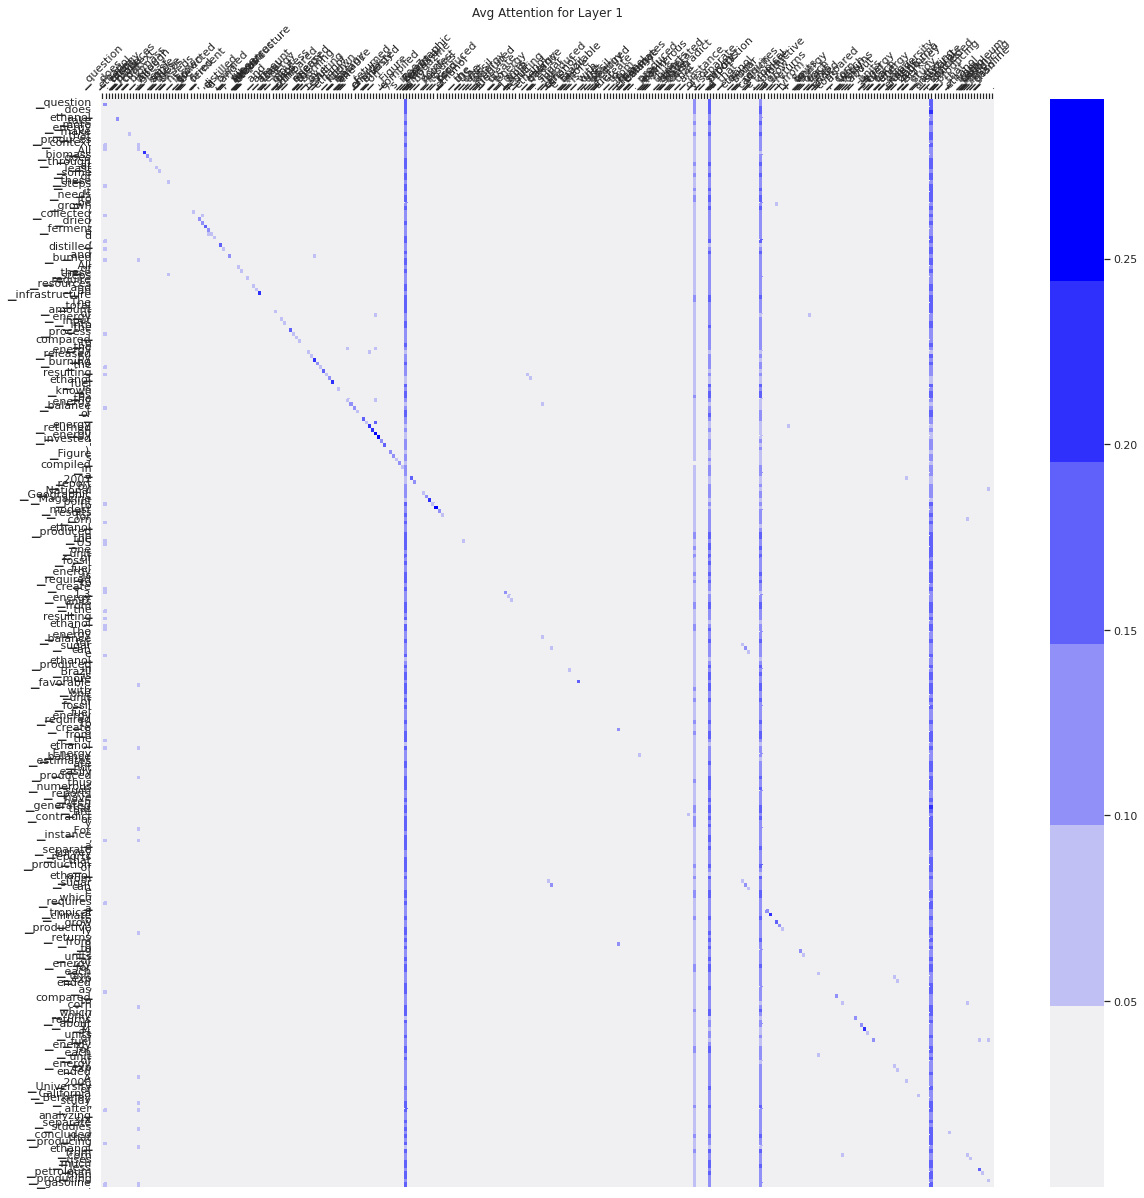

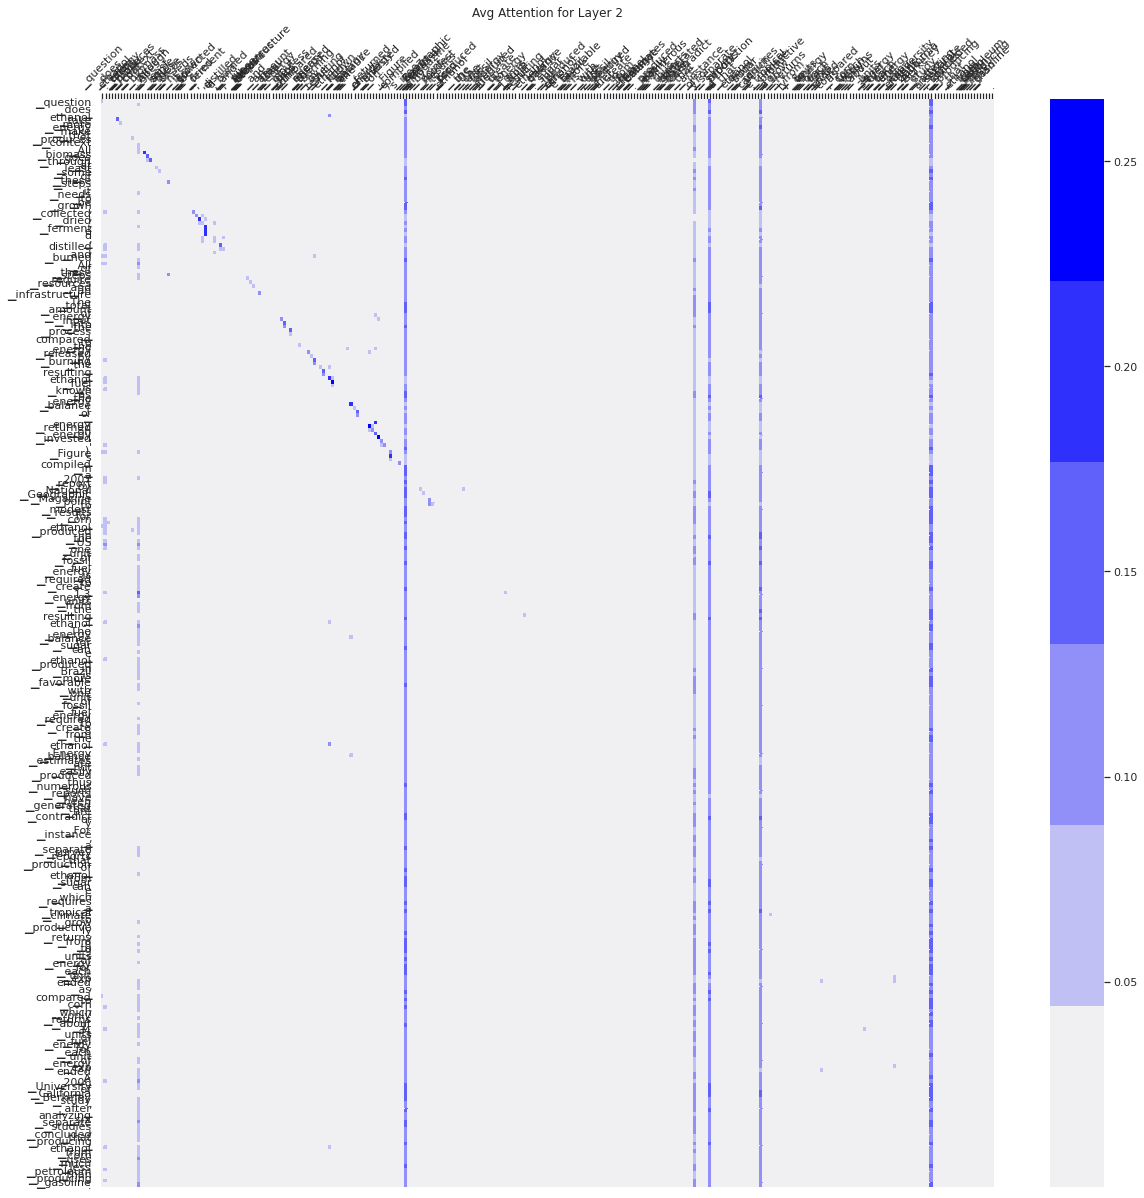

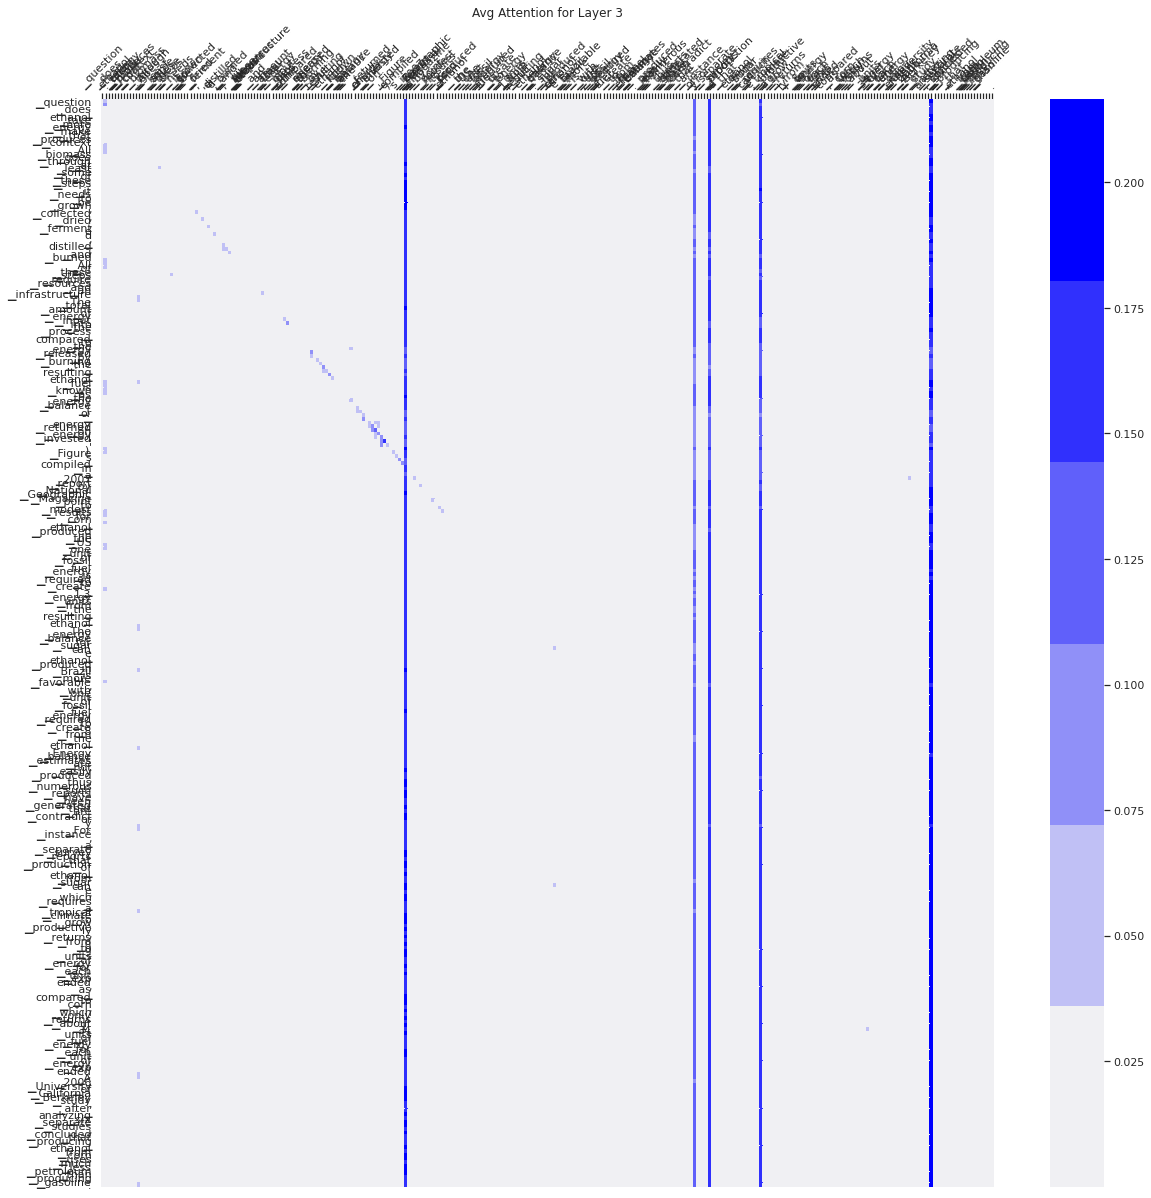

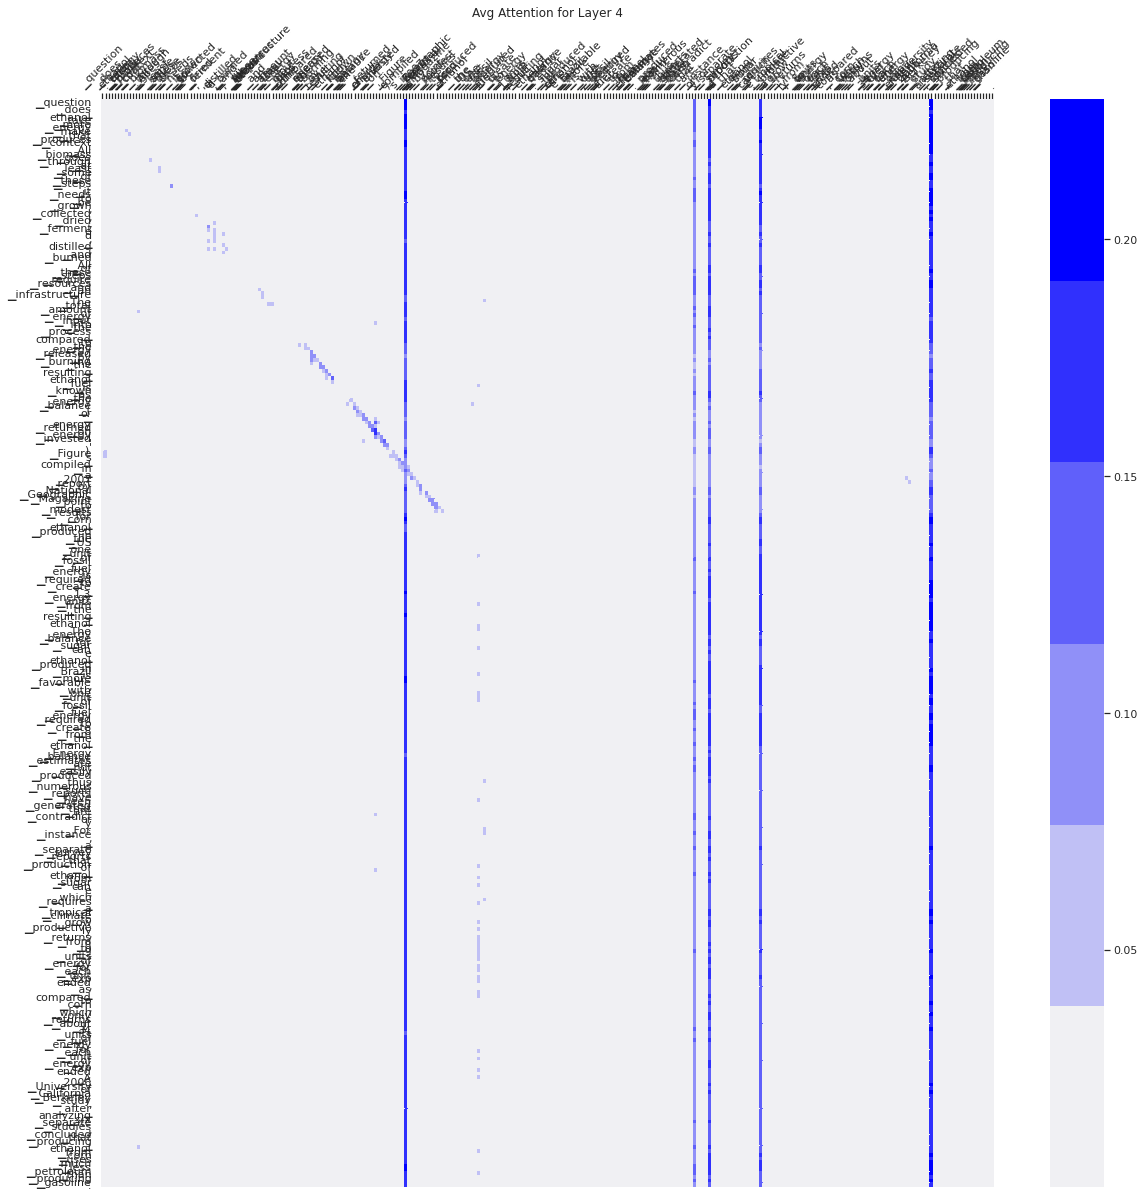

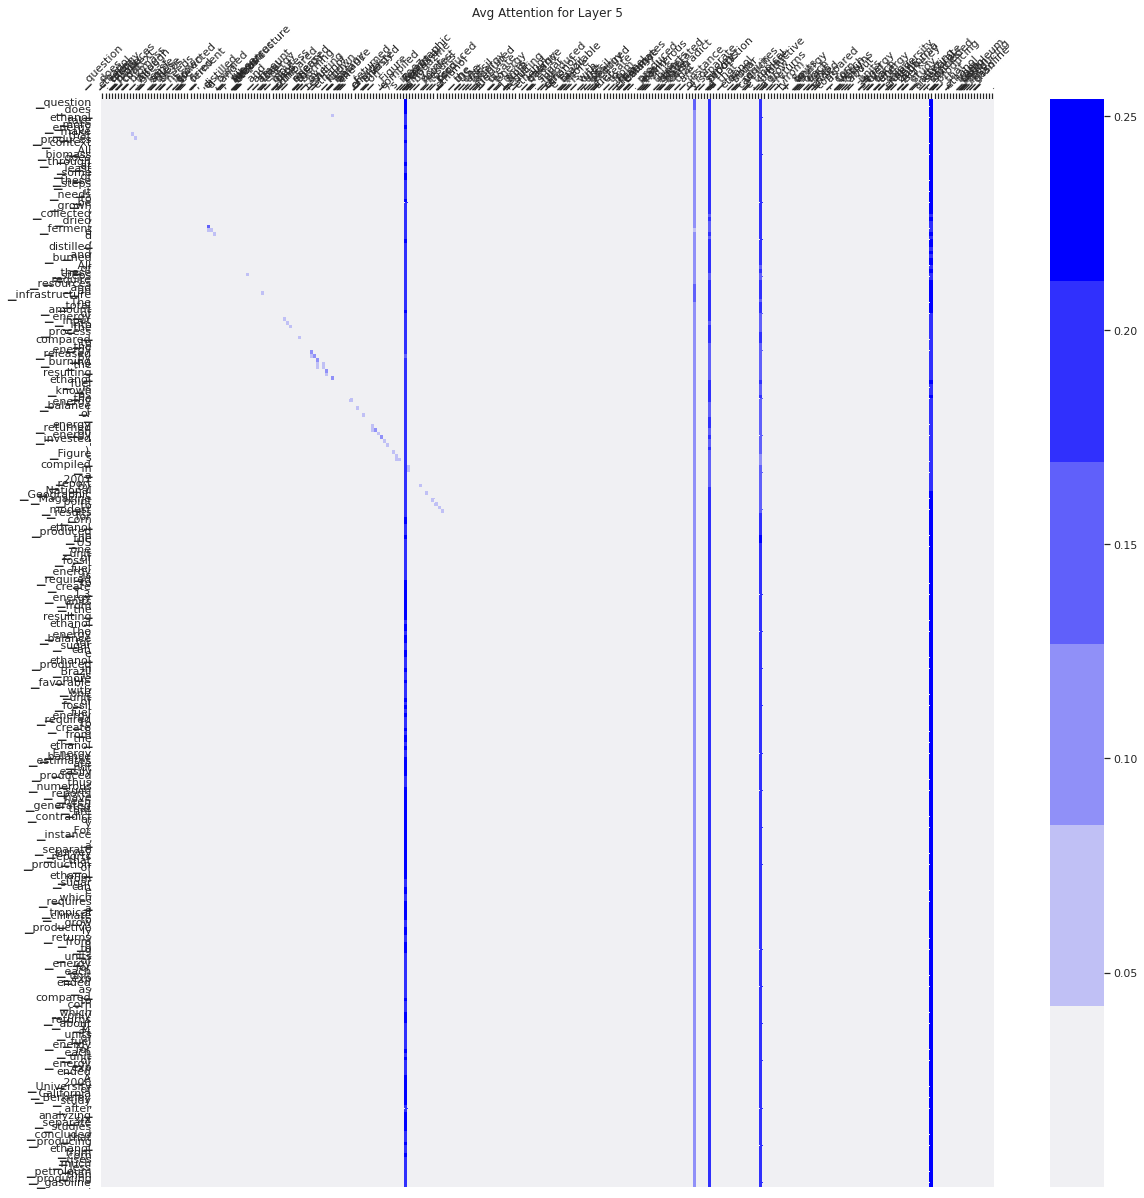

In [91]:
# Aggregation by layer
for lay in range(0, TOTAL_NO_LAYERS):
    plt_attentions(get_attentions(output, layer=lay, avg=True), tokenized_text, title="Avg Attention for Layer {}".format(lay))

### 2.2 Attention Matrix Aggregation

In [92]:
model = model.to('cuda')
model.eval()
confM = []
with torch.no_grad():
    for lay in range(0, TOTAL_NO_LAYERS):
        confML = []
        for h in range(0, TOTAL_NO_ATTEN_HEADS):
            max = 0
            for i in input:
                tokenized_text = tok.tokenize(i, max_length=512, truncation=True)
                tokenized_text_ids = tok.convert_tokens_to_ids(tokenized_text)
                tok.convert_ids_to_tokens(tokenized_text_ids)

                inp = torch.tensor(tokenized_text_ids)

                inp = inp.unsqueeze(dim=0)
                inp = inp.to('cuda')
                #Fwd pass - get output
                output = model(input_ids=inp, decoder_input_ids=inp)
                max = torch.max(output.cross_attentions[lay].squeeze(0)[h][2:, 2:]) + max #The attention weights of the prefixes are not taken into account
            confML.append(max/len(input))
        confM.append(torch.stack(confML))
confM = torch.stack(confM)

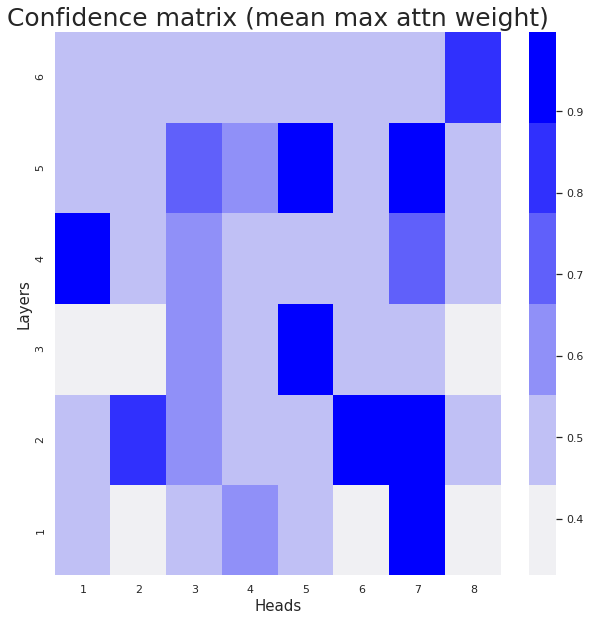

In [93]:
fig, ax = plt.subplots(figsize=(10,10)) 
  # labels = tokenizer.convert_ids_to_tokens(input[0][0:non_zero_idx+1].numpy());
  # ax = sns.heatmap(output[2][0].squeeze(0)[0][0:non_zero_idx+1, 0:non_zero_idx+1].detach().numpy(), annot=True, yticklabels=labs,xticklabels=labs)
ax = sns.heatmap(confM.detach().cpu().clone().numpy(), annot=False, yticklabels=range(1,7),xticklabels=range(1,9), cmap=CMAP)
#ax.xaxis.set_ticks_position('bottom')
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.invert_yaxis()
ax.set_title('Confidence matrix (mean max attn weight)', fontsize = 25)

plt.xlabel('Heads', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Layers', fontsize = 15) # y-axis label with fontsize 15

plt.show()

## **Translation**

### 2.1 Cross-Attention Matrix Visualization

In [94]:
CMAP = sns.light_palette("blue")
% matplotlib inline
np.random.seed(0);
TOTAL_NO_LAYERS = 6
TOTAL_NO_ATTEN_HEADS = 8

from datasets import load_dataset
import sklearn
from sklearn.model_selection import train_test_split

# loading dataset
bible_dataset = load_dataset("bible_para", lang1="en", lang2="fr", split='train')
bible_dataset_train, bible_dataset_test = train_test_split(bible_dataset, test_size=0.33, random_state=42)

# Creating the inputs/outputs

input = []
output = []
compteur = 0

for element in bible_dataset_test['translation']:
    input.append("translate English to French: " + str(element['en']))
    output.append(element['fr'])
    compteur += 1
    if compteur == 1000:
        break

Using custom data configuration en-fr-lang1=en,lang2=fr
Reusing dataset bible_para (/root/.cache/huggingface/datasets/bible_para/en-fr-lang1=en,lang2=fr/0.0.0/b6cc20bcbfb0299beeba1dcc80a8420b975938ca0eef75b3ed30b50df7d950b1)


In [95]:
# Loading a pre-trained model specific for translation
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-fr", output_attentions=True)
tok = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-fr")

tokenized_text = tok.tokenize(input[0])
tokenized_text_ids = tok.convert_tokens_to_ids(tokenized_text)
tok.convert_ids_to_tokens(tokenized_text_ids)

['▁translate',
 '▁English',
 '▁to',
 '▁French',
 ':',
 '▁I',
 '▁exhort',
 '▁the',
 '▁elders',
 '▁among',
 '▁you',
 ',',
 '▁as',
 '▁a',
 '▁fellow',
 '▁elder',
 ',',
 '▁and',
 '▁a',
 '▁witness',
 '▁of',
 '▁the',
 '▁suffering',
 's',
 '▁of',
 '▁Christ',
 ',',
 '▁and',
 '▁who',
 '▁will',
 '▁also',
 '▁share',
 '▁in',
 '▁the',
 '▁glory',
 '▁that',
 '▁will',
 '▁be',
 '▁revealed',
 '.']

In [96]:
#Convert to torch tensor
inp = torch.tensor(tokenized_text_ids)

print("input.shape: ", inp.shape) #torch.Size([15])
inp = inp.unsqueeze(dim=0) #add a dimension 
print("input.shape: ", inp.shape) #torch.Size([15])

#Fwd pass - get output
output = model(input_ids=inp, decoder_input_ids=inp) 
print("len(output): ", len(output))

input.shape:  torch.Size([40])
input.shape:  torch.Size([1, 40])
len(output):  6


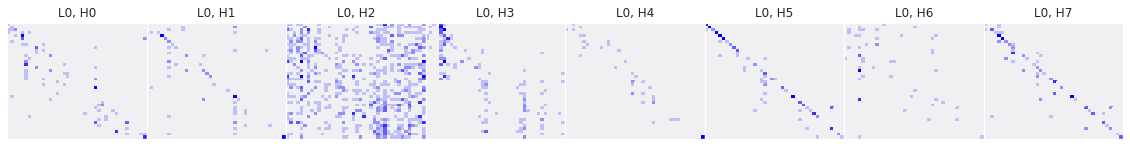

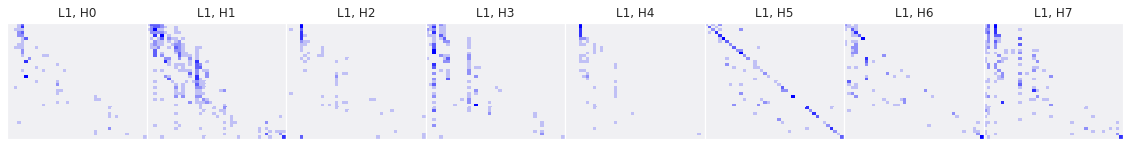

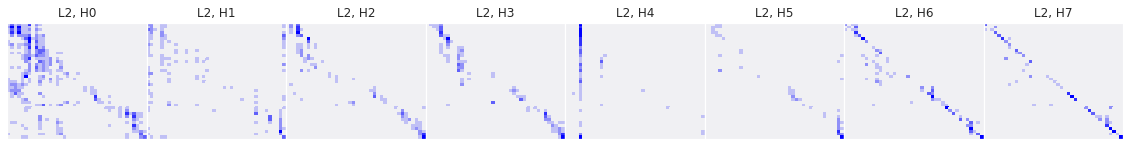

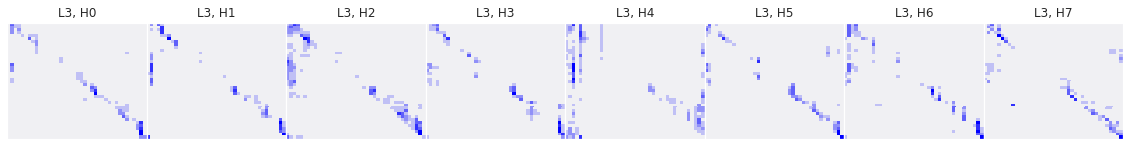

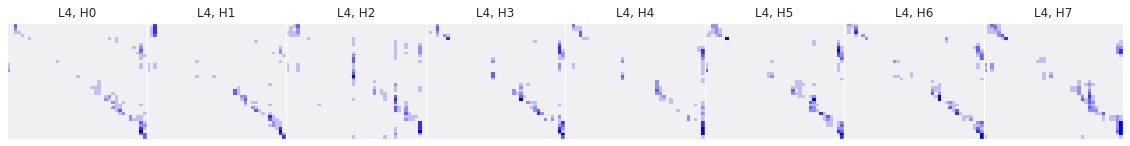

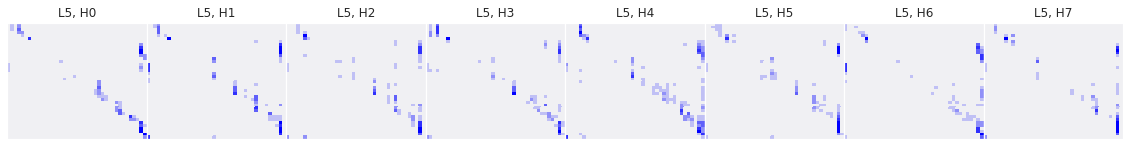

In [97]:
#Plot each attention head inside each layer
for lay in range(0, TOTAL_NO_LAYERS):
  plot_all_attentions(output, layer=lay)

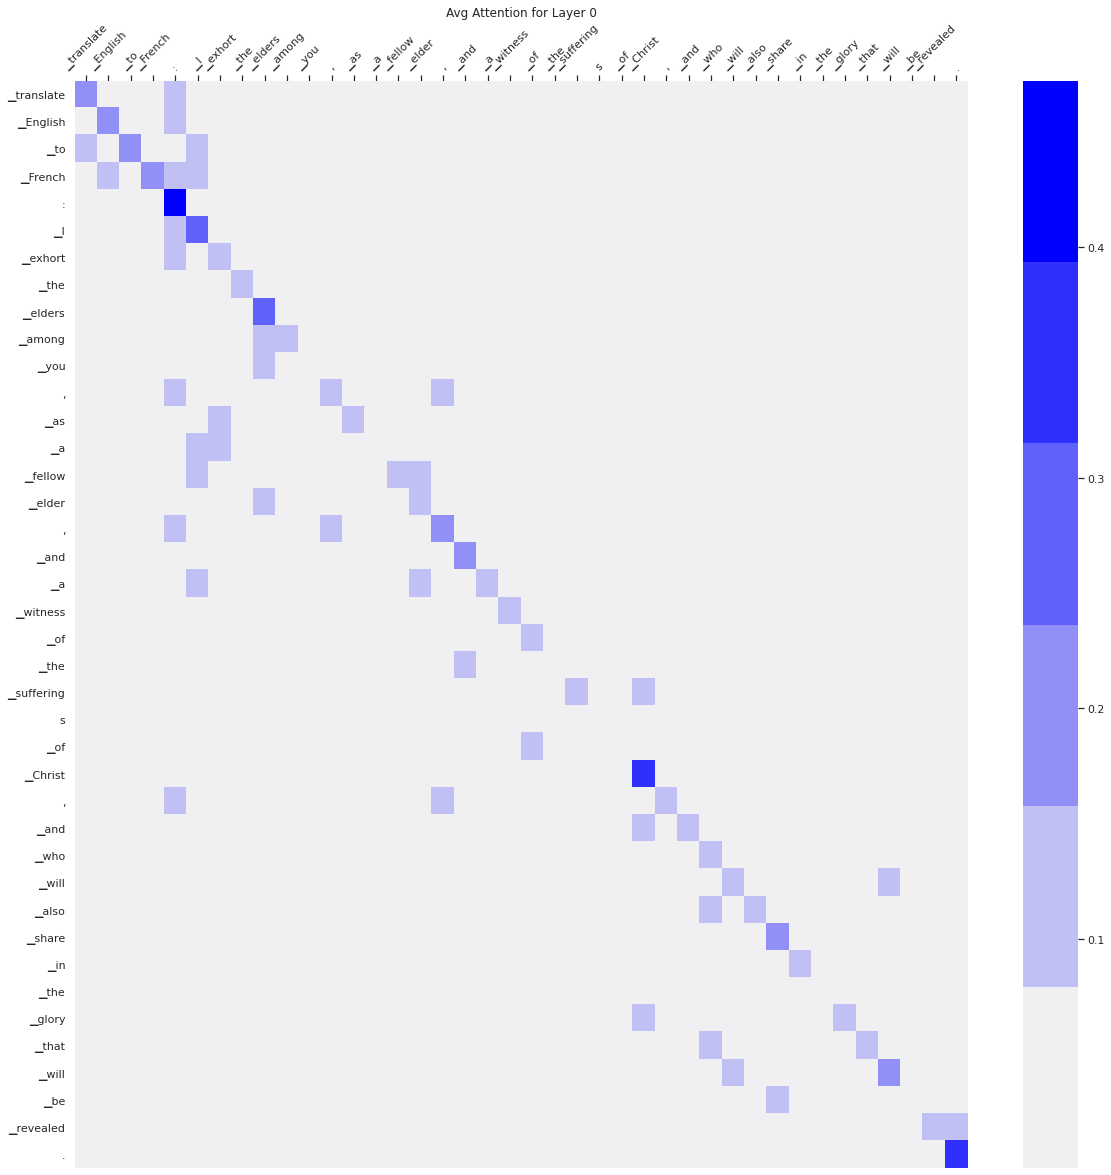

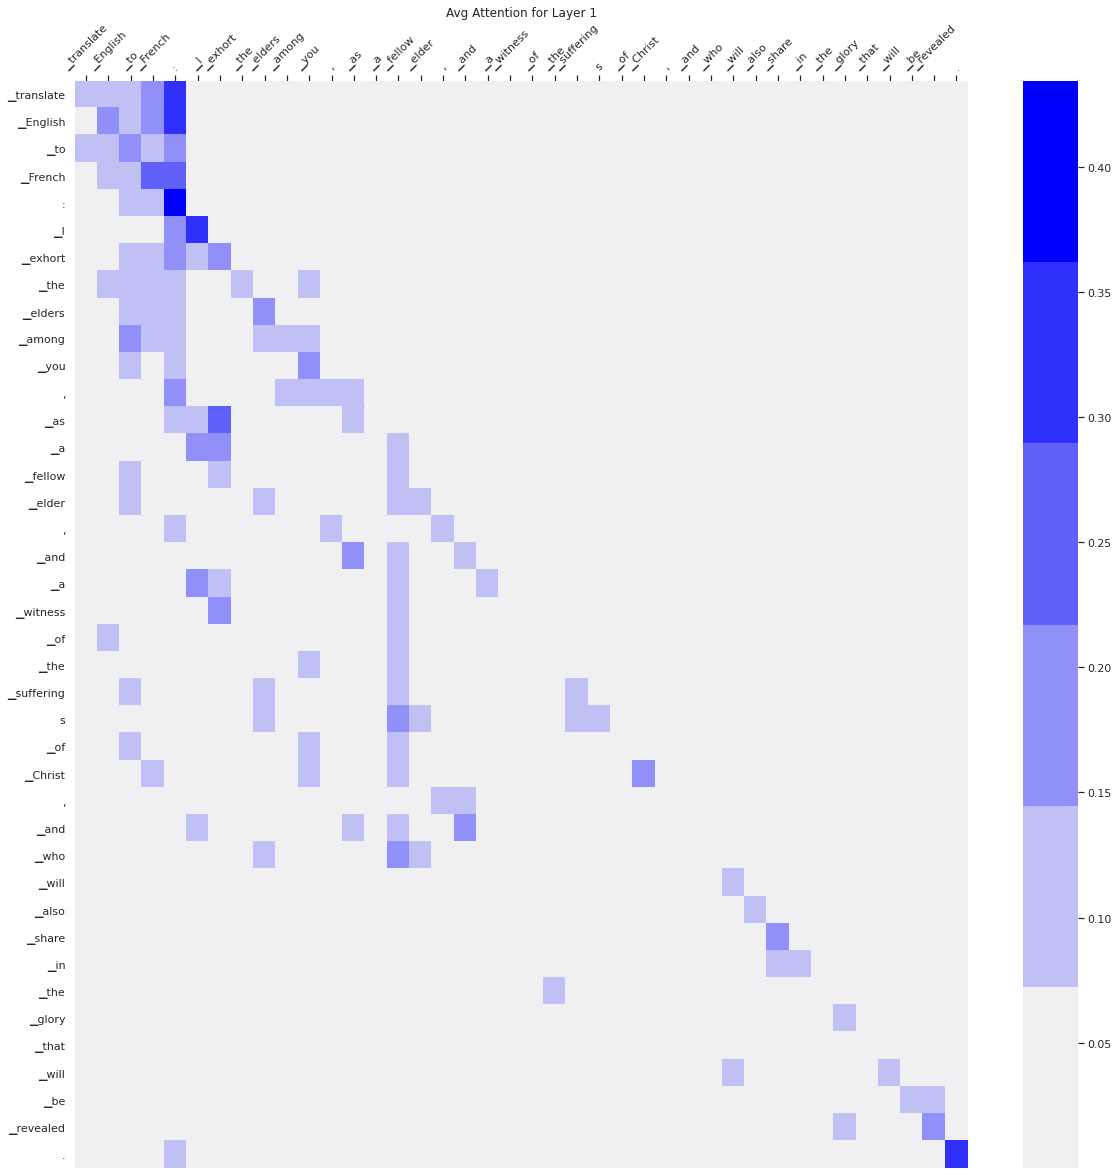

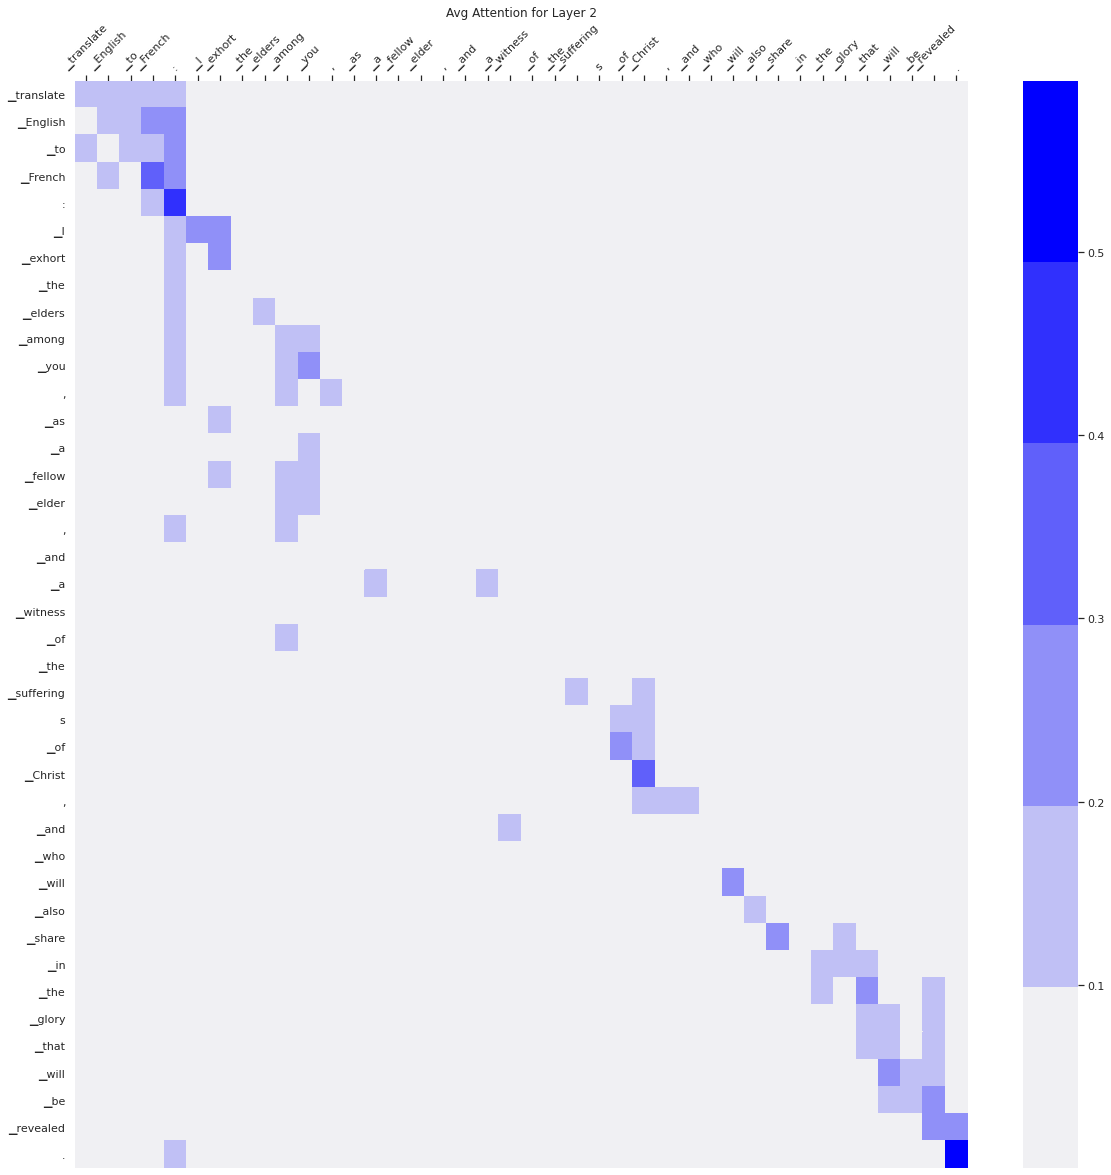

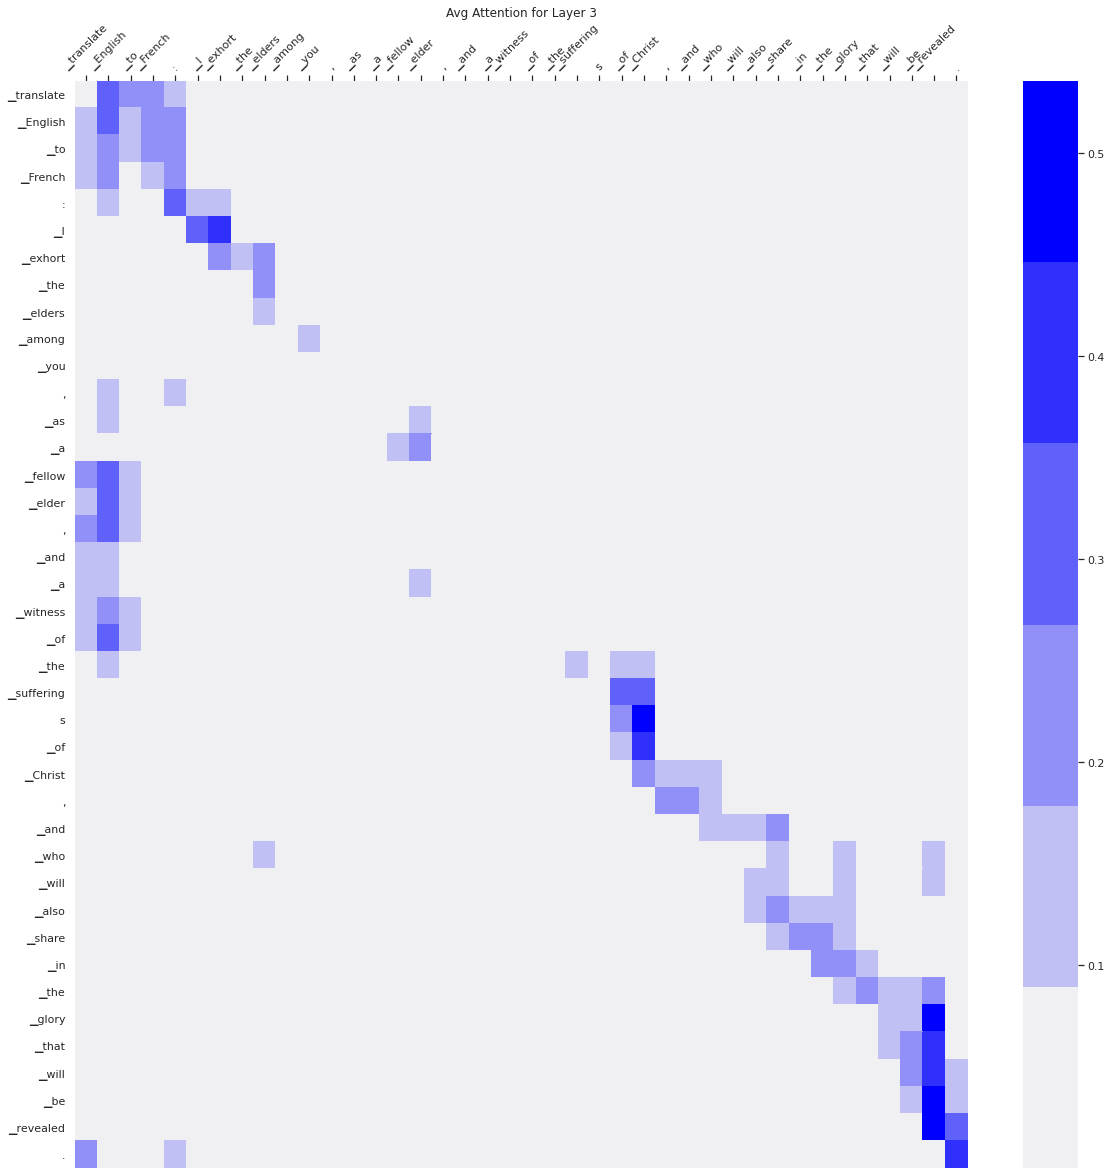

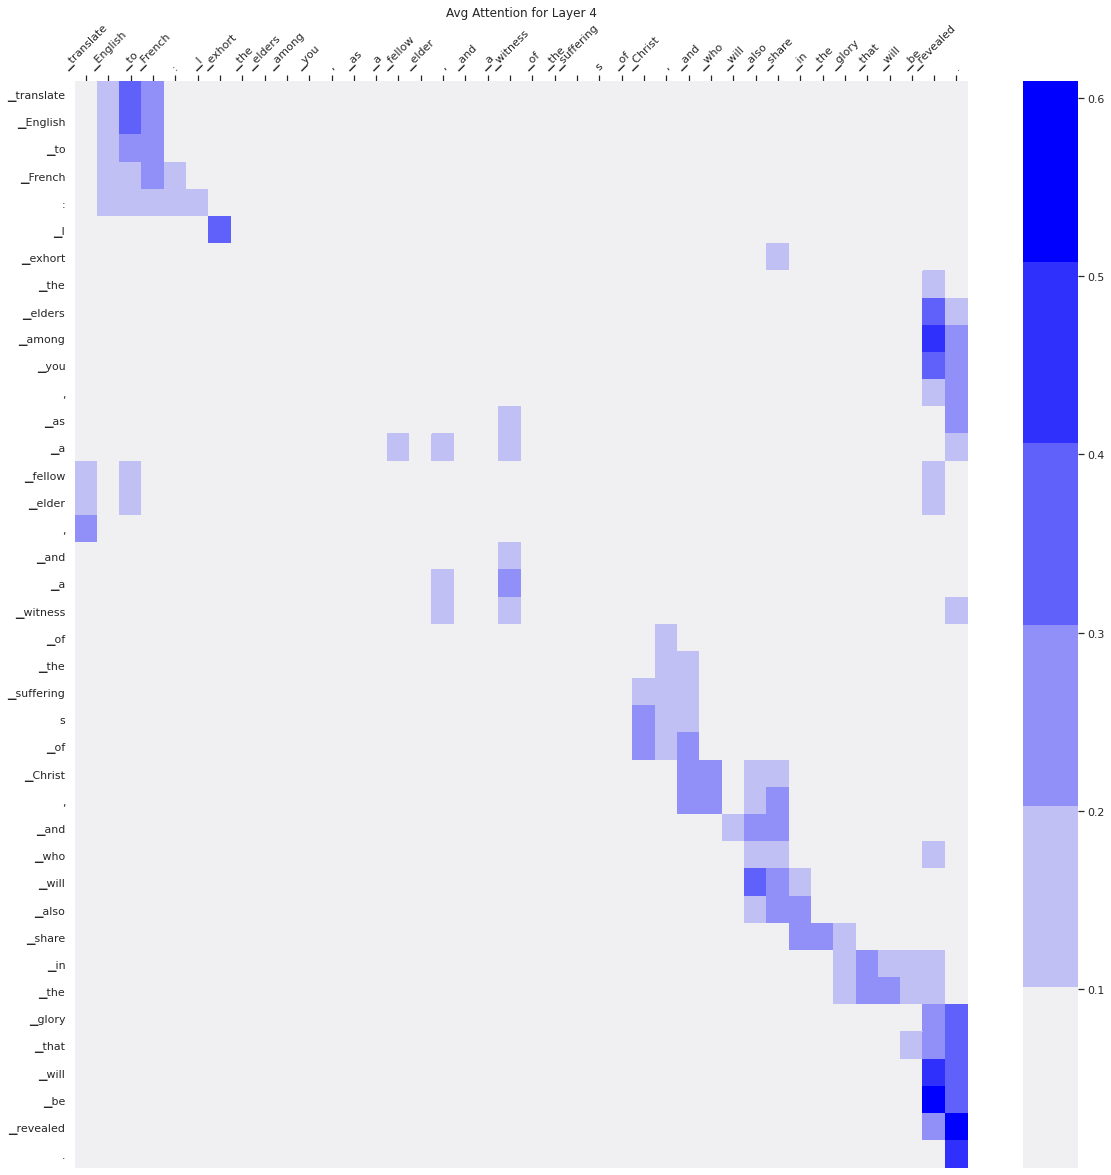

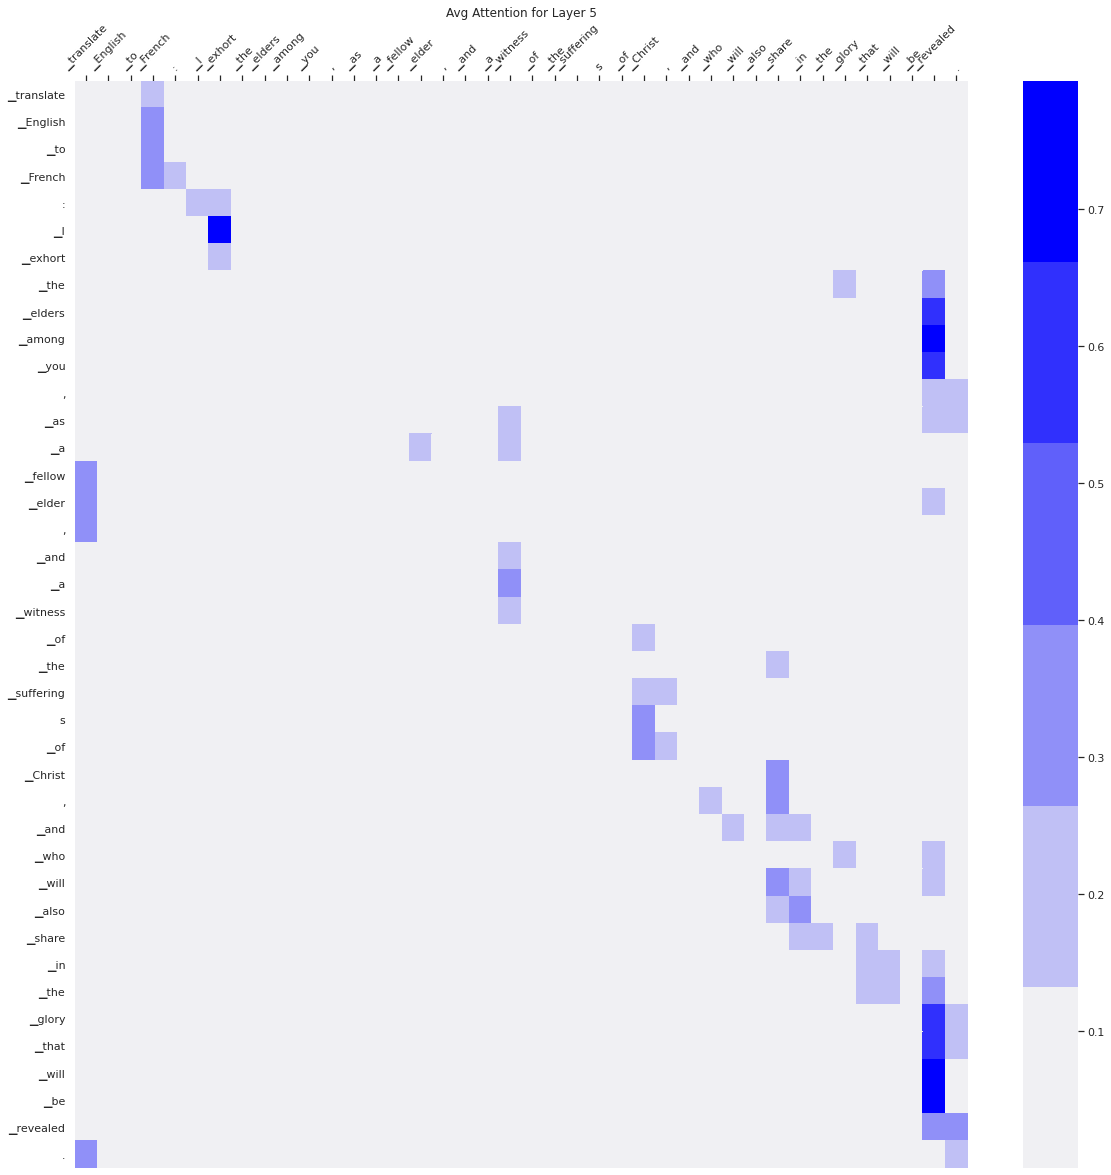

In [98]:
# Aggregation by layer
for lay in range(0, TOTAL_NO_LAYERS):
    plt_attentions(get_attentions(output, layer=lay, avg=True), tokenized_text, title="Avg Attention for Layer {}".format(lay))

### 2.2 Attention Matrix Aggregation

In [99]:
model = model.to('cuda')
model.eval()
confM = []
with torch.no_grad():
    for lay in range(0, TOTAL_NO_LAYERS):
        confML = []
        for h in range(0, TOTAL_NO_ATTEN_HEADS):
            max = 0
            for i in input:
                tokenized_text = tok.tokenize(i)
                tokenized_text_ids = tok.convert_tokens_to_ids(tokenized_text)
                tok.convert_ids_to_tokens(tokenized_text_ids)

                inp = torch.tensor(tokenized_text_ids)

                inp = inp.unsqueeze(dim=0)
                inp = inp.to('cuda')
                #Fwd pass - get output
                output = model(input_ids=inp, decoder_input_ids=inp)
                max = torch.max(output.cross_attentions[lay].squeeze(0)[h][5:, 5:]) + max #The attention weights of the prefixes are not taken into account
            confML.append(max/len(input))
        confM.append(torch.stack(confML))
confM = torch.stack(confM)

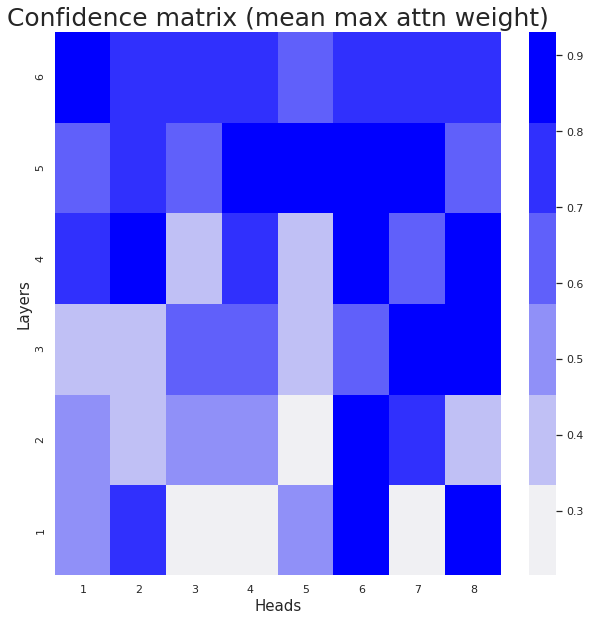

In [100]:
fig, ax = plt.subplots(figsize=(10,10)) 
  # labels = tokenizer.convert_ids_to_tokens(input[0][0:non_zero_idx+1].numpy());
  # ax = sns.heatmap(output[2][0].squeeze(0)[0][0:non_zero_idx+1, 0:non_zero_idx+1].detach().numpy(), annot=True, yticklabels=labs,xticklabels=labs)
ax = sns.heatmap(confM.detach().cpu().clone().numpy(), annot=False, yticklabels=range(1,7),xticklabels=range(1,9), cmap=CMAP)
#ax.xaxis.set_ticks_position('bottom')
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.invert_yaxis()
ax.set_title('Confidence matrix (mean max attn weight)', fontsize = 25)

plt.xlabel('Heads', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Layers', fontsize = 15) # y-axis label with fontsize 15

plt.show()

## **Summarization**

### 2.1 Cross-Attention Matrix Visualization

In [ ]:
CMAP = sns.light_palette("blue")
% matplotlib inline
np.random.seed(0);
TOTAL_NO_LAYERS = 6
TOTAL_NO_ATTEN_HEADS = 8

# loading dataset
cnn_dailymail_dataset = load_dataset('cnn_dailymail', '3.0.0')
cnn_dailymail_train_dataset = load_dataset('cnn_dailymail', '3.0.0', split='train')
cnn_dailymail_valid_dataset = load_dataset('cnn_dailymail', '3.0.0', split='validation')
cnn_dailymail_test_dataset = load_dataset('cnn_dailymail', '3.0.0', split='test')

input = []
compteur = 0

for element in cnn_dailymail_test_dataset['article']:
    input.append("summarize: " + str(element))
    compteur += 1
    if compteur == 100:
        break

In [ ]:
#Using a fine-tuned model for Summarization
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
  
model = AutoModelForSeq2SeqLM.from_pretrained("mrm8488/t5-base-finetuned-summarize-news", output_attentions=True)
tok = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-summarize-news")

tokenized_text = tok.tokenize(input[0])
tokenized_text_ids = tok.convert_tokens_to_ids(tokenized_text)
tok.convert_ids_to_tokens(tokenized_text_ids)

In [ ]:
#Convert to torch tensor
inp = torch.tensor(tokenized_text_ids)

print("input.shape: ", inp.shape) #torch.Size([15])
inp = inp.unsqueeze(dim=0) #add a dimension 
print("input.shape: ", inp.shape) #torch.Size([15])

#Fwd pass - get output
output = model(input_ids=inp, decoder_input_ids=inp) 
print("len(output): ", len(output.cross_attentions))

In [ ]:
#Plot each attention head inside each layer
for lay in range(0, TOTAL_NO_LAYERS):
    plot_all_attentions(output, layer=lay)

In [ ]:
# Aggregation by layer
for lay in range(0, TOTAL_NO_LAYERS):
    plt_attentions(get_attentions(output, layer=lay, avg=True), tokenized_text, title="Avg Attention for Layer {}".format(lay))

### 2.2 Attention Matrix Aggregation

In [ ]:
model = model.to('cuda')
model.eval()
confM = []
with torch.no_grad():
    for lay in range(0, TOTAL_NO_LAYERS):
        confML = []
        for h in range(0, TOTAL_NO_ATTEN_HEADS):
            max = 0
            for i in input:
                tokenized_text = tok.tokenize(i)
                tokenized_text_ids = tok.convert_tokens_to_ids(tokenized_text)
                tok.convert_ids_to_tokens(tokenized_text_ids)

                inp = torch.tensor(tokenized_text_ids)

                inp = inp.unsqueeze(dim=0)
                inp = inp.to('cuda')
                #Fwd pass - get output
                output = model(input_ids=inp, decoder_input_ids=inp)
                max = torch.max(output.cross_attentions[lay].squeeze(0)[h][2:, 2:]) + max #The attention weights of the prefixes are not taken into account
            confML.append(max/len(input))
        confM.append(torch.stack(confML))
confM = torch.stack(confM)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10)) 
  # labels = tokenizer.convert_ids_to_tokens(input[0][0:non_zero_idx+1].numpy());
  # ax = sns.heatmap(output[2][0].squeeze(0)[0][0:non_zero_idx+1, 0:non_zero_idx+1].detach().numpy(), annot=True, yticklabels=labs,xticklabels=labs)
ax = sns.heatmap(confM.detach().cpu().clone().numpy(), annot=False, yticklabels=range(1,7),xticklabels=range(1,9), cmap=CMAP)
#ax.xaxis.set_ticks_position('bottom')
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.invert_yaxis()
ax.set_title('Confidence matrix (mean max attn weight)', fontsize = 25)

plt.xlabel('Heads', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Layers', fontsize = 15) # y-axis label with fontsize 15

plt.show()

# Report

Here, we repeated Task 1 and 2, but using a fine-tuned model specific for 3 subtasks. For Task 1, instead of using the t5-small pre-trained model for all subtasks, we decided to use a more suitable model for each subtask. First, for the case of Question-Answering, we used the t5-base-finetuned-boolq model and tokenizer. By doing so, we were able to improve a little both the F1-score and the Exact Match from 0.32 to 0.34. Second, for the Translation task, we had two datasets and the model employed was Helsinki-NLP/opus-mt-en-fr. For the Bible dataset, we improved significantly the Bleu score, from 13 to 33. Similarly, for the TED Talks, we improved the Bleu score from 23 to 32. In both cases the BERT F-Score was maintained around the same high value. Finally, for the Summarization task, we used the t5-base-finetuned-summarize-news model and improved considerably the Rouge F1 score from 0.07 to 0.14, and kept the same high value for the BERT F1 score. All this shows the great power of using a task-oriented fine-tuned model in terms of performance. On the other hand, we did something similar for Task 2. For all subtasks, we can see how we can achieve a more detailed explanation (more attention patterns across layers and heads) and, therefore, a better understanding of the model's behaviour by using a more specific fine-tuned model for each subtask. We can see this for plots of attention heads inside each layer, and for the plots that do an aggregation of attention by layers as well. Additionally, for the attention matrix aggregation, we can see that our new results are not necessarily overconfident for all subtasks, as now we are using a different fine-tuned model for each subtask, and of course the confidence matrix varies more from task to task.